<a href="https://colab.research.google.com/github/AmyHumke12/SolarProject/blob/main/BI_Solar_Production_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Requirements

In [ ]:
!pip install astral
!pip install pandasql
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import requests
from datetime import datetime, timedelta
import os
from retry_requests import retry
import openmeteo_requests
import requests_cache
import pandasql as psql
import time
import pytz
from io import BytesIO
import numpy as np
import pickle
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import display
from matplotlib.ticker import FuncFormatter
from pandas.tseries.holiday import USFederalHolidayCalendar
import holidays
import calendar
# Ensure inline plotting in Jupyter notebooks or Google Colab
%matplotlib inline

#Mount drive

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Part 1 Build the future dataframes

In [ ]:
# Load the daylight data from the pickle file
daylight_df = pd.read_pickle('/content/drive/My Drive/daylight_df.pkl')



#Update the Solar Edge data with the actuals.

In [ ]:
# Load secrets from GitHub Codespaces
SOLAREDGE_API_KEY = os.getenv("SOLAREDGE_API_KEY")
SOLAREDGE_SITE_ID = os.getenv("SOLAREDGE_SITE_ID")

# Check if secrets are loaded correctly
if not SOLAREDGE_API_KEY or not SOLAREDGE_SITE_ID:
    raise ValueError("❌ SolarEdge API credentials are missing. Make sure they are set in GitHub Codespaces Secrets!")

print("✅ SolarEdge credentials loaded successfully!")


In [ ]:
import os
import time
import requests
import pandas as pd
from datetime import datetime, timedelta

# Function to fetch SolarEdge details
def fetch_solaredge_details(start_time, end_time):
    api_key = os.getenv('SOLAREDGE_API_KEY')
    site_id = os.getenv('SOLAREDGE_SITE_ID')

    url = f"https://monitoringapi.solaredge.com/site/{site_id}/energyDetails"

    params = {
        'meters': 'Production,Consumption,FeedIn,Purchased',
        'startTime': start_time,
        'endTime': end_time,
        'api_key': api_key,
        'timeUnit': 'HOUR'
    }

    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                return response.json()
            elif response.status_code == 429:
                print(f"Rate limit hit. Retrying... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(60)
            else:
                response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}. Retrying...")
            time.sleep(60)
    raise Exception(f"Failed to fetch data after {max_retries} attempts.")

# Function to normalize the fetched data
def normalize_data(data):
    meters = data['energyDetails']['meters']
    df_list = []
    for meter in meters:
        df = pd.json_normalize(meter, 'values')
        df['meter_type'] = meter['type']
        df_list.append(df)
    solaredge_df = pd.concat(df_list, ignore_index=True)
    return solaredge_df

# Load existing data if available
data_path = '/content/drive/My Drive/bi_solaredge_data.pkl'
if os.path.exists(data_path):
    solaredge_df = pd.read_pickle(data_path)
    if solaredge_df.empty:
        print("The data file is empty. Starting data collection from scratch.")
        solaredge_df = pd.DataFrame()
        start_time_dt = datetime(2024, 1, 1)
    else:
        print("Loaded existing data. Columns:", solaredge_df.columns)
        if 'date' in solaredge_df.columns:
            max_existing_date = solaredge_df['date'].max()
        elif 'date_timestamp' in solaredge_df.columns:
            max_existing_date = solaredge_df['date_timestamp'].max()
        else:
            raise KeyError("No suitable date column ('date' or 'date_timestamp') found in the existing data.")
        start_time_dt = datetime.strptime(max_existing_date, '%Y-%m-%d %H:%M:%S') + timedelta(hours=1)
else:
    print("No existing data file found. Starting data collection from scratch.")
    solaredge_df = pd.DataFrame()
    start_time_dt = datetime(2024, 1, 1)

# Define the end time as two days prior to today
end_of_two_days_ago = (datetime.now() - timedelta(days=3)).replace(hour=23, minute=59, second=59, microsecond=0)

# Loop to collect data
data_frames = []
while start_time_dt <= end_of_two_days_ago:
    if start_time_dt.month == datetime.now().month:
        end_time_dt = start_time_dt.replace(hour=23, minute=59, second=59)
    else:
        next_month = (start_time_dt.replace(day=1) + timedelta(days=32)).replace(day=1)
        end_time_dt = min(next_month - timedelta(seconds=1), end_of_two_days_ago)

    start_time = start_time_dt.strftime('%Y-%m-%d %H:%M:%S')
    end_time = end_time_dt.strftime('%Y-%m-%d %H:%M:%S')

    print(f"Fetching data from {start_time} to {end_time}")
    try:
        data_period = fetch_solaredge_details(start_time, end_time)
        if data_period:
            df = normalize_data(data_period)
            data_frames.append(df)
        else:
            print("No data returned for this period.")
    except Exception as e:
        print(f"Error fetching data: {e}")
        break

    if start_time_dt.month == datetime.now().month:
        start_time_dt += timedelta(days=1)
    else:
        start_time_dt = next_month

# Combine all data and remove duplicates
if data_frames:
    new_data = pd.concat(data_frames, ignore_index=True)
    new_data = new_data.drop_duplicates(subset=['date', 'meter_type', 'value'])

    # Merge new data with existing data
    if not solaredge_df.empty:
        solaredge_df = pd.concat([solaredge_df, new_data], ignore_index=True)
        solaredge_df = solaredge_df.drop_duplicates(subset=['date', 'meter_type', 'value'])
    else:
        solaredge_df = new_data

# Sort data by date and meter type to ensure consistency
if not solaredge_df.empty:
    solaredge_df = solaredge_df.sort_values(by=['date', 'meter_type']).reset_index(drop=True)

    # Save the updated data
    solaredge_df.to_pickle(data_path)
    print("Data saved successfully.")
else:
    print("No new data to save.")


Loaded existing data. Columns: Index(['date', 'meter_type', 'value'], dtype='object')
Data saved successfully.


In [ ]:
# #In case you need to erase the file and start over again

# # Create an empty DataFrame
# empty_df = pd.DataFrame()

# # Save the empty DataFrame to the pickle file, overwriting the existing data
# empty_df.to_pickle('/content/drive/My Drive/bi_solaredge_data.pkl')

# print("The solaredge_data.pkl file has been erased and replaced with an empty DataFrame.")


In [ ]:
solaredge_df

date   meter_type   value
0      2024-01-01 00:00:00  Consumption     NaN
1      2024-01-01 00:00:00       FeedIn     NaN
2      2024-01-01 00:00:00   Production     NaN
3      2024-01-01 00:00:00    Purchased     NaN
4      2024-01-01 01:00:00  Consumption     NaN
...                    ...          ...     ...
39451  2025-02-14 22:00:00    Purchased  1377.0
39452  2025-02-14 23:00:00  Consumption   925.0
39453  2025-02-14 23:00:00       FeedIn     0.0
39454  2025-02-14 23:00:00   Production     0.0
39455  2025-02-14 23:00:00    Purchased   925.0

[39456 rows x 3 columns]

In [ ]:
# Load the saved DataFrame from the pickle file
solaredge_process = pd.read_pickle('/content/drive/My Drive/bi_solaredge_data.pkl')



In [ ]:
# Ensure 'date' is in datetime format
solaredge_process['date'] = pd.to_datetime(solaredge_process['date'])

# Filter for rows where the date is equal to 2024-05-30 and the hour is 12 (noon)
filtered_data = solaredge_process[(solaredge_process['date'].dt.date == pd.to_datetime('2024-05-30').date()) &
                                  (solaredge_process['date'].dt.hour == 12)]

# Display the filtered data
print(filtered_data)


                     date   meter_type    value
14448 2024-05-30 12:00:00  Consumption      NaN
14449 2024-05-30 12:00:00       FeedIn      NaN
14450 2024-05-30 12:00:00   Production  11948.0
14451 2024-05-30 12:00:00    Purchased      NaN


In [ ]:
# Ensure 'date' is in datetime format
solaredge_process['date'] = pd.to_datetime(solaredge_process['date'])

# Filter for rows where the date is equal to 2024-06-30 and the hour is 12 (noon)
filtered_data = solaredge_process[(solaredge_process['date'].dt.date == pd.to_datetime('2024-06-30').date()) &
                                  (solaredge_process['date'].dt.hour == 12)]

# Display the filtered data
print(filtered_data)

                     date   meter_type   value
17424 2024-06-30 12:00:00  Consumption  1517.0
17425 2024-06-30 12:00:00       FeedIn  8210.0
17426 2024-06-30 12:00:00   Production  9727.0
17427 2024-06-30 12:00:00    Purchased     0.0


In [ ]:
#Local and timezone methods of getting today's date to return accurately failed. Using this to drop data from 'today' because it is incomplete.
# Ensure the 'date' column is in datetime format
solaredge_process['date'] = pd.to_datetime(solaredge_process['date'])

# Get the current UTC time
utc_now = datetime.utcnow()

# Adjust for the local timezone (assuming your timezone is UTC-5, adjust accordingly)
local_now = utc_now - timedelta(hours=5)

# Extract just the local date
today_date = pd.to_datetime(local_now.date())

# Filter out rows with today's date
solaredge_process = solaredge_process[solaredge_process['date'] < today_date]

# Optional: Display the number of rows remaining
rows_remaining = solaredge_process.shape[0]
print(f"Rows remaining after removing today's data: {rows_remaining}")

# Save the cleaned DataFrame if needed
solaredge_process.to_pickle('/content/drive/My Drive/bi_solaredge_data_process.pkl')


Rows remaining after removing today's data: 39456


#Transform to kWh

In [ ]:
# Divide the 'value' column by 1000
solaredge_process['value'] = solaredge_process['value'] / 1000

# Display the first few rows to verify the changes
print(solaredge_process.head())


                 date   meter_type  value
0 2024-01-01 00:00:00  Consumption    NaN
1 2024-01-01 00:00:00       FeedIn    NaN
2 2024-01-01 00:00:00   Production    NaN
3 2024-01-01 00:00:00    Purchased    NaN
4 2024-01-01 01:00:00  Consumption    NaN


In [ ]:
solaredge_process.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39456 entries, 0 to 39455
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        39456 non-null  datetime64[ns]
 1   meter_type  39456 non-null  object        
 2   value       28376 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 924.9+ KB


In [ ]:
solaredge_process

date   meter_type  value
0     2024-01-01 00:00:00  Consumption    NaN
1     2024-01-01 00:00:00       FeedIn    NaN
2     2024-01-01 00:00:00   Production    NaN
3     2024-01-01 00:00:00    Purchased    NaN
4     2024-01-01 01:00:00  Consumption    NaN
...                   ...          ...    ...
39451 2025-02-14 22:00:00    Purchased  1.377
39452 2025-02-14 23:00:00  Consumption  0.925
39453 2025-02-14 23:00:00       FeedIn  0.000
39454 2025-02-14 23:00:00   Production  0.000
39455 2025-02-14 23:00:00    Purchased  0.925

[39456 rows x 3 columns]

In [ ]:
# Ensure 'date' is in datetime format
solaredge_process['date'] = pd.to_datetime(solaredge_process['date'])

# Filter for rows where the date is equal to 2024-05-30 and the hour is 12 (noon)
filtered_data = solaredge_process[(solaredge_process['date'].dt.date == pd.to_datetime('2024-05-30').date()) &
                                  (solaredge_process['date'].dt.hour == 12)]

# Display the filtered data
print(filtered_data)

                     date   meter_type   value
14448 2024-05-30 12:00:00  Consumption     NaN
14449 2024-05-30 12:00:00       FeedIn     NaN
14450 2024-05-30 12:00:00   Production  11.948
14451 2024-05-30 12:00:00    Purchased     NaN


In [ ]:
#Check for duplicates
# Create a combination of 'date' and 'meter_type' as a new column
solaredge_process['date_meter_combination'] = solaredge_process['date'].astype(str) + "_" + solaredge_process['meter_type']

# Find the combinations that have more than one occurrence
duplicate_combinations = solaredge_process['date_meter_combination'].value_counts()

# Filter to keep only those that appear more than once
duplicate_combinations = duplicate_combinations[duplicate_combinations > 1]

# Display the duplicate combinations
print("Duplicate date and meter_type combinations (with more than one occurrence):")
print(duplicate_combinations)


Duplicate date and meter_type combinations (with more than one occurrence):
Series([], Name: count, dtype: int64)


In [ ]:
solaredge_process.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39456 entries, 0 to 39455
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    39456 non-null  datetime64[ns]
 1   meter_type              39456 non-null  object        
 2   value                   28376 non-null  float64       
 3   date_meter_combination  39456 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.2+ MB


In [ ]:
# Ensure 'date' is in datetime format
solaredge_process['date'] = pd.to_datetime(solaredge_process['date'])

# Filter the data for 'Consumption' meter type and the specific date 6/15/2024
# We assume the 'date' column contains the timestamp, including hours
consumption_on_june_15 = solaredge_process[
    (solaredge_process['meter_type'] == 'Consumption') &
    (solaredge_process['date'].dt.date == pd.Timestamp('2024-08-15').date())
]

# Sort the data by time to ensure it's displayed in order
consumption_on_june_15 = consumption_on_june_15.sort_values(by='date')

# Display the filtered data with hour-level granularity
print(consumption_on_june_15[['date', 'value']])


                     date   value
21792 2024-08-15 00:00:00   1.322
21796 2024-08-15 01:00:00   1.305
21800 2024-08-15 02:00:00   1.295
21804 2024-08-15 03:00:00   1.340
21808 2024-08-15 04:00:00   1.323
21812 2024-08-15 05:00:00   1.389
21816 2024-08-15 06:00:00   1.781
21820 2024-08-15 07:00:00   1.455
21824 2024-08-15 08:00:00   1.272
21828 2024-08-15 09:00:00   1.299
21832 2024-08-15 10:00:00   1.321
21836 2024-08-15 11:00:00   1.224
21840 2024-08-15 12:00:00   1.531
21844 2024-08-15 13:00:00   1.840
21848 2024-08-15 14:00:00   1.264
21852 2024-08-15 15:00:00   2.134
21856 2024-08-15 16:00:00   1.256
21860 2024-08-15 17:00:00   3.273
21864 2024-08-15 18:00:00  10.082
21868 2024-08-15 19:00:00   9.477
21872 2024-08-15 20:00:00  10.583
21876 2024-08-15 21:00:00   9.967
21880 2024-08-15 22:00:00   5.487
21884 2024-08-15 23:00:00   1.277


month
2024-01-01       0.000
2024-02-01       0.000
2024-03-01       0.000
2024-04-01       0.000
2024-05-01      14.229
2024-06-01    1551.439
2024-07-01    1597.729
2024-08-01    1774.062
2024-09-01    1388.996
2024-10-01    1099.690
Name: value, dtype: float64


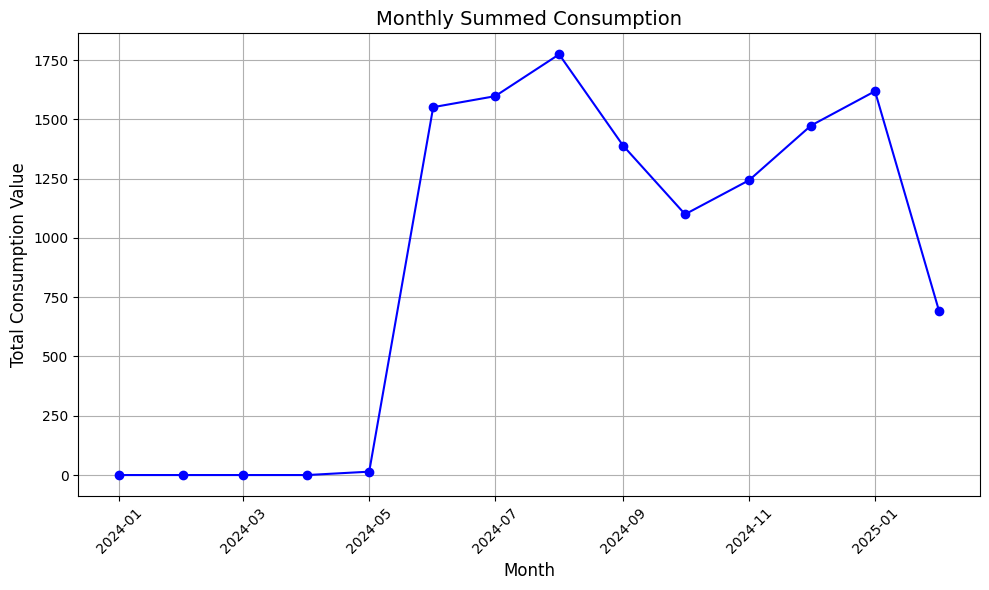

In [ ]:
# Ensure 'date' is in datetime format
solaredge_process['date'] = pd.to_datetime(solaredge_process['date'])

# Step 1: Filter the data where meter_type is 'Consumption'
consumption_df = solaredge_process[solaredge_process['meter_type'] == 'Consumption'].copy()

# Step 2: Truncate the 'date' to the beginning of the month using .loc to avoid SettingWithCopyWarning
consumption_df.loc[:, 'month'] = consumption_df['date'].dt.to_period('M').dt.to_timestamp()

# Step 3: Group by the truncated month and sum the 'value' column
monthly_consumption = consumption_df.groupby('month')['value'].sum()

# Check the data to understand the values and potential issues
print(monthly_consumption.head(10))

# Step 4: Plot the monthly summed consumption
plt.figure(figsize=(10, 6))
plt.plot(monthly_consumption.index, monthly_consumption.values, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Monthly Summed Consumption', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Consumption Value', fontsize=12)

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


month
2024-01-01     118.575
2024-02-01    1162.688
2024-03-01     822.196
2024-04-01     887.326
2024-05-01    1796.752
2024-06-01    2268.325
2024-07-01    2242.938
2024-08-01    2039.035
2024-09-01    1799.839
2024-10-01    1464.660
Name: value, dtype: float64


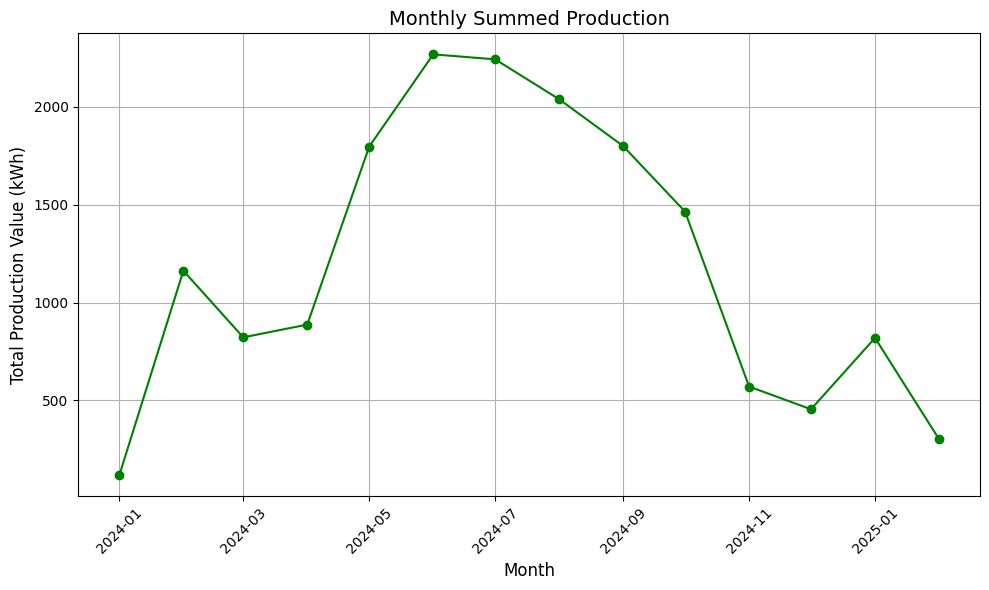

In [ ]:
# Ensure 'date' is in datetime format
solaredge_process['date'] = pd.to_datetime(solaredge_process['date'])

# Step 1: Filter the data where meter_type is 'Production'
production_df = solaredge_process[solaredge_process['meter_type'] == 'Production'].copy()

# Step 2: Truncate the 'date' to the beginning of the month using .loc to avoid SettingWithCopyWarning
production_df.loc[:, 'month'] = production_df['date'].dt.to_period('M').dt.to_timestamp()

# Step 3: Group by the truncated month and sum the 'value' column
monthly_production = production_df.groupby('month')['value'].sum()

# Check the data to understand the values and potential issues
print(monthly_production.head(10))

# Step 4: Plot the monthly summed production
plt.figure(figsize=(10, 6))
plt.plot(monthly_production.index, monthly_production.values, marker='o', linestyle='-', color='g', label='Production')

# Adding titles and labels
plt.title('Monthly Summed Production', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Production Value (kWh)', fontsize=12)  # Adjust the unit if necessary

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Ensure 'date' is in datetime format
solaredge_process['date'] = pd.to_datetime(solaredge_process['date'])

# Define the specific date
specific_date = pd.to_datetime('2024-07-15')

# Filter the data for Production on July 15, 2024
production_data = solaredge_process[(solaredge_process['date'].dt.date == specific_date.date()) & (solaredge_process['meter_type'] == 'Production')]

# Filter the data for Consumption on July 15, 2024
consumption_data = solaredge_process[(solaredge_process['date'].dt.date == specific_date.date()) & (solaredge_process['meter_type'] == 'Consumption')]

# Display the data
print("Production Data on July 15, 2024:")
print(production_data)

print("\nConsumption Data on July 15, 2024:")
print(consumption_data)


Production Data on July 15, 2024:
                     date  meter_type   value          date_meter_combination
18818 2024-07-15 00:00:00  Production   0.000  2024-07-15 00:00:00_Production
18822 2024-07-15 01:00:00  Production   0.000  2024-07-15 01:00:00_Production
18826 2024-07-15 02:00:00  Production   0.000  2024-07-15 02:00:00_Production
18830 2024-07-15 03:00:00  Production   0.000  2024-07-15 03:00:00_Production
18834 2024-07-15 04:00:00  Production   0.000  2024-07-15 04:00:00_Production
18838 2024-07-15 05:00:00  Production   0.021  2024-07-15 05:00:00_Production
18842 2024-07-15 06:00:00  Production   1.728  2024-07-15 06:00:00_Production
18846 2024-07-15 07:00:00  Production   3.812  2024-07-15 07:00:00_Production
18850 2024-07-15 08:00:00  Production   8.863  2024-07-15 08:00:00_Production
18854 2024-07-15 09:00:00  Production  11.088  2024-07-15 09:00:00_Production
18858 2024-07-15 10:00:00  Production  11.842  2024-07-15 10:00:00_Production
18862 2024-07-15 11:00:00  Pro

In [ ]:
# Save the updated data
solaredge_process.to_pickle('/content/drive/My Drive/bi_solaredge_data_process.pkl')

#Update the Weather with Actuals
- Historical Source:https://open-meteo.com/en/docs/historical-forecast-api#hourly=temperature_2m,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high
**Key Features of the Code:**
- **Start Date Calculation:**

- If the table is empty, it starts from 2022-01-01 00:00:00.
If data exists, it finds the latest timestamp in the table and starts from the next hour.
- **End Date Calculation:**

- The script continues fetching data until the end of yesterday (end_of_yesterday).

Appending Data:

- Data is appended to the DataFrame, ensuring that the latest data is continuously updated.

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Try to load existing weather data if available
try:
    weather_hourly_dataframe = pd.read_pickle('/content/drive/My Drive/bi_weather_data.pkl')
    print("Loaded existing weather data.")
except FileNotFoundError:
    weather_hourly_dataframe = pd.DataFrame()  # Initialize an empty DataFrame if no file exists
    print("No existing weather data found, starting fresh.")

# Determine the start date for the new data
if not weather_hourly_dataframe.empty:
    # Find the max date in the existing data and start from the next hour
    last_date = pd.to_datetime(weather_hourly_dataframe['date'].max())  # Convert to Timestamp
    start_time_dt = last_date + timedelta(hours=1)
else:
    # Start date if no existing data
    start_time_dt = datetime(2022, 1, 1, 0, 0, 0)

# Convert start_time_dt to timezone-aware datetime
start_time_dt = start_time_dt.replace(tzinfo=pytz.utc).astimezone(pytz.timezone('America/Chicago'))

# Calculate the end date as 11:59 PM six days before today in Chicago timezone
end_of_six_days_ago = (datetime.now(pytz.timezone('America/Chicago')) - timedelta(days=6)).replace(hour=23, minute=59, second=59, microsecond=0)

# Loop to collect data in monthly increments
while start_time_dt <= end_of_six_days_ago:
    # Set the end time to the end of the month
    next_month_start = (start_time_dt.replace(day=1) + timedelta(days=32)).replace(day=1)
    end_time_dt = min(next_month_start - timedelta(seconds=1), end_of_six_days_ago)

    start_time = start_time_dt.strftime('%Y-%m-%d')
    end_time = end_time_dt.strftime('%Y-%m-%d')

    print(f"Fetching weather data from {start_time_dt.strftime('%Y-%m-%d %H:%M:%S')} to {end_time_dt.strftime('%Y-%m-%d %H:%M:%S')}")

    # Fetch the data for the current month
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 42.2871, #This latitude is what the webpage generated for this location
        "longitude": -88.0411,  #This longitude is what the webpage generated for this location
        "start_date": start_time_dt.strftime('%Y-%m-%d'),
        "end_date": end_time_dt.strftime('%Y-%m-%d'),
        "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "precipitation",
                   "snowfall", "snow_depth", "cloud_cover", "cloud_cover_low", "cloud_cover_mid",
                   "cloud_cover_high", "wind_speed_10m", "wind_gusts_10m", "is_day",
                   "sunshine_duration", "global_tilted_irradiance"],
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "timezone": "America/Denver", #Trying to get chicago time but the webpage API is off
        "tilt": 30,
        "azimuth": 90
    }

    try:
        responses = openmeteo.weather_api(url, params=params)
    except openmeteo_requests.OpenMeteoRequestsError as e:
        print(f"Rate limit hit or another issue occurred: {e}. Waiting for 60 seconds before retrying...")
        time.sleep(60)  # Wait for 60 seconds before retrying
        continue  # Skip to the next iteration of the loop

    response = responses[0]

    # Process hourly data
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
    hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
    hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
    hourly_snow_depth = hourly.Variables(5).ValuesAsNumpy()
    hourly_cloud_cover = hourly.Variables(6).ValuesAsNumpy()
    hourly_cloud_cover_low = hourly.Variables(7).ValuesAsNumpy()
    hourly_cloud_cover_mid = hourly.Variables(8).ValuesAsNumpy()
    hourly_cloud_cover_high = hourly.Variables(9).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(10).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(11).ValuesAsNumpy()
    hourly_is_day = hourly.Variables(12).ValuesAsNumpy()
    hourly_sunshine_duration = hourly.Variables(13).ValuesAsNumpy()
    hourly_global_tilted_irradiance = hourly.Variables(14).ValuesAsNumpy()

    # Convert to timezone-aware datetime
    chicago_tz = pytz.timezone('America/Chicago')
    hourly_start_time = pd.to_datetime(hourly.Time(), unit="s", utc=True).tz_convert(chicago_tz)
    hourly_end_time = pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True).tz_convert(chicago_tz)

    hourly_data = {"date": pd.date_range(
        start=hourly_start_time,
        end=hourly_end_time,
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )}
    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
    hourly_data["dew_point_2m"] = hourly_dew_point_2m
    hourly_data["precipitation"] = hourly_precipitation
    hourly_data["snowfall"] = hourly_snowfall
    hourly_data["snow_depth"] = hourly_snow_depth
    hourly_data["cloud_cover"] = hourly_cloud_cover
    hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
    hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
    hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
    hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
    hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
    hourly_data["is_day"] = hourly_is_day
    hourly_data["sunshine_duration"] = hourly_sunshine_duration
    hourly_data["global_tilted_irradiance"] = hourly_global_tilted_irradiance

    # Create a DataFrame for the current month's data
    monthly_dataframe = pd.DataFrame(data=hourly_data)

    # Ensure no duplicate data is appended
    if not weather_hourly_dataframe.empty:
        # Check if the new data overlaps with existing data
        existing_timestamps = weather_hourly_dataframe['date']
        new_timestamps = monthly_dataframe['date']
        monthly_dataframe = monthly_dataframe[~new_timestamps.isin(existing_timestamps)]

    if not monthly_dataframe.empty:
        # Append the new data to the existing DataFrame
        weather_hourly_dataframe = pd.concat([weather_hourly_dataframe, monthly_dataframe], ignore_index=True)
        print(f"Data for {start_time} to {end_time} appended successfully.")
    else:
        print(f"No new data to append for {start_time} to {end_time}.")

    # Move to the next month
    start_time_dt = next_month_start

    # Optional: Add a small delay between requests to reduce the risk of hitting the rate limit
    time.sleep(1)  # Sleep for 1 second before the next request

# Save the updated DataFrame to the pickle file
weather_hourly_dataframe.to_pickle('/content/drive/My Drive/bi_weather_data.pkl')
print("Weather data saved.")


Loaded existing weather data.
Weather data saved.


In [ ]:
#Duplicates in the dataframe weren't able to be removed via other methods and they did not carry distinct data so just dropped.
# Drop duplicates in place
weather_hourly_dataframe.drop_duplicates(inplace=True)

In [ ]:
weather_hourly_dataframe['date'] = pd.date_range(start="2022-01-01", periods=len(weather_hourly_dataframe), freq='H')

# Find the date_x values that have more than one occurrence
duplicate_date_x = weather_hourly_dataframe['date'].value_counts()

# Filter to keep only those that appear more than once
duplicate_date_x = duplicate_date_x[duplicate_date_x > 1]

# Display the duplicate date_x values
print("Duplicate date_x timestamps (with more than one occurrence):")
print(duplicate_date_x)

Duplicate date_x timestamps (with more than one occurrence):
Series([], Name: count, dtype: int64)


<ipython-input-1034-3adfd7756870>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_hourly_dataframe['date'] = pd.date_range(start="2022-01-01", periods=len(weather_hourly_dataframe), freq='H')


In [ ]:
# Save the updated DataFrame to the pickle file
weather_hourly_dataframe.to_pickle('/content/drive/My Drive/bi_weather_data.pkl')
print("Weather data saved.")

Weather data saved.


In [ ]:
# Ensure 'date' columns are in datetime format and timezone-naive
weather_hourly_dataframe['date'] = pd.to_datetime(weather_hourly_dataframe['date']).dt.tz_localize(None)
daylight_df['date_timestamp'] = pd.to_datetime(daylight_df['date_timestamp']).dt.tz_localize(None)

# Optional: Round to nearest hour
weather_hourly_dataframe['date_rounded'] = weather_hourly_dataframe['date'].dt.floor('h')
daylight_df['date_timestamp_rounded'] = daylight_df['date_timestamp'].dt.floor('h')

# Perform the merge on the rounded datetime columns
merged_weather_df = pd.merge(weather_hourly_dataframe, daylight_df, left_on='date_rounded', right_on='date_timestamp_rounded', how='left')

# Drop duplicate or unnecessary columns after the merge
merged_weather_df.drop(columns=['date_y', 'date_rounded', 'date_timestamp_rounded'], inplace=True, errors='ignore')

# Display a sample of the merged DataFrame to check the results
print(merged_weather_df.head())



               date_x  temperature_2m  relative_humidity_2m  dew_point_2m  \
0 2022-01-01 00:00:00       30.799400             92.598465     28.909401   
1 2022-01-01 01:00:00       29.179399             92.888649     27.379400   
2 2022-01-01 02:00:00       29.629400             93.591866     28.009399   
3 2022-01-01 03:00:00       29.449400             93.586723     27.829399   
4 2022-01-01 04:00:00       28.729401             94.262344     27.289400   

   precipitation  snowfall  snow_depth  cloud_cover  cloud_cover_low  \
0            0.0       0.0    0.131234    60.299999             67.0   
1            0.0       0.0    0.131234    87.299995             97.0   
2            0.0       0.0    0.131234    89.099998             99.0   
3            0.0       0.0    0.131234    90.000000            100.0   
4            0.0       0.0    0.131234    71.099998             79.0   

   cloud_cover_mid  ...  global_tilted_irradiance  hour  is_daylight  \
0              0.0  ...         

In [ ]:
# First, sort the DataFrame by the 'date_x' column to ensure proper order
merged_weather_df = merged_weather_df.sort_values(by='date_x')

# Then, fill null values in the specified columns with the value from the previous row using ffill()
merged_weather_df[['temperature_2m', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high']] = merged_weather_df[['temperature_2m', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high']].ffill()

# Display the first few rows of the DataFrame to verify the changes
print(merged_weather_df.head())


               date_x  temperature_2m  relative_humidity_2m  dew_point_2m  \
0 2022-01-01 00:00:00       30.799400             92.598465     28.909401   
1 2022-01-01 01:00:00       29.179399             92.888649     27.379400   
2 2022-01-01 02:00:00       29.629400             93.591866     28.009399   
3 2022-01-01 03:00:00       29.449400             93.586723     27.829399   
4 2022-01-01 04:00:00       28.729401             94.262344     27.289400   

   precipitation  snowfall  snow_depth  cloud_cover  cloud_cover_low  \
0            0.0       0.0    0.131234    60.299999             67.0   
1            0.0       0.0    0.131234    87.299995             97.0   
2            0.0       0.0    0.131234    89.099998             99.0   
3            0.0       0.0    0.131234    90.000000            100.0   
4            0.0       0.0    0.131234    71.099998             79.0   

   cloud_cover_mid  ...  global_tilted_irradiance  hour  is_daylight  \
0              0.0  ...         

In [ ]:
# Drop the 'is_day' column from merged_weather_df because it is not reliable
merged_weather_df.drop(columns=['is_day'], inplace=True)

In [ ]:
# Save the updated DataFrame to the pickle file
merged_weather_df.to_pickle('/content/drive/My Drive/bi_merged_weather_data.pkl')
print("Weather data saved.")

Weather data saved.


#Populate Future State Weather.
- Populate the future weather with the actual weather that happened in each historical Month/Day/Hour match.

In [ ]:
# Step 1: Exclude astro fields from median calculation
columns_to_exclude = ['is_daylight', 'solar_angle', 'solar_azimuth', 'sunrise_hour',
                      'sunset_hour', 'sunset', 'sunrise', 'date_timestamp', 'data_type']

numeric_columns = merged_weather_df.select_dtypes(include=['number']).columns.difference(columns_to_exclude).tolist()

# Step 2: Create 'day_hour' for mapping
merged_weather_df['day_hour'] = merged_weather_df['date_timestamp'].dt.strftime('%m-%d %H')
day_hour_medians = merged_weather_df.groupby('day_hour')[numeric_columns].median()

# Step 3: Prepare the future weather DataFrame by filtering from daylight_df
last_historical_date = merged_weather_df['date_timestamp'].max()
future_weather_df = daylight_df[daylight_df['date_timestamp'] > last_historical_date].copy()

# Step 4: Create 'day_hour' for future data and map historical medians
future_weather_df['day_hour'] = future_weather_df['date_timestamp'].dt.strftime('%m-%d %H')

# Populate future data using historical medians
for column in numeric_columns:
    future_weather_df[column] = future_weather_df['day_hour'].map(day_hour_medians[column])

# Step 5: Fill any NaN values (if no exact day_hour match is found)
for column in numeric_columns:
    # Assign the result back to the column to avoid chained assignment
    future_weather_df[column] = future_weather_df[column].fillna(merged_weather_df[column].median())

# Step 6: Mark original data as 'actual' and future data as 'estimated'
merged_weather_df['data_type'] = 'actual'
future_weather_df['data_type'] = 'estimated'

# Step 7: Concatenate the historical and future data
final_df = pd.concat([merged_weather_df, future_weather_df], ignore_index=True)

# Step 8: Verify the date range of the final DataFrame
min_max_dates = {
    'date_x': {
        'min': final_df['date_x'].min(),
        'max': final_df['date_x'].max()
    },
    'date_timestamp': {
        'min': final_df['date_timestamp'].min(),
        'max': final_df['date_timestamp'].max()
    }
}

min_max_dates_df = pd.DataFrame(min_max_dates)
print(min_max_dates_df)

# Final output DataFrame
final_df


                 date_x      date_timestamp
min 2022-01-01 00:00:00 2022-01-01 00:00:00
max 2025-02-12 23:00:00 2034-12-31 23:00:00


date_x  temperature_2m  relative_humidity_2m  \
0      2022-01-01 00:00:00       30.799400             92.598465   
1      2022-01-01 01:00:00       29.179399             92.888649   
2      2022-01-01 02:00:00       29.629400             93.591866   
3      2022-01-01 03:00:00       29.449400             93.586723   
4      2022-01-01 04:00:00       28.729401             94.262344   
...                    ...             ...                   ...   
113947                 NaT       30.439400             93.597000   
113948                 NaT       30.709400             93.208801   
113949                 NaT       30.619400             93.167740   
113950                 NaT       30.349400             92.121437   
113951                 NaT       30.439400             91.906746   

        dew_point_2m  precipitation  snowfall  snow_depth  cloud_cover  \
0          28.909401            0.0       0.0    0.131234    60.299999   
1          27.379400            0.0       0.0    0.131234    87.299995   
2          28.009399            0.0       0.0    0.131234    89.099998   
3          27.829399            0.0       0.0    0.131234    90.000000   
4          27.289400            0.0       0.0    0.131234    71.099998   
...              ...            ...       ...         ...          ...   
113947     28.189400            0.0       0.0    0.000000    30.600002   
113948     28.099400            0.0       0.0    0.000000    80.100006   
113949     28.099400            0.0       0.0    0.000000    92.700005   
113950     28.189400            0.0       0.0    0.000000   100.000000   
113951     28.369400            0.0       0.0    0.000000   100.000000   

        cloud_cover_low  cloud_cover_mid  ...  solar_azimuth  sunrise_hour  \
0                  67.0              0.0  ...       3.056930             7   
1                  97.0              0.0  ...      39.814783             7   
2                  99.0              0.0  ...      63.069547             7   
3                 100.0              0.0  ...      78.020430             7   
4                  79.0              0.0  ...      89.240580             7   
...                 ...              ...  ...            ...           ...   
113947              0.0              1.0  ...     262.454319             7   
113948              0.0             79.0  ...     272.252301             7   
113949              0.0            100.0  ...     283.851877             7   
113950              0.0             86.0  ...     299.669257             7   
113951              0.0              0.0  ...     324.736302             7   

        sunset_hour                           sunset  \
0                16 2022-01-01 16:30:21.838422-06:00   
1                16 2022-01-01 16:30:21.838422-06:00   
2                16 2022-01-01 16:30:21.838422-06:00   
3                16 2022-01-01 16:30:21.838422-06:00   
4                16 2022-01-01 16:30:21.838422-06:00   
...             ...                              ...   
113947           16 2034-12-31 16:29:22.454990-06:00   
113948           16 2034-12-31 16:29:22.454990-06:00   
113949           16 2034-12-31 16:29:22.454990-06:00   
113950           16 2034-12-31 16:29:22.454990-06:00   
113951           16 2034-12-31 16:29:22.454990-06:00   

                                sunrise      date_timestamp  day_hour  \
0      2022-01-01 07:21:28.269561-06:00 2022-01-01 00:00:00  01-01 00   
1      2022-01-01 07:21:28.269561-06:00 2022-01-01 01:00:00  01-01 01   
2      2022-01-01 07:21:28.269561-06:00 2022-01-01 02:00:00  01-01 02   
3      2022-01-01 07:21:28.269561-06:00 2022-01-01 03:00:00  01-01 03   
4      2022-01-01 07:21:28.269561-06:00 2022-01-01 04:00:00  01-01 04   
...                                 ...                 ...       ...   
113947 2034-12-31 07:21:17.637023-06:00 2034-12-31 19:00:00  12-31 19   
113948 2034-12-31 07:21:17.637023-06:00 2034-12-31 20:00:00  12-31 20   
113949 2034-12-31 07:21:17.637023-06:00 2034-12

In [ ]:
#`date` and `date_timestamp_rounded` are not needed
columns_to_drop = ['date_x', 'date', 'date_timestamp_rounded']

# Ensure merged_weather_df and future_weather_df do not carry unnecessary fields
final_df = final_df.drop(columns=columns_to_drop, errors='ignore')
final_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype                          
---  ------                    --------------   -----                          
 0   temperature_2m            113952 non-null  float32                        
 1   relative_humidity_2m      113952 non-null  float32                        
 2   dew_point_2m              113952 non-null  float32                        
 3   precipitation             113952 non-null  float32                        
 4   snowfall                  113952 non-null  float32                        
 5   snow_depth                113295 non-null  float32                        
 6   cloud_cover               113952 non-null  float32                        
 7   cloud_cover_low           113952 non-null  float32                        
 8   cloud_cover_mid           113952 non-null  float32                        
 9   clou

In [ ]:
# Define the desired column order
desired_order = [
    'date_timestamp', 'day_hour', 'hour','temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'precipitation', 'snowfall', 'snow_depth',
    'cloud_cover','cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high','wind_speed_10m', 'wind_gusts_10m', 'sunshine_duration', 'global_tilted_irradiance',
    'is_daylight', 'solar_angle', 'solar_azimuth',
    'sunrise_hour', 'sunset_hour', 'sunset', 'sunrise', 'data_type'
]

# Reorder the DataFrame columns
final_df = final_df[desired_order]

# Display the first few rows to verify the order
print(final_df.head())

       date_timestamp  day_hour  hour  temperature_2m  relative_humidity_2m  \
0 2022-01-01 00:00:00  01-01 00   0.0       30.799400             92.598465   
1 2022-01-01 01:00:00  01-01 01   1.0       29.179399             92.888649   
2 2022-01-01 02:00:00  01-01 02   2.0       29.629400             93.591866   
3 2022-01-01 03:00:00  01-01 03   3.0       29.449400             93.586723   
4 2022-01-01 04:00:00  01-01 04   4.0       28.729401             94.262344   

   dew_point_2m  precipitation  snowfall  snow_depth  cloud_cover  ...  \
0     28.909401            0.0       0.0    0.131234    60.299999  ...   
1     27.379400            0.0       0.0    0.131234    87.299995  ...   
2     28.009399            0.0       0.0    0.131234    89.099998  ...   
3     27.829399            0.0       0.0    0.131234    90.000000  ...   
4     27.289400            0.0       0.0    0.131234    71.099998  ...   

   sunshine_duration  global_tilted_irradiance  is_daylight  solar_angle  \
0   

In [ ]:
final_df.tail()

date_timestamp  day_hour  hour  temperature_2m  \
113947 2034-12-31 19:00:00  12-31 19  19.0         30.4394   
113948 2034-12-31 20:00:00  12-31 20  20.0         30.7094   
113949 2034-12-31 21:00:00  12-31 21  21.0         30.6194   
113950 2034-12-31 22:00:00  12-31 22  22.0         30.3494   
113951 2034-12-31 23:00:00  12-31 23  23.0         30.4394   

        relative_humidity_2m  dew_point_2m  precipitation  snowfall  \
113947             93.597000       28.1894            0.0       0.0   
113948             93.208801       28.0994            0.0       0.0   
113949             93.167740       28.0994            0.0       0.0   
113950             92.121437       28.1894            0.0       0.0   
113951             91.906746       28.3694            0.0       0.0   

        snow_depth  cloud_cover  ...  sunshine_duration  \
113947         0.0    30.600002  ...                0.0   
113948         0.0    80.100006  ...                0.0   
113949         0.0    92.700005  ...                0.0   
113950         0.0   100.000000  ...                0.0   
113951         0.0   100.000000  ...                0.0   

        global_tilted_irradiance  is_daylight  solar_angle  solar_azimuth  \
113947                       0.0            0   -26.893894     262.454319   
113948                       0.0            0   -37.962894     272.252301   
113949                       0.0            0   -48.934295     283.851877   
113950                       0.0            0   -59.239961     299.669257   
113951                       0.0            0   -67.526769     324.736302   

        sunrise_hour  sunset_hour                           sunset  \
113947             7           16 2034-12-31 16:29:22.454990-06:00   
113948             7           16 2034-12-31 16:29:22.454990-06:00   
113949             7           16 2034-12-31 16:29:22.454990-06:00   
113950             7           16 2034-12-31 16:29:22.454990-06:00   
113951             7           16 2034-12-31 16:29:22.454990-06:00   

                                sunrise  data_type  
113947 2034-12-31 07:21:17.637023-06:00  estimated  
113948 2034-12-31 07:21:17.637023-06:00  estimated  
113949 2034-12-31 07:21:17.637023-06:00  estimated  
113950 2034-12-31 07:21:17.637023-06:00  estimated  
113951 2034-12-31 07:21:17.637023-06:00  estimated  

[5 rows x 25 columns]

In [ ]:
final_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype                          
---  ------                    --------------   -----                          
 0   date_timestamp            113952 non-null  datetime64[ns]                 
 1   day_hour                  113952 non-null  object                         
 2   hour                      113952 non-null  float64                        
 3   temperature_2m            113952 non-null  float32                        
 4   relative_humidity_2m      113952 non-null  float32                        
 5   dew_point_2m              113952 non-null  float32                        
 6   precipitation             113952 non-null  float32                        
 7   snowfall                  113952 non-null  float32                        
 8   snow_depth                113295 non-null  float32                        
 9   clou

In [ ]:
# Save the updated DataFrame
final_df.to_pickle('/content/drive/My Drive/bi_weather_all_data_raw.pkl')
print("Weather data saved.")

Weather data saved.


#Actual Electric

In [ ]:
import warnings
from io import BytesIO
import requests
import pandas as pd

# Correct Google Sheets ID
sheet_id = "1sd0RsLIxi6WN-tPn-DykxQ51WIZofurX"
sheet_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx"

# Suppress specific openpyxl warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# Fetch the file
response = requests.get(sheet_url)

# If the request was successful, read the Excel file into a DataFrame
if response.status_code == 200:
    # Use BytesIO to treat the content as a file
    file_data = BytesIO(response.content)

    # Read the Excel file
    electric = pd.read_excel(file_data)

    # Display the first few rows of the DataFrame
    print(electric.head())
else:
    print(f"Failed to download the file. Status code: {response.status_code}")


             TYPE       DATE START_TIME  END_TIME  USAGE_(kWh)  COST  \
0  Electric usage 2023-01-01   00:00:00  00:29:00         0.72   0.0   
1  Electric usage 2023-01-01   00:30:00  00:59:00         0.74   0.0   
2  Electric usage 2023-01-01   01:00:00  01:29:00         0.75   0.0   
3  Electric usage 2023-01-01   01:30:00  01:59:00         0.77   0.0   
4  Electric usage 2023-01-01   02:00:00  02:29:00         0.69   0.0   

   ESTIMATED_USAGE  NOTES  
0              NaN    NaN  
1              NaN    NaN  
2              NaN    NaN  
3              NaN    NaN  
4              NaN    NaN  


In [ ]:
# Step 1: Convert 'DATE' to string and ensure 'START_TIME' is also a string before concatenating
electric['starttimestamp'] = pd.to_datetime(electric['DATE'].astype(str) + ' ' + electric['START_TIME'].astype(str), errors='coerce')

# Step 2: Convert 'DATE' to string and ensure 'END_TIME' is also a string before concatenating
electric['endtimestamp'] = pd.to_datetime(electric['DATE'].astype(str) + ' ' + electric['END_TIME'].astype(str), errors='coerce')

# Step 3: Create 'last_day_month' column with the last day of the month for each date
electric['last_day_month'] = pd.to_datetime(electric['DATE']).dt.to_period('M').dt.to_timestamp('M')

# Display the first few rows to verify
print(electric.head())

             TYPE       DATE START_TIME  END_TIME  USAGE_(kWh)  COST  \
0  Electric usage 2023-01-01   00:00:00  00:29:00         0.72   0.0   
1  Electric usage 2023-01-01   00:30:00  00:59:00         0.74   0.0   
2  Electric usage 2023-01-01   01:00:00  01:29:00         0.75   0.0   
3  Electric usage 2023-01-01   01:30:00  01:59:00         0.77   0.0   
4  Electric usage 2023-01-01   02:00:00  02:29:00         0.69   0.0   

   ESTIMATED_USAGE  NOTES      starttimestamp        endtimestamp  \
0              NaN    NaN 2023-01-01 00:00:00 2023-01-01 00:29:00   
1              NaN    NaN 2023-01-01 00:30:00 2023-01-01 00:59:00   
2              NaN    NaN 2023-01-01 01:00:00 2023-01-01 01:29:00   
3              NaN    NaN 2023-01-01 01:30:00 2023-01-01 01:59:00   
4              NaN    NaN 2023-01-01 02:00:00 2023-01-01 02:29:00   

  last_day_month  
0     2023-01-31  
1     2023-01-31  
2     2023-01-31  
3     2023-01-31  
4     2023-01-31  


In [ ]:
# Ensure 'START_TIME' is converted to a string before splitting, and fill NaNs with a default value
electric['hour'] = electric['START_TIME'].fillna('00:00').astype(str).str.split(':').str[0].astype(int)

# Display the first few rows to verify
print(electric.head())


             TYPE       DATE START_TIME  END_TIME  USAGE_(kWh)  COST  \
0  Electric usage 2023-01-01   00:00:00  00:29:00         0.72   0.0   
1  Electric usage 2023-01-01   00:30:00  00:59:00         0.74   0.0   
2  Electric usage 2023-01-01   01:00:00  01:29:00         0.75   0.0   
3  Electric usage 2023-01-01   01:30:00  01:59:00         0.77   0.0   
4  Electric usage 2023-01-01   02:00:00  02:29:00         0.69   0.0   

   ESTIMATED_USAGE  NOTES      starttimestamp        endtimestamp  \
0              NaN    NaN 2023-01-01 00:00:00 2023-01-01 00:29:00   
1              NaN    NaN 2023-01-01 00:30:00 2023-01-01 00:59:00   
2              NaN    NaN 2023-01-01 01:00:00 2023-01-01 01:29:00   
3              NaN    NaN 2023-01-01 01:30:00 2023-01-01 01:59:00   
4              NaN    NaN 2023-01-01 02:00:00 2023-01-01 02:29:00   

  last_day_month  hour  
0     2023-01-31     0  
1     2023-01-31     0  
2     2023-01-31     1  
3     2023-01-31     1  
4     2023-01-31     2  


In [ ]:
electric

TYPE       DATE START_TIME  END_TIME  USAGE_(kWh)  COST  \
0      Electric usage 2023-01-01   00:00:00  00:29:00         0.72  0.00   
1      Electric usage 2023-01-01   00:30:00  00:59:00         0.74  0.00   
2      Electric usage 2023-01-01   01:00:00  01:29:00         0.75  0.00   
3      Electric usage 2023-01-01   01:30:00  01:59:00         0.77  0.00   
4      Electric usage 2023-01-01   02:00:00  02:29:00         0.69  0.00   
...               ...        ...        ...       ...          ...   ...   
37285  Electric usage 2025-02-14   21:30:00  21:59:00         0.74  0.11   
37286  Electric usage 2025-02-14   22:00:00  22:29:00         0.86  0.12   
37287  Electric usage 2025-02-14   22:30:00  22:59:00         0.52  0.07   
37288  Electric usage 2025-02-14   23:00:00  23:29:00         0.45  0.06   
37289  Electric usage 2025-02-14   23:30:00  23:59:00         0.48  0.07   

       ESTIMATED_USAGE  NOTES      starttimestamp        endtimestamp  \
0                  NaN    NaN 2023-01-01 00:00:00 2023-01-01 00:29:00   
1                  NaN    NaN 2023-01-01 00:30:00 2023-01-01 00:59:00   
2                  NaN    NaN 2023-01-01 01:00:00 2023-01-01 01:29:00   
3                  NaN    NaN 2023-01-01 01:30:00 2023-01-01 01:59:00   
4                  NaN    NaN 2023-01-01 02:00:00 2023-01-01 02:29:00   
...                ...    ...                 ...                 ...   
37285              NaN    NaN 2025-02-14 21:30:00 2025-02-14 21:59:00   
37286              NaN    NaN 2025-02-14 22:00:00 2025-02-14 22:29:00   
37287              NaN    NaN 2025-02-14 22:30:00 2025-02-14 22:59:00   
37288              NaN    NaN 2025-02-14 23:00:00 2025-02-14 23:29:00   
37289              NaN    NaN 2025-02-14 23:30:00 2025-02-14 23:59:00   

      last_day_month  hour  
0         2023-01-31     0  
1         2023-01-31     0  
2         2023-01-31     1  
3         2023-01-31     1  
4         2023-01-31     2  
...              ...   ...  
37285     2025-02-28    21  
37286     2025-02-28    22  
37287     2025-02-28    22  
37288     2025-02-28    23  
37289     2025-02-28    23  

[37290 rows x 12 columns]

In [ ]:
# Function to clean and convert the COST column
def clean_cost(value):
    if isinstance(value, str):
        # Remove dollar sign and commas
        value = value.replace('$', '').replace(',', '')
        # Handle negative values in parentheses
        if '(' in value and ')' in value:
            value = '-' + value.replace('(', '').replace(')', '')
        return float(value)
    else:
        # If the value is already a float, return it as is
        return value

# Apply the cleaning function to the COST column
electric['COST'] = electric['COST'].apply(clean_cost)

# Group by DATE, hour, and last_day_month, then aggregate
electric_agg = electric.groupby(['DATE', 'hour', 'last_day_month']).agg({
    'USAGE_(kWh)': 'sum',
    'COST': 'sum',
    'ESTIMATED_USAGE':'sum'
}).reset_index()

# Create the date_timestamp column
electric_agg['date_timestamp'] = pd.to_datetime(electric_agg['DATE']) + pd.to_timedelta(electric_agg['hour'].astype(int), unit='h')

# Display the new aggregated DataFrame
print(electric_agg.head())

        DATE  hour last_day_month  USAGE_(kWh)  COST  ESTIMATED_USAGE  \
0 2023-01-01     0     2023-01-31         1.46   0.0              0.0   
1 2023-01-01     1     2023-01-31         1.52   0.0              0.0   
2 2023-01-01     2     2023-01-31         1.14   0.0              0.0   
3 2023-01-01     3     2023-01-31         1.64   0.0              0.0   
4 2023-01-01     4     2023-01-31         2.74   0.0              0.0   

       date_timestamp  
0 2023-01-01 00:00:00  
1 2023-01-01 01:00:00  
2 2023-01-01 02:00:00  
3 2023-01-01 03:00:00  
4 2023-01-01 04:00:00  


In [ ]:
# Find the date_timestamp values that have more than one occurrence
duplicate_date_x = electric_agg['date_timestamp'].value_counts()

# Filter to keep only those that appear more than once
duplicate_date_x = duplicate_date_x[duplicate_date_x > 1]

# Display the duplicate date_x values
print("Duplicate date_x timestamps (with more than one occurrence):")
print(duplicate_date_x)

Duplicate date_x timestamps (with more than one occurrence):
Series([], Name: count, dtype: int64)


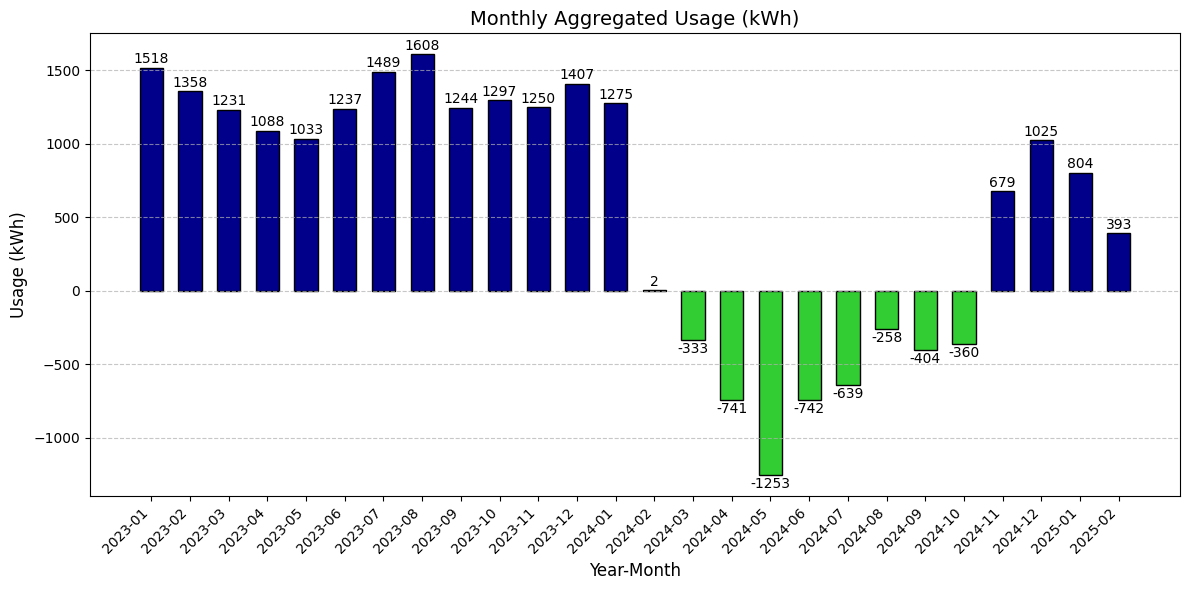

In [ ]:
# Extract year and month from the 'DATE' column
electric_agg['YearMonth'] = electric_agg['DATE'].dt.to_period('M')

# Group by 'YearMonth' and aggregate the sum for 'USAGE_(kWh)'
monthly_agg = electric_agg.groupby('YearMonth')['USAGE_(kWh)'].sum()

# Reset index for better readability
monthly_agg = monthly_agg.reset_index()

# Create a bar chart with conditional coloring
plt.figure(figsize=(12, 6))

# Define colors based on positive or negative values
colors = ['darkblue' if value >= 0 else 'limegreen' for value in monthly_agg['USAGE_(kWh)']]

bars = plt.bar(
    monthly_agg['YearMonth'].astype(str),
    monthly_agg['USAGE_(kWh)'],
    width=0.6,
    color=colors,
    edgecolor='black'
)

# Add data labels on the outside end of each bar
for bar in bars:
    height = bar.get_height()
    # Adjust label position based on whether the bar is positive or negative
    label_position = height + (10 if height > 0 else -15)
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Horizontal position
        label_position,  # Vertical position
        f'{int(round(height))}',  # Label text without decimals
        ha='center', va='bottom' if height > 0 else 'top', fontsize=10
    )

# Add labels and title
plt.title('Monthly Aggregated Usage (kWh)', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Usage (kWh)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()


##Look at cost info to compute cost_per_kwh

In [ ]:
electric_agg.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18622 entries, 0 to 18621
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DATE             18622 non-null  datetime64[ns]
 1   hour             18622 non-null  int64         
 2   last_day_month   18622 non-null  datetime64[ns]
 3   USAGE_(kWh)      18622 non-null  float64       
 4   COST             18622 non-null  float64       
 5   ESTIMATED_USAGE  18622 non-null  float64       
 6   date_timestamp   18622 non-null  datetime64[ns]
 7   YearMonth        18622 non-null  period[M]     
dtypes: datetime64[ns](3), float64(3), int64(1), period[M](1)
memory usage: 1.1 MB


In [ ]:
# Define the solar billing start date (Net Metering Start Date)
solar_start_date = pd.Timestamp('2024-01-08')

# Step 1: Compute Unaltered Cost per kWh (Raw Calculation)
electric_agg['unaltered_cost_per_kWh'] = np.where(
    electric_agg['USAGE_(kWh)'] != 0,
    electric_agg['COST'] / electric_agg['USAGE_(kWh)'],
    np.nan
)

# Step 2: Compute cost_per_kWh with prior working logic (Only After Solar Start Date)
electric_agg['cost_per_kWh'] = np.where(
    electric_agg['date_timestamp'] < solar_start_date,
    np.abs(electric_agg['unaltered_cost_per_kWh']),  # Always positive before solar start
    np.where(
        (electric_agg['USAGE_(kWh)'] > 0) & (electric_agg['COST'] < 0),
        0,  # Prevent negative costs on positive usage
        np.abs(electric_agg['unaltered_cost_per_kWh'])  # Always positive after solar start
    )
)

# Step 3: Cap Outliers Before Smoothing (Only After Solar Start)
cap_value = electric_agg.loc[electric_agg['date_timestamp'] >= solar_start_date, 'cost_per_kWh'].quantile(0.85)
electric_agg['cost_per_kWh'] = np.where(
    (electric_agg['date_timestamp'] >= solar_start_date) & (electric_agg['cost_per_kWh'] > cap_value),
    cap_value,  # Cap to the 85th percentile
    electric_agg['cost_per_kWh']
)

# Step 4: Apply Adaptive Smoothing After Capping
electric_agg['cost_per_kWh_smoothed'] = (
    electric_agg['cost_per_kWh']
    .ewm(span=5, adjust=False)
    .mean()
)

# Step 5: Final cost_per_kWh_final (Always Positive)
# Pre-Solar Start: Keep smoothed or unaltered positive value
# Post-Solar Start: Use smoothed result if original is zero, else enforce positive value
electric_agg['cost_per_kWh_final'] = np.where(
    electric_agg['date_timestamp'] < solar_start_date,
    np.abs(electric_agg['unaltered_cost_per_kWh']),  # Enforce positive pre-solar
    np.where(
        electric_agg['cost_per_kWh'] == 0,  # Use smoothed result if original is zero
        np.abs(electric_agg['cost_per_kWh_smoothed']),  # Enforce positive smoothing
        np.abs(electric_agg['cost_per_kWh'])  # Otherwise, enforce positive original
    )
)


In [ ]:
# Calculate descriptive statistics for cost_per_kWh and Net_Cost_per_kWh
descriptives = electric_agg['cost_per_kWh_final'].describe()

# Display the results
print(descriptives)

count    18615.000000
mean         0.135673
std          0.057435
min          0.000000
25%          0.119403
50%          0.133929
75%          0.149701
max          1.246575
Name: cost_per_kWh_final, dtype: float64


In [ ]:

### 📌 STEP 5: Verify Results ###
# Define the time range for inspection
start_datetime = pd.Timestamp('2024-05-26 08:00:00')
end_datetime = pd.Timestamp('2024-05-26 17:00:00')

# Filter and display rows within the specified time range
result_rows = electric_agg[
    (electric_agg['date_timestamp'] >= start_datetime) &
    (electric_agg['date_timestamp'] <= end_datetime)
][[
    'date_timestamp', 'USAGE_(kWh)', 'COST', 'unaltered_cost_per_kWh',
    'cost_per_kWh', 'cost_per_kWh_smoothed', 'cost_per_kWh_final'
]]

result_rows

date_timestamp  USAGE_(kWh)  COST  unaltered_cost_per_kWh  \
12270 2024-05-26 08:00:00        -0.11  0.16               -1.454545   
12271 2024-05-26 09:00:00         0.99  0.18                0.181818   
12272 2024-05-26 10:00:00         1.16  0.17                0.146552   
12273 2024-05-26 11:00:00         1.07  0.16                0.149533   
12274 2024-05-26 12:00:00         1.04 -0.03               -0.028846   
12275 2024-05-26 13:00:00        -0.15 -0.42                2.800000   
12276 2024-05-26 14:00:00        -2.66 -0.29                0.109023   
12277 2024-05-26 15:00:00        -1.92 -0.21                0.109375   
12278 2024-05-26 16:00:00        -1.37  0.00               -0.000000   
12279 2024-05-26 17:00:00        -0.01  0.52              -52.000000   

       cost_per_kWh  cost_per_kWh_smoothed  cost_per_kWh_final  
12270      0.166667               0.110723            0.166667  
12271      0.166667               0.129371            0.166667  
12272      0.146552               0.135098            0.146552  
12273      0.149533               0.139909            0.149533  
12274      0.000000               0.093273            0.093273  
12275      0.166667               0.117737            0.166667  
12276      0.109023               0.114833            0.109023  
12277      0.109375               0.113013            0.109375  
12278      0.000000               0.075342            0.075342  
12279      0.166667               0.105784            0.166667

In [ ]:

### 📌 STEP 5: Verify Results ###
# Define the time range for inspection
start_datetime = pd.Timestamp('2024-07-26 08:00:00')
end_datetime = pd.Timestamp('2024-07-26 17:00:00')

# Filter and display rows within the specified time range
result_rows = electric_agg[
    (electric_agg['date_timestamp'] >= start_datetime) &
    (electric_agg['date_timestamp'] <= end_datetime)
][[
    'date_timestamp', 'USAGE_(kWh)', 'COST', 'unaltered_cost_per_kWh',
    'cost_per_kWh', 'cost_per_kWh_smoothed', 'cost_per_kWh_final'
]]

result_rows

date_timestamp  USAGE_(kWh)  COST  unaltered_cost_per_kWh  \
13734 2024-07-26 08:00:00        -7.13 -1.14                0.159888   
13735 2024-07-26 09:00:00        -8.40 -1.36                0.161905   
13736 2024-07-26 10:00:00       -10.10 -1.43                0.141584   
13737 2024-07-26 11:00:00       -10.56 -1.33                0.125947   
13738 2024-07-26 12:00:00        -9.83 -0.54                0.054934   
13739 2024-07-26 13:00:00        -4.01  0.21               -0.052369   
13740 2024-07-26 14:00:00         1.56  0.56                0.358974   
13741 2024-07-26 15:00:00         4.15  0.14                0.033735   
13742 2024-07-26 16:00:00         1.01 -0.02               -0.019802   
13743 2024-07-26 17:00:00        -0.15  0.02               -0.133333   

       cost_per_kWh  cost_per_kWh_smoothed  cost_per_kWh_final  
13734      0.159888               0.141318            0.159888  
13735      0.161905               0.148180            0.161905  
13736      0.141584               0.145981            0.141584  
13737      0.125947               0.139303            0.125947  
13738      0.054934               0.111180            0.054934  
13739      0.052369               0.091576            0.052369  
13740      0.166667               0.116607            0.166667  
13741      0.033735               0.088983            0.033735  
13742      0.000000               0.059322            0.059322  
13743      0.133333               0.083992            0.133333

In [ ]:
# Step 1: Rename the original cost_per_kWh column to Net_Cost_per_kWh
electric_agg.rename(columns={'unaltered_cost_per_kWh': 'Net_Cost_per_kWh'}, inplace=True)

# Step 2: Replace cost_per_kWh with cost_per_kWh_final
electric_agg['cost_per_kWh'] = electric_agg['cost_per_kWh_final']

# Step 3: Drop the normalized and improved versions for clarity
electric_agg.drop(columns=['cost_per_kWh_smoothed', 'cost_per_kWh_final', 'unaltered_cost_per_kWh'], inplace=True, errors='ignore')

# Step 4: Verify the updates
print("Updated electric_agg DataFrame:")
print(electric_agg[['date_timestamp', 'USAGE_(kWh)', 'COST', 'cost_per_kWh', 'Net_Cost_per_kWh']].tail())


Updated electric_agg DataFrame:
           date_timestamp  USAGE_(kWh)  COST  cost_per_kWh  Net_Cost_per_kWh
18617 2025-02-14 19:00:00         3.28  0.47      0.143293          0.143293
18618 2025-02-14 20:00:00         2.55  0.36      0.141176          0.141176
18619 2025-02-14 21:00:00         1.96  0.28      0.142857          0.142857
18620 2025-02-14 22:00:00         1.38  0.19      0.137681          0.137681
18621 2025-02-14 23:00:00         0.93  0.13      0.139785          0.139785


In [ ]:
electric_agg.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18622 entries, 0 to 18621
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              18622 non-null  datetime64[ns]
 1   hour              18622 non-null  int64         
 2   last_day_month    18622 non-null  datetime64[ns]
 3   USAGE_(kWh)       18622 non-null  float64       
 4   COST              18622 non-null  float64       
 5   ESTIMATED_USAGE   18622 non-null  float64       
 6   date_timestamp    18622 non-null  datetime64[ns]
 7   YearMonth         18622 non-null  period[M]     
 8   Net_Cost_per_kWh  18615 non-null  float64       
 9   cost_per_kWh      18615 non-null  float64       
dtypes: datetime64[ns](3), float64(5), int64(1), period[M](1)
memory usage: 1.4 MB


In [ ]:
# Calculate descriptive statistics for cost_per_kWh and Net_Cost_per_kWh
descriptives = electric_agg[['cost_per_kWh', 'Net_Cost_per_kWh']].describe()

# Display the results
print(descriptives)

       cost_per_kWh  Net_Cost_per_kWh
count  18615.000000      18615.000000
mean       0.135673          0.133492
std        0.057435          0.902204
min        0.000000        -52.000000
25%        0.119403          0.118812
50%        0.133929          0.133333
75%        0.149701          0.149449
max        1.246575         77.000000


In [ ]:
# Filter rows where cost_per_kWh is greater than 1
high_cost_rows = electric_agg[electric_agg['cost_per_kWh'] > .5]

# Return the dates and the corresponding rows
high_cost_dates = high_cost_rows[['date_timestamp', 'cost_per_kWh']]

# Display the result
print(high_cost_dates)


          date_timestamp  cost_per_kWh
1976 2023-03-24 09:00:00      0.510417
1986 2023-03-24 19:00:00      0.717241
2041 2023-03-27 02:00:00      0.553191
2083 2023-03-28 20:00:00      0.608696
2091 2023-03-29 04:00:00      0.515464
...                  ...           ...
7295 2023-11-01 00:00:00      0.551724
7319 2023-11-02 00:00:00      0.510638
7379 2023-11-04 12:00:00      0.546392
7438 2023-11-06 23:00:00      0.506329
7450 2023-11-07 11:00:00      0.527473

[78 rows x 2 columns]


##Visual to check reasonableness of the cost_per_kWh.

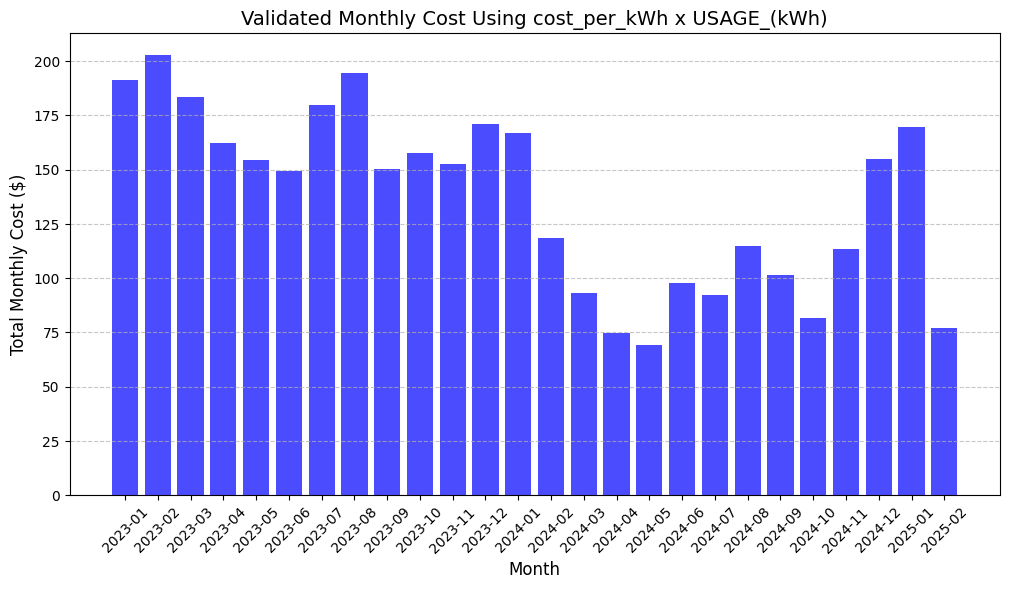

In [ ]:
# Ensure 'date_timestamp' is in datetime format
electric_agg['date_timestamp'] = pd.to_datetime(electric_agg['date_timestamp'])

# Filter out rows with negative USAGE or cost_per_kWh
valid_data = electric_agg.loc[
    (electric_agg['USAGE_(kWh)'] > 0) & (electric_agg['cost_per_kWh'] > 0)
].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Extract year and month for grouping
valid_data['Year-Month'] = valid_data['date_timestamp'].dt.to_period('M')

# Calculate total monthly cost using cost_per_kWh
monthly_cost_valid = valid_data.groupby('Year-Month', as_index=False).apply(
    lambda x: pd.Series({'Total_Cost': (x['cost_per_kWh'] * x['USAGE_(kWh)']).sum()}),
    include_groups=False  # Exclude grouping columns during the operation
)

# Convert 'Year-Month' to string for plotting
monthly_cost_valid['Year-Month'] = monthly_cost_valid['Year-Month'].astype(str)

# Plot the monthly cost
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(monthly_cost_valid['Year-Month'], monthly_cost_valid['Total_Cost'], color='blue', alpha=0.7)

# Formatting
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Monthly Cost ($)', fontsize=12)
plt.title('Validated Monthly Cost Using cost_per_kWh x USAGE_(kWh)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


##Visual to check the electric usage data

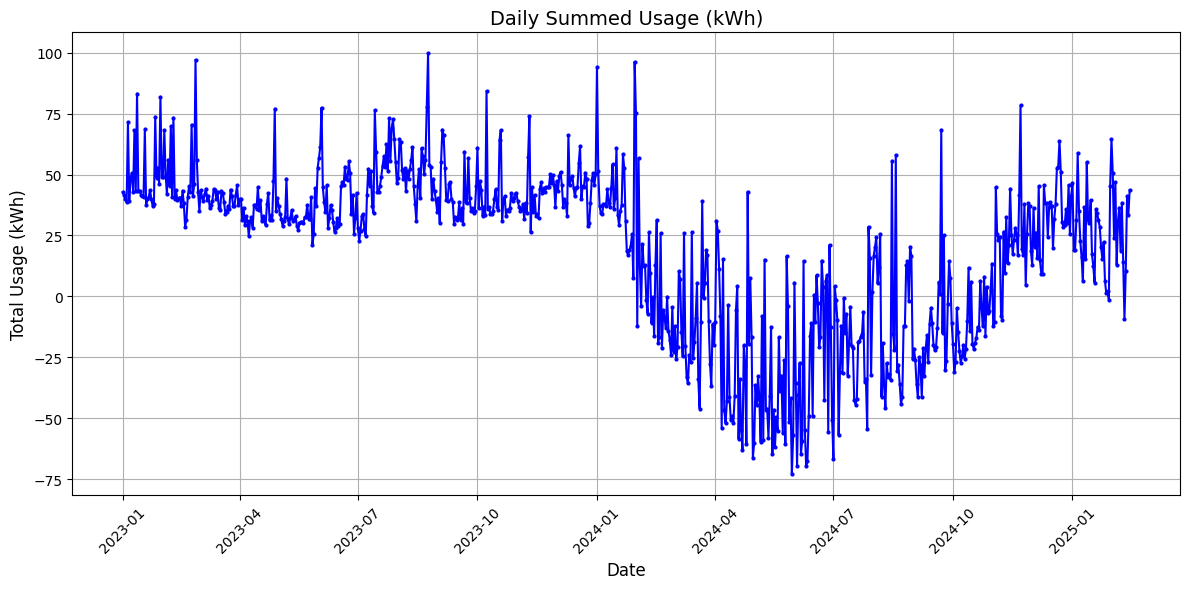

In [ ]:
# Ensure 'DATE' is in datetime format
electric_agg['DATE'] = pd.to_datetime(electric_agg['DATE'])

# Step 1: Resample the data by day and sum the 'USAGE_(kWh)'
daily_usage = electric_agg.resample('D', on='DATE')['USAGE_(kWh)'].sum()

# Step 2: Plot the daily summed usage
plt.figure(figsize=(12, 6))
plt.plot(daily_usage.index, daily_usage.values, marker='o', linestyle='-', color='b', markersize=2)

# Adding titles and labels
plt.title('Daily Summed Usage (kWh)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Usage (kWh)', fontsize=12)

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###The dip in the electric data is because it is has switched to net usage (so it is discounted for the solar production) starting in 1/1/2024). Need to calculate the consumption / total usage by taking the net usage and adding the production.

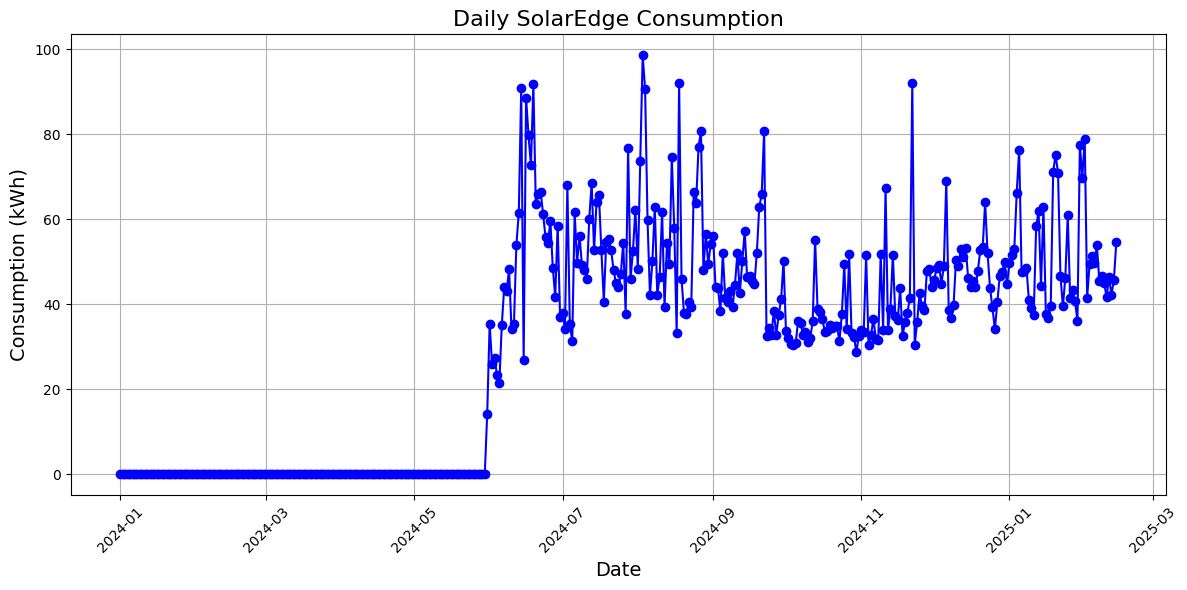

In [ ]:
#Look at the Solar Edge Consumption data.
# Ensure 'date' is in datetime format
solaredge_process['date'] = pd.to_datetime(solaredge_process['date'])

# Filter for meter_type 'Consumption'
solaredge_consumption = solaredge_process[solaredge_process['meter_type'] == 'Consumption']

# Aggregate by date and sum the values
daily_consumption = (
    solaredge_consumption.groupby(solaredge_consumption['date'].dt.date)['value']
    .sum()
    .reset_index()
    .rename(columns={'date': 'DATE', 'value': 'Daily_Consumption'})
)

# Convert 'DATE' back to datetime for plotting
daily_consumption['DATE'] = pd.to_datetime(daily_consumption['DATE'])

# Plot the daily consumption
plt.figure(figsize=(12, 6))
plt.plot(daily_consumption['DATE'], daily_consumption['Daily_Consumption'], marker='o', linestyle='-', color='blue')

# Add titles and labels
plt.title('Daily SolarEdge Consumption', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Consumption (kWh)', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


###Create a solaredge consumption and production dataframe

In [ ]:
# Ensure 'date' column in solaredge_process is in datetime format
solaredge_process['date'] = pd.to_datetime(solaredge_process['date'])

# Extract the hour from 'date' in solaredge_process
solaredge_process['hour'] = solaredge_process['date'].dt.hour

# Pivot the DataFrame to create separate columns for 'Consumption', 'Production', 'Purchased', and 'FeedIn'
solaredge_pivoted = solaredge_process.pivot_table(
    index=['date', 'hour'],
    columns='meter_type',
    values='value',
    aggfunc='sum'  # Ensure values are aggregated in case of duplicates
).reset_index()

# Rename columns for clarity
solaredge_pivoted.rename(
    columns={
        'date': 'DATE',
        'Consumption': 'Consumption',
        'Production': 'Production',
        'Purchased': 'Purchased',
        'FeedIn': 'FeedIn'
    },
    inplace=True
)

# Remove any unnecessary columns
solaredge_final = solaredge_pivoted[['DATE', 'hour', 'Consumption', 'Production', 'Purchased', 'FeedIn']]

# Debug: Inspect the prepared solaredge_final DataFrame
print("Prepared SolarEdge Final DataFrame:")
print(solaredge_final.head(20))

# Ensure no duplicates (optional sanity check)
duplicates = solaredge_final.duplicated(subset=['DATE', 'hour'], keep=False)
if duplicates.any():
    print("Duplicates in solaredge_final:")
    print(solaredge_final[duplicates])
else:
    print("No duplicates found in solaredge_final.")


Prepared SolarEdge Final DataFrame:
meter_type                DATE  hour  Consumption  Production  Purchased  \
0          2024-01-01 00:00:00     0          0.0         0.0        0.0   
1          2024-01-01 01:00:00     1          0.0         0.0        0.0   
2          2024-01-01 02:00:00     2          0.0         0.0        0.0   
3          2024-01-01 03:00:00     3          0.0         0.0        0.0   
4          2024-01-01 04:00:00     4          0.0         0.0        0.0   
5          2024-01-01 05:00:00     5          0.0         0.0        0.0   
6          2024-01-01 06:00:00     6          0.0         0.0        0.0   
7          2024-01-01 07:00:00     7          0.0         0.0        0.0   
8          2024-01-01 08:00:00     8          0.0         0.0        0.0   
9          2024-01-01 09:00:00     9          0.0         0.0        0.0   
10         2024-01-01 10:00:00    10          0.0         0.0        0.0   
11         2024-01-01 11:00:00    11          0.0   

In [ ]:
# Ensure solaredge_final is a copy, not a view
solaredge_final = solaredge_final.copy()
# Add the Net_Usage_SolarEdge column using .loc
solaredge_final.loc[:, 'Net_Usage_SolarEdge'] = solaredge_final['Purchased'] - solaredge_final['FeedIn']


In [ ]:
solaredge_final.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9864 entries, 0 to 9863
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE                 9864 non-null   datetime64[ns]
 1   hour                 9864 non-null   int32         
 2   Consumption          9864 non-null   float64       
 3   Production           9864 non-null   float64       
 4   Purchased            9864 non-null   float64       
 5   FeedIn               9864 non-null   float64       
 6   Net_Usage_SolarEdge  9864 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int32(1)
memory usage: 501.0 KB


In [ ]:
duplicates_solaredge = solaredge_final[solaredge_final.duplicated(subset=['DATE', 'hour'], keep=False)]

if not duplicates_solaredge.empty:
    print("Duplicates found in solaredge_final:")
    print(duplicates_solaredge)
else:
    print("No duplicates found in solaredge_final.")


No duplicates found in solaredge_final.


In [ ]:
#Production data starts at 9am on 1/8/2024
# Filter solaredge_final for January 2024
january_data = solaredge_final[
    (solaredge_final['DATE'] >= pd.Timestamp('2024-01-01')) &
    (solaredge_final['DATE'] <= pd.Timestamp('2024-01-31'))
]

# Print the filtered DataFrame
print("SolarEdge Data for January 2024:")
january_data


SolarEdge Data for January 2024:


meter_type                DATE  hour  Consumption  Production  Purchased  \
0          2024-01-01 00:00:00     0          0.0         0.0        0.0   
1          2024-01-01 01:00:00     1          0.0         0.0        0.0   
2          2024-01-01 02:00:00     2          0.0         0.0        0.0   
3          2024-01-01 03:00:00     3          0.0         0.0        0.0   
4          2024-01-01 04:00:00     4          0.0         0.0        0.0   
..                         ...   ...          ...         ...        ...   
716        2024-01-30 20:00:00    20          0.0         0.0        0.0   
717        2024-01-30 21:00:00    21          0.0         0.0        0.0   
718        2024-01-30 22:00:00    22          0.0         0.0        0.0   
719        2024-01-30 23:00:00    23          0.0         0.0        0.0   
720        2024-01-31 00:00:00     0          0.0         0.0        0.0   

meter_type  FeedIn  Net_Usage_SolarEdge  
0              0.0                  0.0  
1              0.0                  0.0  
2              0.0                  0.0  
3              0.0                  0.0  
4              0.0                  0.0  
..             ...                  ...  
716            0.0                  0.0  
717            0.0                  0.0  
718            0.0                  0.0  
719            0.0                  0.0  
720            0.0                  0.0  

[721 rows x 7 columns]

In [ ]:
# Create the 'YearMonth' column
solaredge_final['YearMonth'] = solaredge_final['DATE'].dt.to_period('M')

# Group by YearMonth and calculate the monthly sum for the specified columns
monthly_sums2 = solaredge_final.groupby('YearMonth')[['Production','Consumption','Purchased','FeedIn', 'Net_Usage_SolarEdge']].sum()

# Reset the index for better readability
monthly_sums2 = monthly_sums2.reset_index()

# Display the resulting table
monthly_sums2


meter_type YearMonth  Production  Consumption  Purchased    FeedIn  \
0            2024-01     118.575        0.000      0.000     0.000   
1            2024-02    1162.688        0.000      0.000     0.000   
2            2024-03     822.196        0.000      0.000     0.000   
3            2024-04     887.326        0.000      0.000     0.000   
4            2024-05    1796.752       14.229      9.616    68.738   
5            2024-06    2268.325     1551.439    841.009  1722.645   
6            2024-07    2242.938     1597.729    829.423  1474.632   
7            2024-08    2039.035     1774.062   1016.954  1281.927   
8            2024-09    1799.839     1388.996    846.109  1256.952   
9            2024-10    1464.660     1099.690    715.071  1080.041   
10           2024-11     570.708     1243.224    987.901   315.385   
11           2024-12     454.805     1473.872   1237.882   218.815   
12           2025-01     819.339     1618.692   1262.182   462.829   
13           2025-02     301.931      692.396    551.863   161.398   

meter_type  Net_Usage_SolarEdge  
0                         0.000  
1                         0.000  
2                         0.000  
3                         0.000  
4                       -59.122  
5                      -881.636  
6                      -645.209  
7                      -264.973  
8                      -410.843  
9                      -364.970  
10                      672.516  
11                     1019.067  
12                      799.353  
13                      390.465

In [ ]:
electric_agg.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18622 entries, 0 to 18621
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              18622 non-null  datetime64[ns]
 1   hour              18622 non-null  int64         
 2   last_day_month    18622 non-null  datetime64[ns]
 3   USAGE_(kWh)       18622 non-null  float64       
 4   COST              18622 non-null  float64       
 5   ESTIMATED_USAGE   18622 non-null  float64       
 6   date_timestamp    18622 non-null  datetime64[ns]
 7   YearMonth         18622 non-null  period[M]     
 8   Net_Cost_per_kWh  18615 non-null  float64       
 9   cost_per_kWh      18615 non-null  float64       
dtypes: datetime64[ns](3), float64(5), int64(1), period[M](1)
memory usage: 1.4 MB


In [ ]:
duplicates_electric_agg = electric_agg[electric_agg.duplicated(subset=['DATE', 'hour'], keep=False)]

if not duplicates_solaredge.empty:
    print("Duplicates found in electric_agg:")
    print(duplicates_solaredge)
else:
    print("No duplicates found in electric_agg.")

No duplicates found in electric_agg.


###Merge Electric Agg with Solar Data to derive Net_Usage_Electric_Company and recompute USAGE_(kWh)

In [ ]:
# Merge electric_agg with solaredge_final using date_timestamp and hour
# This aligns solar and electric data based on matching date and hour values.
electric_agg_updated = pd.merge(
    electric_agg,
    solaredge_final.rename(columns={'DATE': 'date_timestamp'}),  # Align column names for the merge
    on=['date_timestamp', 'hour'],  # Specify the merge keys: date and hour
    how='left'  # Perform a left join to retain all rows from electric_agg
)

# Create the 'Net_Usage_Computed' column
# Logic:
# - If the timestamp is between 2024-01-08 09:00:00 and 2024-06-15 00:00:00, set it to 'USAGE_(kWh)' (net usage provided by the electric company)
# - If the timestamp is on or after 2024-06-15 00:00:00, calculate it as 'Purchased - FeedIn'
# - Otherwise, set it to NaN (for dates before 2024-01-08 09:00:00)
electric_agg_updated['Net_Usage_Computed'] = electric_agg_updated.apply(
    lambda row: (
        row['USAGE_(kWh)'] if pd.Timestamp('2024-01-08 09:00:00') <= row['date_timestamp'] < pd.Timestamp('2024-06-15 00:00:00') #This is done because Purchased and FeedIn data were unavailable during this timeframe
        else (row['Purchased'] - row['FeedIn'] if row['date_timestamp'] >= pd.Timestamp('2024-06-15 00:00:00') else float('nan'))
    ),
    axis=1
)

# Add the 'Net_Usage_Electric_Company' column
# This equals 'USAGE_(kWh)' if the timestamp is on or after 2024-01-08 09:00:00
electric_agg_updated['Net_Usage_Electric_Company'] = electric_agg_updated.apply(
    lambda row: row['USAGE_(kWh)'] if row['date_timestamp'] >= pd.Timestamp('2024-01-08 09:00:00') else float('nan'),
    axis=1
)

# Update the 'USAGE_(kWh)' column with the goal of making it be total usage, not net usage, based on conditions:
# - If the timestamp is before 2024-06-15 00:00:00 and 'Net_Usage_Computed' is not NaN,
#   calculate it as 'Net_Usage_Computed + Production' (which gets total usage)
# - If the timestamp is on or after 2024-06-15 00:00:00, use 'Consumption' if it is not NaN
# - Otherwise, retain the original 'USAGE_(kWh)' value
electric_agg_updated['USAGE_(kWh)'] = electric_agg_updated.apply(
    lambda row: (
        row['Net_Usage_Computed'] + row['Production'] if row['date_timestamp'] < pd.Timestamp('2024-06-15 00:00:00') and not pd.isna(row['Net_Usage_Computed']) #This is done because consumption data was unavailable durint thid timeframe
        else (row['Consumption'] if row['date_timestamp'] >= pd.Timestamp('2024-06-15 00:00:00') and not pd.isna(row['Consumption'])
              else row['USAGE_(kWh)'])
    ),
    axis=1
)

# Drop unnecessary columns 'YearMonth_x' and 'YearMonth_y'
# This ensures a clean dataframe without duplicate or unneeded columns.
electric_agg_updated = electric_agg_updated.drop(columns=['YearMonth_x', 'YearMonth_y'], errors='ignore')

# Debug: Verify the updated DataFrame
# Display the first 50 rows of the updated DataFrame where the date is on or after 2024-06-15
print("Updated Merged DataFrame:")
print(electric_agg_updated.loc[electric_agg_updated['date_timestamp'] >= pd.Timestamp('2024-06-15'),
                               ['date_timestamp', 'hour', 'USAGE_(kWh)', 'Net_Usage_Computed', 'Net_Usage_Electric_Company',
                                'Consumption', 'Production', 'Purchased', 'FeedIn', 'Net_Usage_SolarEdge']].head(50))


Updated Merged DataFrame:
           date_timestamp  hour  USAGE_(kWh)  Net_Usage_Computed  \
12742 2024-06-15 00:00:00     0        0.986               0.986   
12743 2024-06-15 01:00:00     1        1.002               1.002   
12744 2024-06-15 02:00:00     2        1.042               1.042   
12745 2024-06-15 03:00:00     3        1.032               1.032   
12746 2024-06-15 04:00:00     4        0.930               0.930   
12747 2024-06-15 05:00:00     5        0.963               0.578   
12748 2024-06-15 06:00:00     6        0.964              -1.497   
12749 2024-06-15 07:00:00     7        1.002              -5.486   
12750 2024-06-15 08:00:00     8        1.013              -2.569   
12751 2024-06-15 09:00:00     9        0.975              -3.958   
12752 2024-06-15 10:00:00    10        1.010              -9.916   
12753 2024-06-15 11:00:00    11        0.919              -7.434   
12754 2024-06-15 12:00:00    12        1.050              -7.796   
12755 2024-06-15 13:00

In [ ]:
electric_agg_updated.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18622 entries, 0 to 18621
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DATE                        18622 non-null  datetime64[ns]
 1   hour                        18622 non-null  int64         
 2   last_day_month              18622 non-null  datetime64[ns]
 3   USAGE_(kWh)                 18622 non-null  float64       
 4   COST                        18622 non-null  float64       
 5   ESTIMATED_USAGE             18622 non-null  float64       
 6   date_timestamp              18622 non-null  datetime64[ns]
 7   Net_Cost_per_kWh            18615 non-null  float64       
 8   cost_per_kWh                18615 non-null  float64       
 9   Consumption                 9863 non-null   float64       
 10  Production                  9863 non-null   float64       
 11  Purchased                   9863 non-null   float64   

In [ ]:
# Calculate descriptive statistics for cost_per_kWh and Net_Cost_per_kWh
descriptives = electric_agg_updated[['cost_per_kWh', 'Net_Cost_per_kWh']].describe()

# Display the results
print(descriptives)

       cost_per_kWh  Net_Cost_per_kWh
count  18615.000000      18615.000000
mean       0.135673          0.133492
std        0.057435          0.902204
min        0.000000        -52.000000
25%        0.119403          0.118812
50%        0.133929          0.133333
75%        0.149701          0.149449
max        1.246575         77.000000


###Validate new fields with a chart

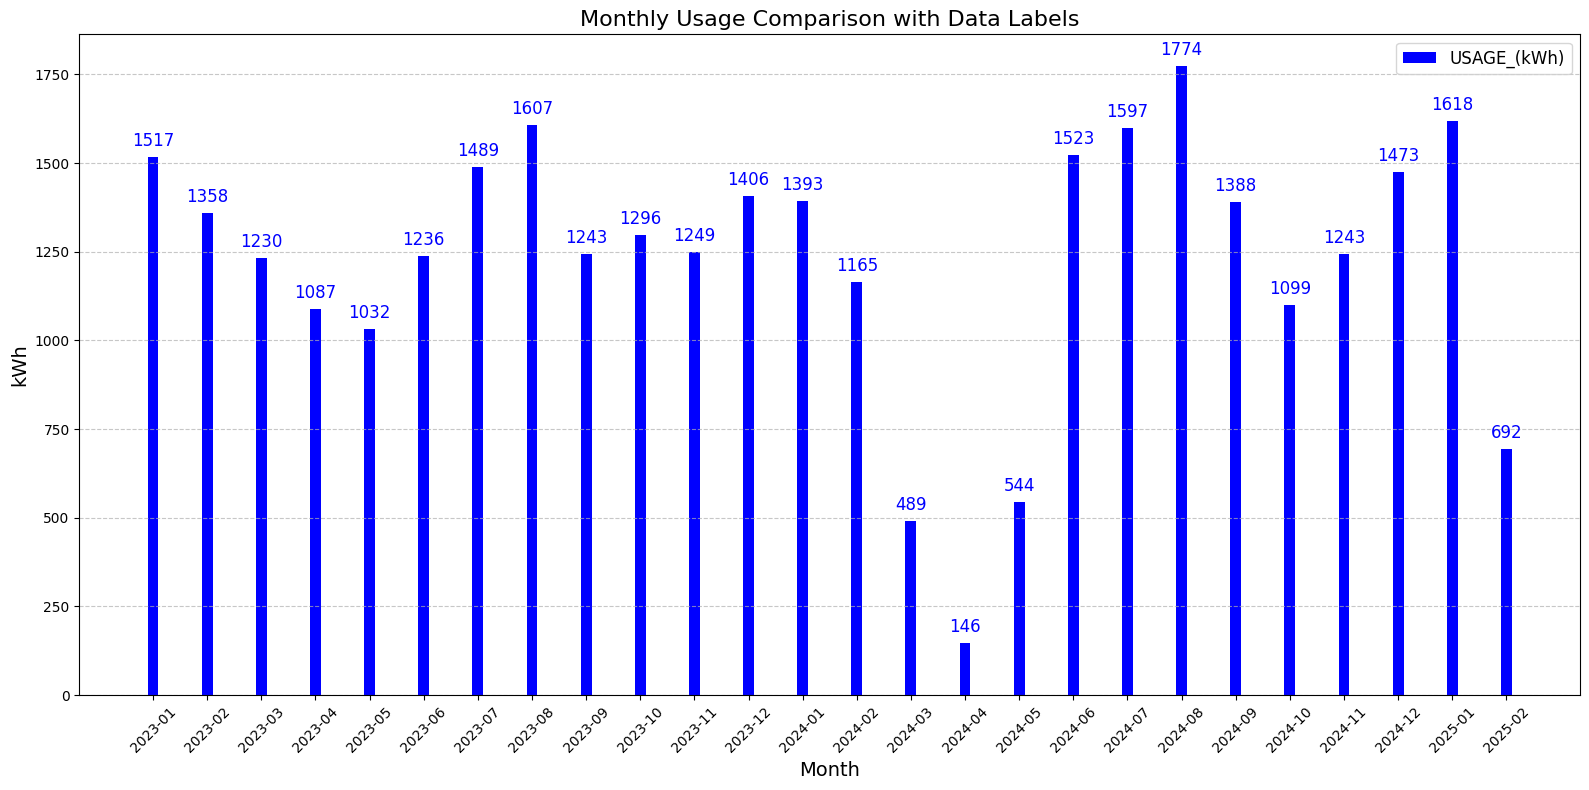

In [ ]:
# Aggregate data at the monthly level
electric_agg_updated['YearMonth'] = electric_agg_updated['date_timestamp'].dt.to_period('M')
monthly_data = electric_agg_updated.groupby('YearMonth')[['USAGE_(kWh)']].sum().reset_index()

# Convert 'YearMonth' back to datetime for plotting
monthly_data['YearMonth'] = monthly_data['YearMonth'].dt.to_timestamp()

# Define bar width and position with increased separation
bar_width = 0.5  # Wider bars
x = np.arange(len(monthly_data)) * 2.5  # Increase separation between bars

# Create the bar chart
plt.figure(figsize=(16, 8))

# Plot each dataset as a bar
bars1 = plt.bar(x, monthly_data['USAGE_(kWh)'], width=bar_width, label='USAGE_(kWh)', color='blue')

# Add data labels
for bar in bars1:
    height = bar.get_height()
    label_position = height + (20 if height > 0 else -20)  # Adjust label position for positive/negative values
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center the label horizontally
        label_position,  # Position the label just above the bar
        f"{int(height)}",  # Convert height to an integer label
        ha='center', va='bottom' if height > 0 else 'top', fontsize=12, color='blue'
    )

# Customize the chart
plt.xticks(x, monthly_data['YearMonth'].dt.strftime('%Y-%m'), rotation=45)
plt.xlabel('Month', fontsize=14)
plt.ylabel('kWh', fontsize=14)
plt.title('Monthly Usage Comparison with Data Labels', fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the chart
plt.show()


###March, April, and May 2024 have odd Usage numbers that do not make sense.  
- The numbers match what is coming from the electric company export and solar company for production
- The numbers do not match what happened with billing but most are close with the exception of March April and May 2024
- I am going to fill in 2023 numbers to populate 2025 forward and leave 2024 the same.

###Plot the net usage from the electric company and compare it to the net usage derived from solar edge.

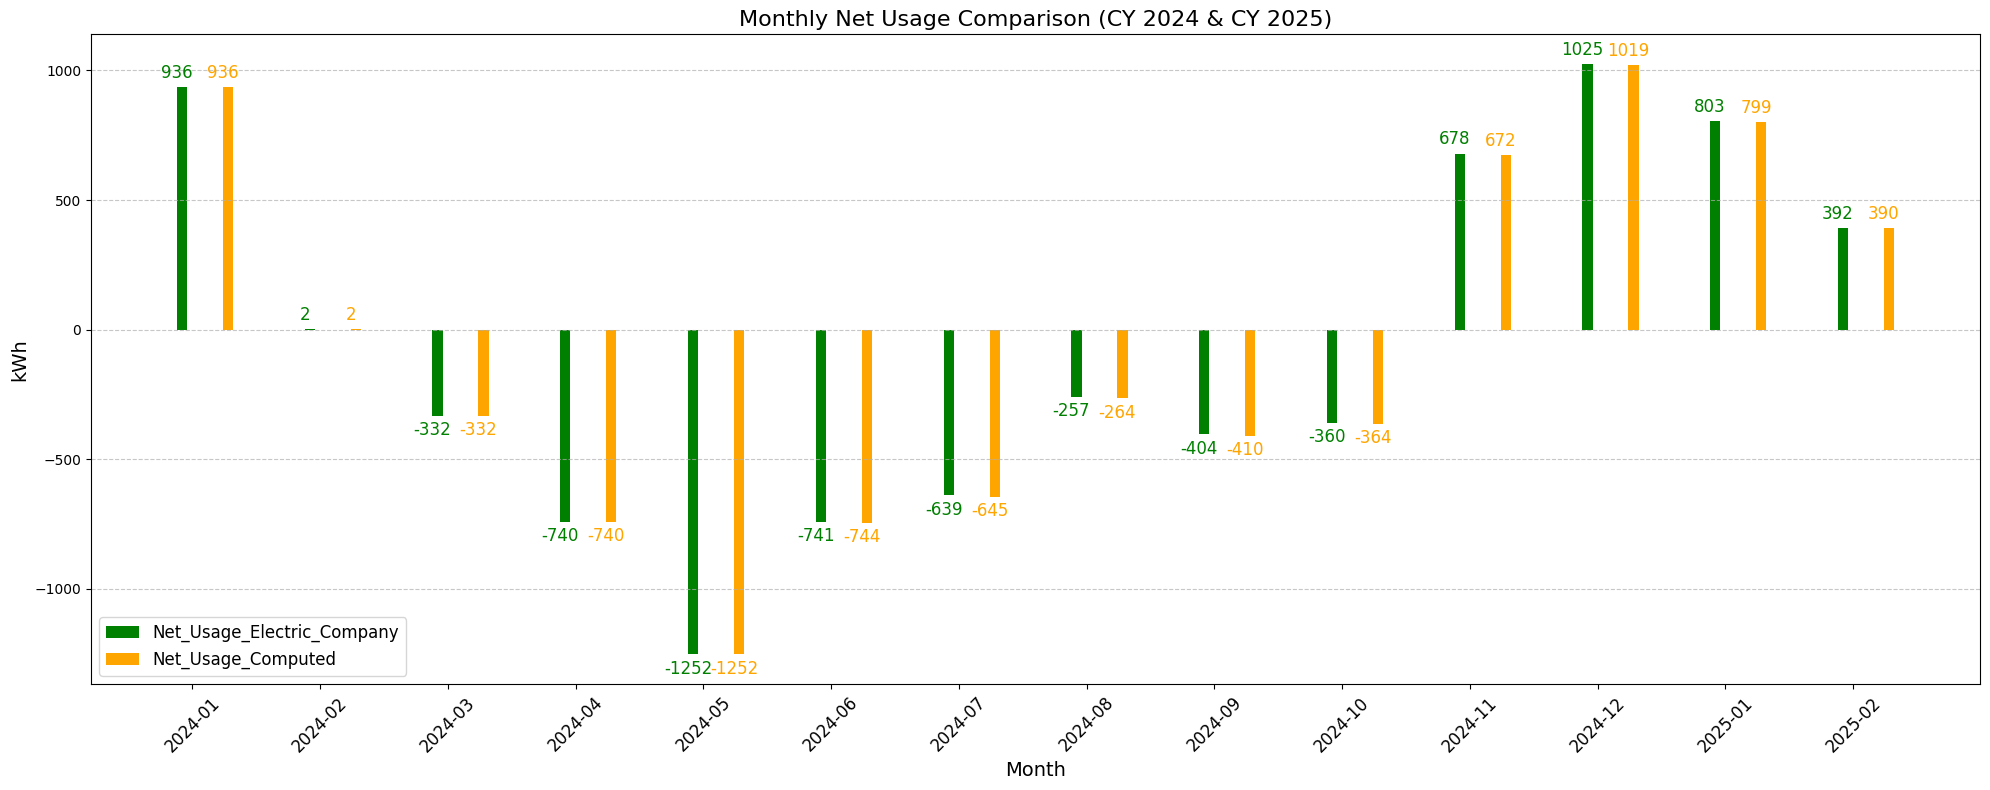

In [ ]:
# Filter data for CY 2024 and CY 2025
electric_agg_updated['YearMonth'] = electric_agg_updated['date_timestamp'].dt.to_period('M')
filtered_data = electric_agg_updated[
    electric_agg_updated['date_timestamp'] >= pd.Timestamp('2024-01-01')
].groupby('YearMonth')[['Net_Usage_Electric_Company', 'Net_Usage_Computed']].sum().reset_index()

# Convert 'YearMonth' back to datetime for plotting
filtered_data['YearMonth'] = filtered_data['YearMonth'].dt.to_timestamp()

# Define bar width and horizontal spacing
bar_width = 0.4
x = np.arange(len(filtered_data)) * 5  # Large separation between groups for readability

# Create the bar chart
plt.figure(figsize=(20, 8))

# Plot each dataset as a bar with more horizontal spacing
bars1 = plt.bar(
    x - bar_width,
    filtered_data['Net_Usage_Electric_Company'],
    width=bar_width,
    label='Net_Usage_Electric_Company',
    color='green'
)
bars2 = plt.bar(
    x + bar_width +1,
    filtered_data['Net_Usage_Computed'],
    width=bar_width,
    label='Net_Usage_Computed',
    color='orange'
)

# Add data labels near the bars with horizontal separation
for bars, color in zip([bars1, bars2], ['green', 'orange']):
    for bar in bars:
        height = bar.get_height()
        label_position = height + (20 if height > 0 else -20)  # Place labels near the bar
        plt.text(
            bar.get_x(),  # Keep labels close to the bar horizontally
            label_position,  # Adjust label placement for positive/negative values
            f"{int(height)}",  # Convert height to an integer label
            ha='center',
            va='bottom' if height > 0 else 'top',
            fontsize=12,
            color=color
        )

# Customize the chart
plt.xticks(x, filtered_data['YearMonth'].dt.strftime('%Y-%m'), rotation=45, fontsize=12)
plt.xlabel('Month', fontsize=14)
plt.ylabel('kWh', fontsize=14)
plt.title('Monthly Net Usage Comparison (CY 2024 & CY 2025)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the chart
plt.show()


In [ ]:
# Calculate descriptive statistics for cost_per_kWh and Net_Cost_per_kWh
descriptives = electric_agg_updated[['cost_per_kWh', 'Net_Cost_per_kWh']].describe()

# Display the results
print(descriptives)

       cost_per_kWh  Net_Cost_per_kWh
count  18615.000000      18615.000000
mean       0.135673          0.133492
std        0.057435          0.902204
min        0.000000        -52.000000
25%        0.119403          0.118812
50%        0.133929          0.133333
75%        0.149701          0.149449
max        1.246575         77.000000


In [ ]:
electric_agg_updated.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18622 entries, 0 to 18621
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DATE                        18622 non-null  datetime64[ns]
 1   hour                        18622 non-null  int64         
 2   last_day_month              18622 non-null  datetime64[ns]
 3   USAGE_(kWh)                 18622 non-null  float64       
 4   COST                        18622 non-null  float64       
 5   ESTIMATED_USAGE             18622 non-null  float64       
 6   date_timestamp              18622 non-null  datetime64[ns]
 7   Net_Cost_per_kWh            18615 non-null  float64       
 8   cost_per_kWh                18615 non-null  float64       
 9   Consumption                 9863 non-null   float64       
 10  Production                  9863 non-null   float64       
 11  Purchased                   9863 non-null   float64   

##These numbers don't match the electric bill.
- It is likely due to the billing month being defined differently than the calendar month
- Add a billing month analysis and replot

In [ ]:
# Create a billing month DataFrame
def create_billing_month_dataframe():
    data = {
        "Billing_Year": [
            2022, 2022, 2022, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023,
            2023, 2023, 2023, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024,
            2024, 2024, 2024
        ],
        "Billing_Year_Start": [
            "2022-04-01 00:00:00", "2022-04-01 00:00:00", "2022-04-01 00:00:00", "2023-03-29 00:00:00",
            "2023-03-29 00:00:00", "2023-03-29 00:00:00", "2023-03-29 00:00:00", "2023-03-29 00:00:00",
            "2023-03-29 00:00:00", "2023-03-29 00:00:00", "2023-03-29 00:00:00", "2023-03-29 00:00:00",
            "2023-03-29 00:00:00", "2023-03-29 00:00:00", "2023-03-29 00:00:00", "2024-04-02 00:00:00",
            "2024-04-02 00:00:00", "2024-04-02 00:00:00", "2024-04-02 00:00:00", "2024-04-02 00:00:00",
            "2024-04-02 00:00:00", "2024-04-02 00:00:00", "2024-04-02 00:00:00", "2024-04-02 00:00:00",
            "2024-04-02 00:00:00", "2024-04-02 00:00:00", "2024-04-02 00:00:00",
        ],
        "Billing_Month": [
            "January", "February", "March", "April", "May", "June", "July", "August", "September", "October",
            "November", "December", "January", "February", "March", "April", "May", "June", "July", "August",
            "September", "October", "November", "December", "January", "February", "March"
        ],
        "Billing_Month_Start": [
            "2022-12-29 00:00:00", "2023-01-30 00:00:00", "2023-02-28 00:00:00", "2023-03-29 00:00:00",
            "2023-04-27 00:00:00", "2023-05-26 00:00:00", "2023-06-27 00:00:00", "2023-07-27 00:00:00",
            "2023-08-25 00:00:00", "2023-09-26 00:00:00", "2023-10-25 00:00:00", "2023-11-27 00:00:00",
            "2023-12-28 00:00:00", "2024-01-29 00:00:00", "2024-03-05 00:00:00", "2024-04-02 00:00:00",
            "2024-05-01 00:00:00", "2024-05-31 00:00:00", "2024-07-01 00:00:00", "2024-07-31 00:00:00",
            "2024-08-29 00:00:00", "2024-09-30 00:00:00", "2024-10-29 00:00:00", "2024-11-26 00:00:00",
            "2024-12-30 00:00:00", "2025-01-29 00:00:00", "2024-03-03 00:00:00"
        ],
        "Billing_Month_End": [
            "2023-01-29 23:00:00", "2023-02-27 23:00:00", "2023-03-28 23:00:00", "2023-04-26 23:00:00",
            "2023-05-25 23:00:00", "2023-06-26 23:00:00", "2023-07-26 23:00:00", "2023-08-24 23:00:00",
            "2023-09-25 23:00:00", "2023-10-24 23:00:00", "2023-11-26 23:00:00", "2023-12-27 23:00:00",
            "2024-01-28 23:00:00", "2024-03-04 23:00:00", "2024-04-01 23:00:00", "2024-04-30 23:00:00",
            "2024-05-30 23:00:00", "2024-06-30 23:00:00", "2024-07-30 23:00:00", "2024-08-28 23:00:00",
            "2024-09-29 23:00:00", "2024-10-28 23:00:00", "2024-11-25 23:00:00", "2024-12-29 23:00:00",
            "2025-01-28 23:00:00", "2025-03-02 23:00:00", "2024-03-31 23:00:00"
        ]
    }

    # Convert columns to datetime and explicitly set the time to 00:00:00 where required
    data["Billing_Year_Start"] = pd.to_datetime(data["Billing_Year_Start"])
    data["Billing_Month_Start"] = pd.to_datetime(data["Billing_Month_Start"])
    data["Billing_Month_End"] = pd.to_datetime(data["Billing_Month_End"])  # Retain original times


    return pd.DataFrame(data)

# Create the billing month DataFrame
billing_month_df = create_billing_month_dataframe()

# Display the DataFrame
print(billing_month_df)


    Billing_Year Billing_Year_Start Billing_Month Billing_Month_Start  \
0           2022         2022-04-01       January          2022-12-29   
1           2022         2022-04-01      February          2023-01-30   
2           2022         2022-04-01         March          2023-02-28   
3           2023         2023-03-29         April          2023-03-29   
4           2023         2023-03-29           May          2023-04-27   
5           2023         2023-03-29          June          2023-05-26   
6           2023         2023-03-29          July          2023-06-27   
7           2023         2023-03-29        August          2023-07-27   
8           2023         2023-03-29     September          2023-08-25   
9           2023         2023-03-29       October          2023-09-26   
10          2023         2023-03-29      November          2023-10-25   
11          2023         2023-03-29      December          2023-11-27   
12          2023         2023-03-29       January  

##Merge billing_month_df into electric_agg_updated

In [ ]:
# Ensure the result DataFrame starts as a complete copy of electric_agg_updated
merged_df = electric_agg_updated.copy()

# Ensure billing_month_df has a 'Billing_Month' column (if it doesn't already)
if 'Billing_Month' not in billing_month_df.columns:
    billing_month_df['Billing_Month'] = billing_month_df['Billing_Month_Start'].dt.month_name()

# Loop through each row of billing_month_df to conditionally assign its values
for _, row in billing_month_df.iterrows():
    # Create a condition to check if date_timestamp falls within the billing range
    condition = (merged_df['date_timestamp'] >= row['Billing_Month_Start']) & \
                (merged_df['date_timestamp'] <= row['Billing_Month_End'])

    # Assign the values from billing_month_df to matching rows in merged_df
    merged_df.loc[condition, ['Billing_Year', 'Billing_Year_Start',
                              'Billing_Month_Start', 'Billing_Month_End', 'Billing_Month']] = \
        row[['Billing_Year', 'Billing_Year_Start',
             'Billing_Month_Start', 'Billing_Month_End', 'Billing_Month']].values

# Perform a left join to add the new billing information to electric_agg_updated
electric_agg_updated = pd.merge(
    electric_agg_updated,
    merged_df[['date_timestamp', 'Billing_Year', 'Billing_Year_Start',
               'Billing_Month_End', 'Billing_Month']],
    on='date_timestamp',
    how='left'
)
electric_agg_updated

DATE  hour last_day_month  USAGE_(kWh)  COST  ESTIMATED_USAGE  \
0     2023-01-01     0     2023-01-31        1.460  0.00              0.0   
1     2023-01-01     1     2023-01-31        1.520  0.00              0.0   
2     2023-01-01     2     2023-01-31        1.140  0.00              0.0   
3     2023-01-01     3     2023-01-31        1.640  0.00              0.0   
4     2023-01-01     4     2023-01-31        2.740  0.00              0.0   
...          ...   ...            ...          ...   ...              ...   
18617 2025-02-14    19     2025-02-28        3.117  0.47              0.0   
18618 2025-02-14    20     2025-02-28        2.657  0.36              0.0   
18619 2025-02-14    21     2025-02-28        1.982  0.28              0.0   
18620 2025-02-14    22     2025-02-28        1.377  0.19              0.0   
18621 2025-02-14    23     2025-02-28        0.925  0.13              0.0   

           date_timestamp  Net_Cost_per_kWh  cost_per_kWh  Consumption  ...  \
0     2023-01-01 00:00:00          0.000000      0.000000          NaN  ...   
1     2023-01-01 01:00:00          0.000000      0.000000          NaN  ...   
2     2023-01-01 02:00:00          0.000000      0.000000          NaN  ...   
3     2023-01-01 03:00:00          0.000000      0.000000          NaN  ...   
4     2023-01-01 04:00:00          0.000000      0.000000          NaN  ...   
...                   ...               ...           ...          ...  ...   
18617 2025-02-14 19:00:00          0.143293      0.143293        3.117  ...   
18618 2025-02-14 20:00:00          0.141176      0.141176        2.657  ...   
18619 2025-02-14 21:00:00          0.142857      0.142857        1.982  ...   
18620 2025-02-14 22:00:00          0.137681      0.137681        1.377  ...   
18621 2025-02-14 23:00:00          0.139785      0.139785        0.925  ...   

       Purchased  FeedIn  Net_Usage_SolarEdge  Net_Usage_Computed  \
0            NaN     NaN                  NaN                 NaN   
1            NaN     NaN                  NaN                 NaN   
2            NaN     NaN                  NaN                 NaN   
3            NaN     NaN                  NaN                 NaN   
4            NaN     NaN                  NaN                 NaN   
...          ...     ...                  ...                 ...   
18617      3.117     0.0                3.117               3.117   
18618      2.657     0.0                2.657               2.657   
18619      1.982     0.0                1.982               1.982   
18620      1.377     0.0                1.377               1.377   
18621      0.925     0.0                0.925               0.925   

       Net_Usage_Electric_Company  YearMonth Billing_Year  Billing_Year_Start  \
0                             NaN    2023-01       2022.0          2022-04-01   
1                             NaN    2023-01       2022.0          2022-04-01   
2                             NaN    2023-01       2022.0          2022-04-01   
3                             NaN    2023-01       2022.0          2022-04-01   
4                             NaN    2023-01       2022.0          2022-04-01   
...                           ...        ...          ...                 ...   
18617                        3.28    2025-02       2024.0          2024-04-02   
18618                        2.55    2025-02       2024.0          2024-04-02   
18619                        1.96    2025-02       2024.0          2024-04-02   
18620                        1.38    2025-02       2024.0          2024-04-02   
18621                        0.93    2025-02       2024.0          2024-04-02   

        Billing_Month_End Billing_Month  
0     2023-01-29 23:00:00       January  
1     2023-01-29 23:00:00       January  
2     2023-01-29 23:00:00       January  
3     2023-01-29 23:00:00       January  
4     2023-01-29 23:00:00       January  
...                   ...           ...  
18617 2025-03-02 23:00:00      February  


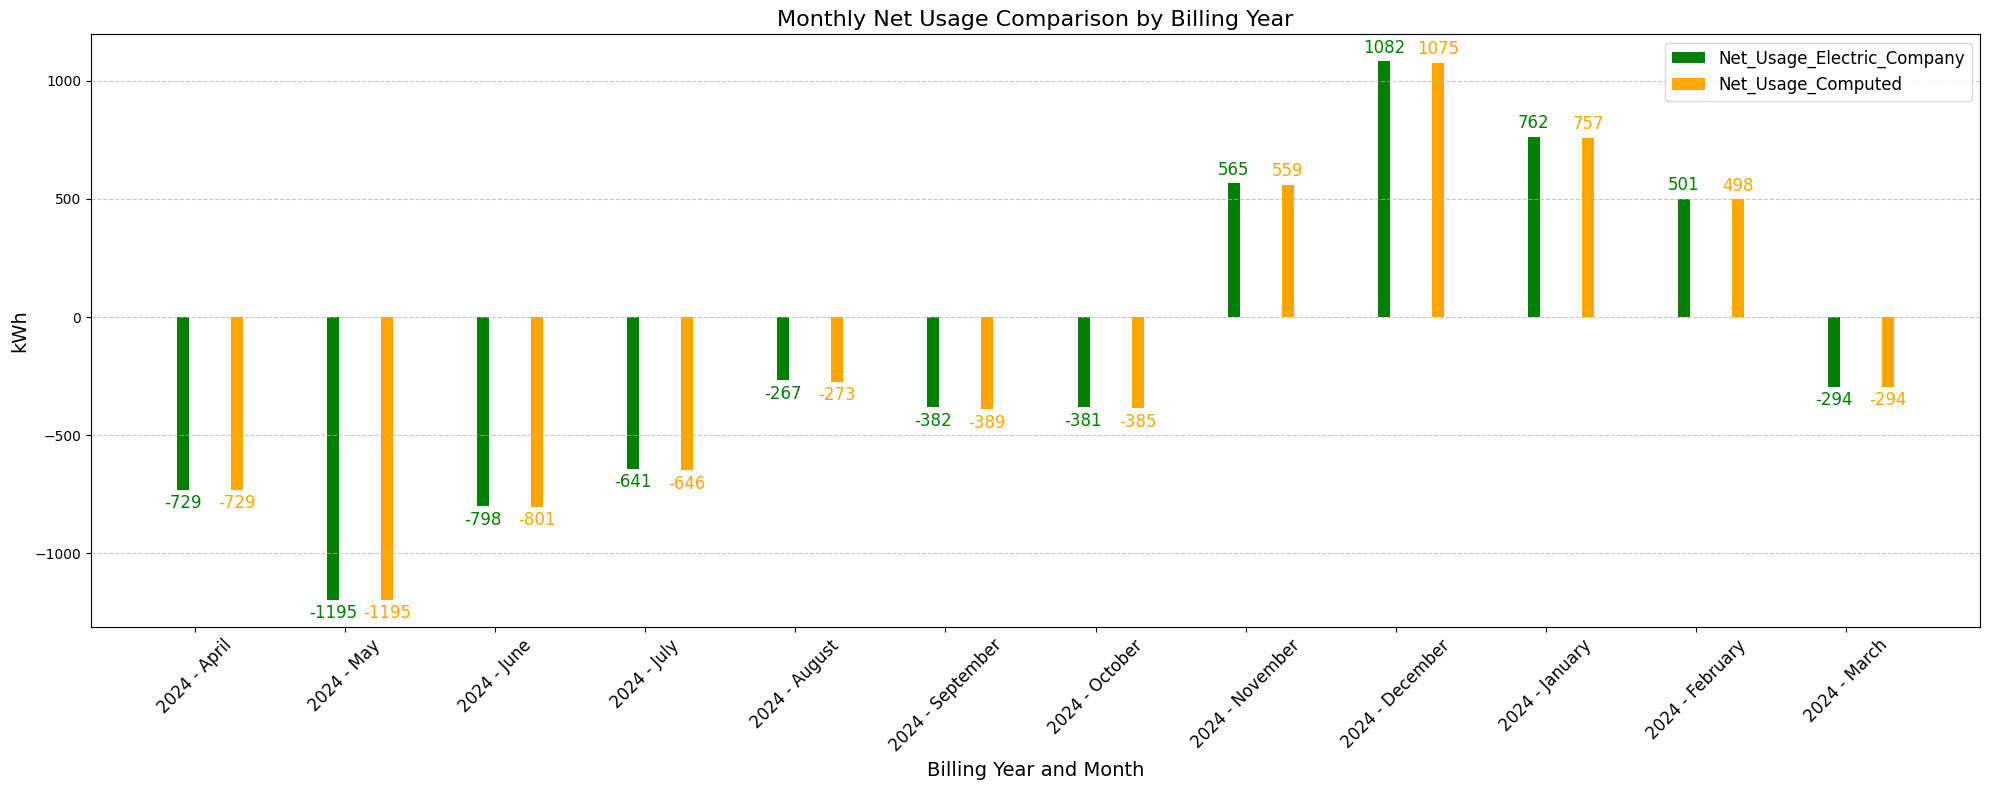

In [ ]:
def plot_billing_year_usage_comparison(electric_agg_updated):
    # Ensure 'Billing Year' is an integer
    electric_agg_updated['Billing_Year'] = electric_agg_updated['Billing_Year'].fillna(0).astype(int)

    # Filter data for Billing Years 2024 and 2025
    filtered_data = electric_agg_updated[
        electric_agg_updated['Billing_Year'].isin([2024, 2025])
    ].groupby(['Billing_Year', 'Billing_Month'])[
        ['Net_Usage_Electric_Company', 'Net_Usage_Computed']
    ].sum().reset_index()

    # Sort the data by Billing Year and Billing Month
    month_order = ["April", "May", "June", "July", "August", "September", "October", "November", "December", "January", "February", "March"]
    filtered_data['Billing_Month'] = pd.Categorical(filtered_data['Billing_Month'], categories=month_order, ordered=True)
    filtered_data = filtered_data.sort_values(['Billing_Year', 'Billing_Month']).reset_index(drop=True)

    # Define bar width and horizontal spacing
    bar_width = 0.4
    x = np.arange(len(filtered_data)) * 5  # Large separation between groups for readability

    # Create the bar chart
    plt.figure(figsize=(20, 8))

    # Plot each dataset as a bar with more horizontal spacing
    bars1 = plt.bar(
        x - bar_width,
        filtered_data['Net_Usage_Electric_Company'],
        width=bar_width,
        label='Net_Usage_Electric_Company',
        color='green'
    )
    bars2 = plt.bar(
        x + bar_width + 1,
        filtered_data['Net_Usage_Computed'],
        width=bar_width,
        label='Net_Usage_Computed',
        color='orange'
    )

    # Add data labels near the bars with horizontal separation
    for bars, color in zip([bars1, bars2], ['green', 'orange']):
        for bar in bars:
            height = bar.get_height()
            label_position = height + (20 if height > 0 else -20)  # Place labels near the bar
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # Adjust for center alignment
                label_position,  # Adjust label placement for positive/negative values
                f"{int(height)}",  # Convert height to an integer label
                ha='center',
                va='bottom' if height > 0 else 'top',
                fontsize=12,
                color=color
            )

    # Customize the chart
    plt.xticks(
        x,
        [f"{int(row['Billing_Year'])} - {row['Billing_Month']}" for _, row in filtered_data.iterrows()],
        rotation=45,
        fontsize=12
    )
    plt.xlabel('Billing Year and Month', fontsize=14)
    plt.ylabel('kWh', fontsize=14)
    plt.title('Monthly Net Usage Comparison by Billing Year', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the chart
    plt.show()

# Assuming electric_agg_updated is already defined
plot_billing_year_usage_comparison(electric_agg_updated)


In [ ]:
electric_agg_updated.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18622 entries, 0 to 18621
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DATE                        18622 non-null  datetime64[ns]
 1   hour                        18622 non-null  int64         
 2   last_day_month              18622 non-null  datetime64[ns]
 3   USAGE_(kWh)                 18622 non-null  float64       
 4   COST                        18622 non-null  float64       
 5   ESTIMATED_USAGE             18622 non-null  float64       
 6   date_timestamp              18622 non-null  datetime64[ns]
 7   Net_Cost_per_kWh            18615 non-null  float64       
 8   cost_per_kWh                18615 non-null  float64       
 9   Consumption                 9863 non-null   float64       
 10  Production                  9863 non-null   float64       
 11  Purchased                   9863 non-null   float64   

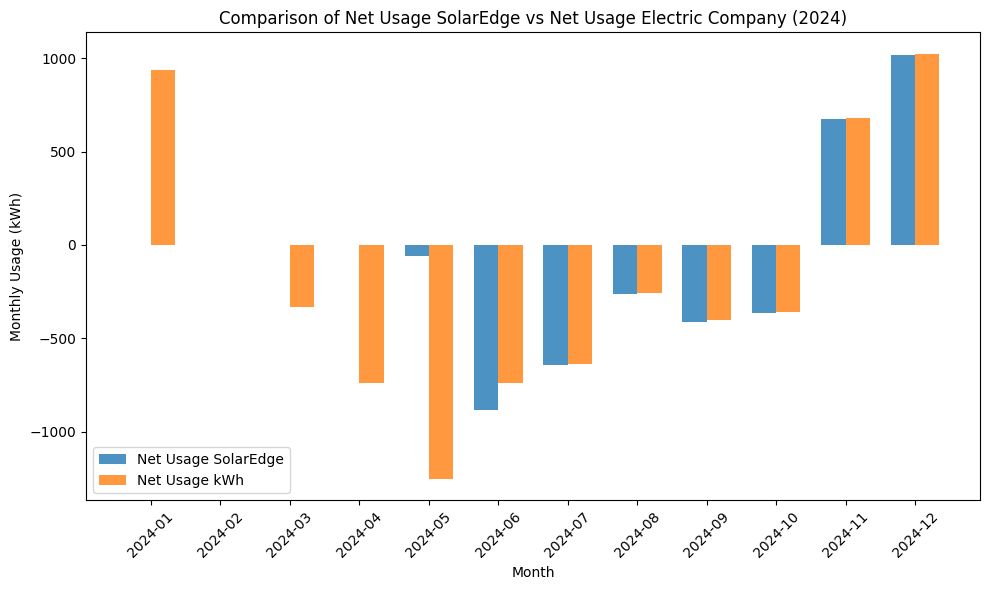

In [ ]:
# Filter data for the 2024 calendar year
data_2024 = electric_agg_updated[(electric_agg_updated['DATE'] >= '2024-01-01') & (electric_agg_updated['DATE'] <= '2024-12-31')]

# Extract year-month and aggregate the sums
monthly_data = data_2024.groupby(data_2024['DATE'].dt.to_period('M')).agg({
    'Net_Usage_SolarEdge': 'sum',
    'Net_Usage_Electric_Company': 'sum'
}).reset_index()

# Convert 'DATE' back to datetime for plotting
monthly_data['DATE'] = monthly_data['DATE'].dt.to_timestamp()

# Plot the bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(monthly_data))

# Plot Net_Usage_SolarEdge
plt.bar(x, monthly_data['Net_Usage_SolarEdge'], width=bar_width, label='Net Usage SolarEdge', alpha=0.8)

# Plot Net_Usage_kWh
plt.bar([i + bar_width for i in x], monthly_data['Net_Usage_Electric_Company'], width=bar_width, label='Net Usage kWh', alpha=0.8)

# Customize the chart
plt.xticks([i + bar_width / 2 for i in x], monthly_data['DATE'].dt.strftime('%Y-%m'), rotation=45)
plt.ylabel('Monthly Usage (kWh)')
plt.xlabel('Month')
plt.title('Comparison of Net Usage SolarEdge vs Net Usage Electric Company (2024)')
plt.legend()
plt.tight_layout()

# Display the chart
plt.show()


In [ ]:
electric_agg_updated.drop(columns=['ESTIMATED_USAGE'], errors='ignore', inplace=True)

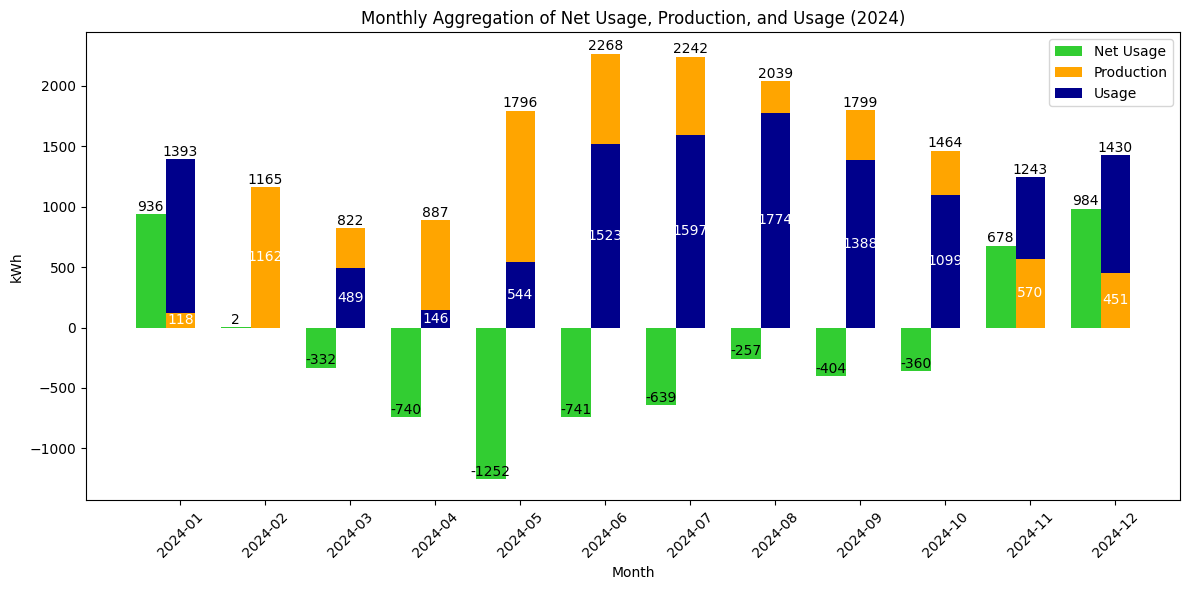

In [ ]:
# Filter data for the calendar year 2024
electric_agg_filtered = electric_agg_updated[
    (electric_agg_updated['date_timestamp'] >= '2024-01-01') &
    (electric_agg_updated['date_timestamp'] <= '2024-12-31')
]

# Aggregate monthly data for the required columns
monthly_agg = electric_agg_filtered.groupby(electric_agg_filtered['date_timestamp'].dt.to_period('M'))[
    ['Net_Usage_Electric_Company', 'Production', 'USAGE_(kWh)']
].sum()
monthly_agg.index = monthly_agg.index.to_timestamp()  # Convert PeriodIndex to datetime

# Create the bar positions
x = np.arange(len(monthly_agg))
bar_width = 0.35

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Determine the bottom and top dynamically based on the smaller and larger values
bottom_values = np.minimum(monthly_agg['Production'], monthly_agg['USAGE_(kWh)'])
top_values = np.maximum(monthly_agg['Production'], monthly_agg['USAGE_(kWh)']) - bottom_values
bottom_label = monthly_agg['Production'] <= monthly_agg['USAGE_(kWh)']

# Plot the Net Usage as a separate bar
bars1 = ax.bar(x - bar_width, monthly_agg['Net_Usage_Electric_Company'],
               width=bar_width, label='Net Usage', color='limegreen')

# Plot the stacked bars, dynamically assigning the bottom and top colors
bars2 = ax.bar(x, bottom_values,
               width=bar_width,
               color=np.where(bottom_label, 'orange', 'darkblue'),
               label='Bottom')
bars3 = ax.bar(x, top_values,
               bottom=bottom_values,
               width=bar_width,
               color=np.where(bottom_label, 'darkblue', 'orange'),
               label='Top')

# Add data labels for Net Usage
for bar in bars1:
    height = bar.get_height()
    if height != 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 2,
            f'{int(height)}',
            ha='center', va='bottom'
        )

# Add data labels for stacked bars
for bar2, bar3 in zip(bars2, bars3):
    production_height = bar2.get_height()
    usage_height = bar3.get_height() + production_height

    # Bottom label
    if production_height != 0:
        ax.text(
            bar2.get_x() + bar2.get_width() / 2,
            production_height / 2,
            f'{int(production_height)}',
            ha='center', va='center', color='white'
        )
    # Top label
    if usage_height != 0:
        ax.text(
            bar3.get_x() + bar3.get_width() / 2,
            usage_height + 2,
            f'{int(usage_height)}',
            ha='center', va='bottom'
        )

# Customize the chart
ax.set_xlabel('Month')
ax.set_ylabel('kWh')
ax.set_title('Monthly Aggregation of Net Usage, Production, and Usage (2024)')
ax.set_xticks(x)
ax.set_xticklabels(monthly_agg.index.strftime('%Y-%m'))
ax.legend(['Net Usage', 'Production', 'Usage'])

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
electric_agg_updated = electric_agg_updated.drop(columns=['Consumption', 'Production', 'FeedIn', 'Purchased', 'Net_Usage_SolarEdge', 'YearMonth'])

In [ ]:
electric_agg_updated.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18622 entries, 0 to 18621
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DATE                        18622 non-null  datetime64[ns]
 1   hour                        18622 non-null  int64         
 2   last_day_month              18622 non-null  datetime64[ns]
 3   USAGE_(kWh)                 18622 non-null  float64       
 4   COST                        18622 non-null  float64       
 5   date_timestamp              18622 non-null  datetime64[ns]
 6   Net_Cost_per_kWh            18615 non-null  float64       
 7   cost_per_kWh                18615 non-null  float64       
 8   Net_Usage_Computed          9686 non-null   float64       
 9   Net_Usage_Electric_Company  9686 non-null   float64       
 10  Billing_Year                18622 non-null  int64         
 11  Billing_Year_Start          18622 non-null  datetime64

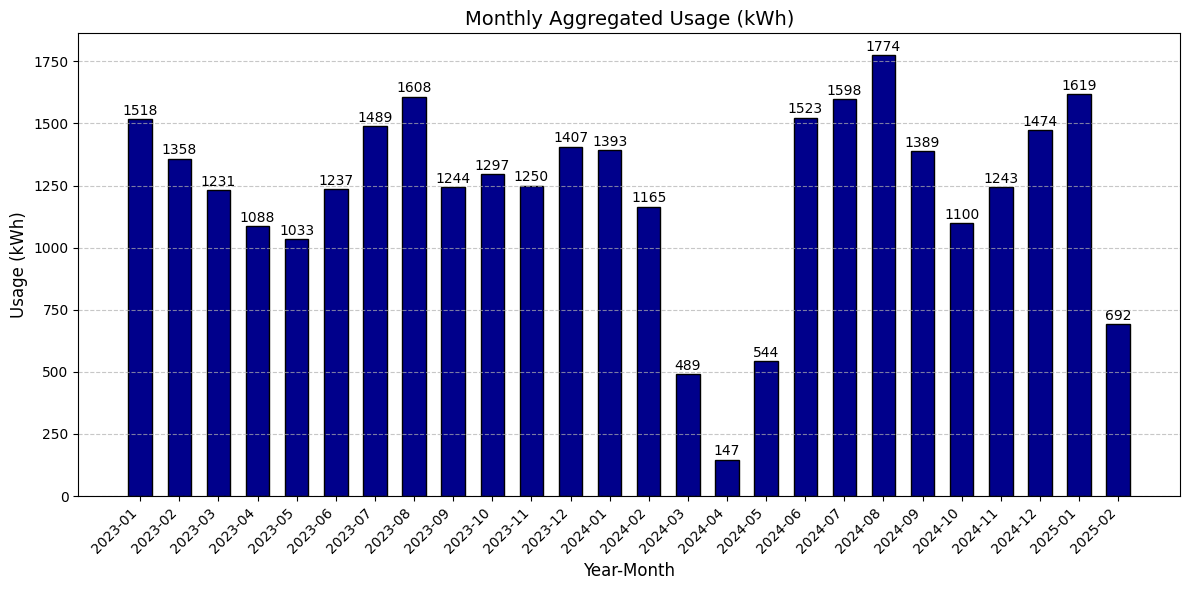

In [ ]:
# Ensure the 'DATE' column is in datetime format
electric_agg_updated['DATE'] = pd.to_datetime(electric_agg_updated['DATE'])

# Extract year and month from the 'DATE' column
electric_agg_updated['YearMonth'] = electric_agg_updated['DATE'].dt.to_period('M')

# Group by 'YearMonth' and aggregate the sum for 'USAGE_(kWh)'
monthly_agg = electric_agg_updated.groupby('YearMonth')['USAGE_(kWh)'].sum()

# Reset index for better readability
monthly_agg = monthly_agg.reset_index()



#Plot net usage from electric company.
# Create a bar chart with conditional coloring
plt.figure(figsize=(12, 6))

# Define colors based on positive or negative values
colors = ['darkblue' if value >= 0 else 'limegreen' for value in monthly_agg['USAGE_(kWh)']]

bars = plt.bar(
    monthly_agg['YearMonth'].astype(str),
    monthly_agg['USAGE_(kWh)'],
    width=0.6,
    color=colors,
    edgecolor='black'
)

# Add data labels on the outside end of each bar
for bar in bars:
    height = bar.get_height()
    # Adjust label position based on whether the bar is positive or negative
    label_position = height + (5 if height > 0 else -5)
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Horizontal position
        label_position,  # Vertical position
        f'{int(round(height))}',  # Label text without decimals
        ha='center', va='bottom' if height > 0 else 'top', fontsize=10
    )

# Add labels and title
plt.title('Monthly Aggregated Usage (kWh)', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Usage (kWh)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()


In [ ]:
# Save the updated DataFrame
electric_agg_updated.to_pickle('/content/drive/My Drive/bi_electric_data.pkl')
print("Electric data saved.")

Electric data saved.


#Future Electric

In [ ]:
# Load the pickle file
file_path = '/content/drive/My Drive/bi_electric_data.pkl'

# Load the DataFrame from the pickle file
electric_agg = pd.read_pickle(file_path)

# Display the first few rows to verify
print(electric_agg.head())


        DATE  hour last_day_month  USAGE_(kWh)  COST      date_timestamp  \
0 2023-01-01     0     2023-01-31         1.46   0.0 2023-01-01 00:00:00   
1 2023-01-01     1     2023-01-31         1.52   0.0 2023-01-01 01:00:00   
2 2023-01-01     2     2023-01-31         1.14   0.0 2023-01-01 02:00:00   
3 2023-01-01     3     2023-01-31         1.64   0.0 2023-01-01 03:00:00   
4 2023-01-01     4     2023-01-31         2.74   0.0 2023-01-01 04:00:00   

   Net_Cost_per_kWh  cost_per_kWh  Net_Usage_Computed  \
0               0.0           0.0                 NaN   
1               0.0           0.0                 NaN   
2               0.0           0.0                 NaN   
3               0.0           0.0                 NaN   
4               0.0           0.0                 NaN   

   Net_Usage_Electric_Company  Billing_Year Billing_Year_Start  \
0                         NaN          2022         2022-04-01   
1                         NaN          2022         2022-04-01   
2 

In [ ]:
# Define the end date to extend to
end_date = '2034-12-31 23:00:00'

# Get the last date from the DataFrame
last_timestamp = electric_agg['date_timestamp'].max()

# Create a date range starting from the next hour after the last_timestamp up to the end date
new_dates = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                          end=end_date, freq='h')

# Create new DataFrame with the necessary columns
new_data = pd.DataFrame({
    'date_timestamp': new_dates,
    'DATE': new_dates.date,
    'hour': new_dates.hour,
    'last_day_month': new_dates + pd.offsets.MonthEnd(0),
    'USAGE_(kWh)': 0,  # or fill with NaN or some placeholder if needed
    'COST': 0,  # or fill with NaN or some placeholder if needed
    'Net_Cost_per_kWh': 0,  # or fill with NaN or some placeholder if needed
    'cost_per_kWh': 0,  # or fill with NaN or some placeholder if needed
    'Net_Usage_Electric_Company': 0  # or fill with NaN or some placeholder if needed
})

# Append the new data to the existing DataFrame
electric_agg_extended = pd.concat([electric_agg, new_data], ignore_index=True)

# Display or save the extended DataFrame
print(electric_agg_extended)


                       DATE  hour      last_day_month  USAGE_(kWh)  COST  \
0       2023-01-01 00:00:00     0 2023-01-31 00:00:00         1.46   0.0   
1       2023-01-01 00:00:00     1 2023-01-31 00:00:00         1.52   0.0   
2       2023-01-01 00:00:00     2 2023-01-31 00:00:00         1.14   0.0   
3       2023-01-01 00:00:00     3 2023-01-31 00:00:00         1.64   0.0   
4       2023-01-01 00:00:00     4 2023-01-31 00:00:00         2.74   0.0   
...                     ...   ...                 ...          ...   ...   
105185           2034-12-31    19 2034-12-31 19:00:00         0.00   0.0   
105186           2034-12-31    20 2034-12-31 20:00:00         0.00   0.0   
105187           2034-12-31    21 2034-12-31 21:00:00         0.00   0.0   
105188           2034-12-31    22 2034-12-31 22:00:00         0.00   0.0   
105189           2034-12-31    23 2034-12-31 23:00:00         0.00   0.0   

            date_timestamp  Net_Cost_per_kWh  cost_per_kWh  \
0      2023-01-01 00:00:0

In [ ]:
#DATE and ESTIMATED_USAGE are not needed
columns_to_drop = ['DATE']

final_electric_agg = electric_agg_extended.drop(columns=columns_to_drop, errors='ignore')
final_electric_agg.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105190 entries, 0 to 105189
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   hour                        105190 non-null  int64         
 1   last_day_month              105190 non-null  datetime64[ns]
 2   USAGE_(kWh)                 105190 non-null  float64       
 3   COST                        105190 non-null  float64       
 4   date_timestamp              105190 non-null  datetime64[ns]
 5   Net_Cost_per_kWh            105183 non-null  float64       
 6   cost_per_kWh                105183 non-null  float64       
 7   Net_Usage_Computed          9686 non-null    float64       
 8   Net_Usage_Electric_Company  96254 non-null   float64       
 9   Billing_Year                18622 non-null   float64       
 10  Billing_Year_Start          18622 non-null   datetime64[ns]
 11  Billing_Month_End           18622 non-n

In [ ]:
# Calculate descriptive statistics for cost_per_kWh and Net_Cost_per_kWh
descriptives = final_electric_agg[['cost_per_kWh', 'Net_Cost_per_kWh']].describe()

# Display the results
print(descriptives)

        cost_per_kWh  Net_Cost_per_kWh
count  105183.000000     105183.000000
mean        0.024011          0.023625
std         0.057140          0.382941
min         0.000000        -52.000000
25%         0.000000          0.000000
50%         0.000000          0.000000
75%         0.000000          0.000000
max         1.246575         77.000000


In [ ]:
# Specify the file path to the pickle file
file_path = '/content/drive/My Drive/bi_solaredge_data_process.pkl'

# Load the DataFrame from the pickle file
solaredge_df2 = pd.read_pickle(file_path)

# Display the first few rows to verify the data is loaded correctly
print(solaredge_df2.head())


                 date   meter_type  value           date_meter_combination
0 2024-01-01 00:00:00  Consumption    NaN  2024-01-01 00:00:00_Consumption
1 2024-01-01 00:00:00       FeedIn    NaN       2024-01-01 00:00:00_FeedIn
2 2024-01-01 00:00:00   Production    NaN   2024-01-01 00:00:00_Production
3 2024-01-01 00:00:00    Purchased    NaN    2024-01-01 00:00:00_Purchased
4 2024-01-01 01:00:00  Consumption    NaN  2024-01-01 01:00:00_Consumption


#Merge the electric data in with the Solar Edge data.

In [ ]:
#Create a pivoted solar edge dataframe.
# Ensure the 'hour' column exists in solaredge_df2
solaredge_df2['hour'] = solaredge_df2['date'].dt.hour

# Pivot the DataFrame without filling missing values
pivoted_solaredge_df2 = solaredge_df2.pivot_table(
    index=['date', 'hour'],              # Group by date and hour
    columns='meter_type',                # Use meter_type as columns
    values='value',                      # Pivot values are from 'value' column
    aggfunc='min'                        # Aggregate duplicate entries using min
).reset_index()                          # Flatten the DataFrame

# Ensure missing values remain as NaN
pivoted_solaredge_df2.rename_axis(None, axis=1, inplace=True)  # Remove axis name

# Rename columns for clarity
pivoted_solaredge_df2.rename_axis(None, axis=1, inplace=True)  # Remove axis name
pivoted_solaredge_df2.rename(columns={'date': 'date'}, inplace=True)  # Ensure clear column names

# Debug: Inspect the pivoted DataFrame
print("Pivoted SolarEdge DataFrame:")
print(pivoted_solaredge_df2.head())

# Check for duplicates (sanity check after pivoting)
duplicates = pivoted_solaredge_df2.duplicated(subset=['date', 'hour'], keep=False)
if duplicates.any():
    print("Duplicates in pivoted_solaredge_df2:")
    print(pivoted_solaredge_df2[duplicates])
else:
    print("No duplicates found in pivoted SolarEdge DataFrame.")


Pivoted SolarEdge DataFrame:
                 date  hour  Consumption  FeedIn  Production  Purchased
0 2024-01-08 09:00:00     9          NaN     NaN       0.072        NaN
1 2024-01-08 10:00:00    10          NaN     NaN       0.285        NaN
2 2024-01-08 11:00:00    11          NaN     NaN       0.251        NaN
3 2024-01-08 12:00:00    12          NaN     NaN       0.782        NaN
4 2024-01-08 13:00:00    13          NaN     NaN       0.491        NaN
No duplicates found in pivoted SolarEdge DataFrame.


In [ ]:
# Check for duplicates in pivoted_solaredge_df2
duplicates_solaredge = pivoted_solaredge_df2.duplicated(subset=['date', 'hour'], keep=False)
if duplicates_solaredge.any():
    print("Duplicates in pivoted_solaredge_df2:")
    print(pivoted_solaredge_df2[duplicates_solaredge])
else:
    print("No duplicates in pivoted_solaredge_df2.")

# Check for duplicates in final_electric_agg
duplicates_electric = final_electric_agg.duplicated(subset=['date_timestamp', 'hour'], keep=False)
if duplicates_electric.any():
    print("Duplicates in final_electric_agg:")
    print(final_electric_agg[duplicates_electric])
else:
    print("No duplicates in final_electric_agg.")


No duplicates in pivoted_solaredge_df2.
No duplicates in final_electric_agg.


In [ ]:
# Ensure datetime consistency
final_electric_agg['date_timestamp'] = pd.to_datetime(final_electric_agg['date_timestamp'])
pivoted_solaredge_df2['date'] = pd.to_datetime(pivoted_solaredge_df2['date'])

# Merge the DataFrames
merged_final_electric_agg = pd.merge(
    final_electric_agg,
    pivoted_solaredge_df2,
    how='left',
    left_on=['date_timestamp', 'hour'],
    right_on=['date', 'hour'],
    suffixes=('', '_solaredge')
)

# Drop redundant columns
merged_final_electric_agg.drop(columns=['date'], inplace=True)

# Check merged DataFrame
print("Merged DataFrame Sample:")
print(merged_final_electric_agg.head())


Merged DataFrame Sample:
   hour last_day_month  USAGE_(kWh)  COST      date_timestamp  \
0     0     2023-01-31         1.46   0.0 2023-01-01 00:00:00   
1     1     2023-01-31         1.52   0.0 2023-01-01 01:00:00   
2     2     2023-01-31         1.14   0.0 2023-01-01 02:00:00   
3     3     2023-01-31         1.64   0.0 2023-01-01 03:00:00   
4     4     2023-01-31         2.74   0.0 2023-01-01 04:00:00   

   Net_Cost_per_kWh  cost_per_kWh  Net_Usage_Computed  \
0               0.0           0.0                 NaN   
1               0.0           0.0                 NaN   
2               0.0           0.0                 NaN   
3               0.0           0.0                 NaN   
4               0.0           0.0                 NaN   

   Net_Usage_Electric_Company  Billing_Year Billing_Year_Start  \
0                         NaN        2022.0         2022-04-01   
1                         NaN        2022.0         2022-04-01   
2                         NaN        2022.0

In [ ]:
merged_final_electric_agg.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105190 entries, 0 to 105189
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   hour                        105190 non-null  int64         
 1   last_day_month              105190 non-null  datetime64[ns]
 2   USAGE_(kWh)                 105190 non-null  float64       
 3   COST                        105190 non-null  float64       
 4   date_timestamp              105190 non-null  datetime64[ns]
 5   Net_Cost_per_kWh            105183 non-null  float64       
 6   cost_per_kWh                105183 non-null  float64       
 7   Net_Usage_Computed          9686 non-null    float64       
 8   Net_Usage_Electric_Company  96254 non-null   float64       
 9   Billing_Year                18622 non-null   float64       
 10  Billing_Year_Start          18622 non-null   datetime64[ns]
 11  Billing_Month_End           18622 non-n

#Check the usage and consumption

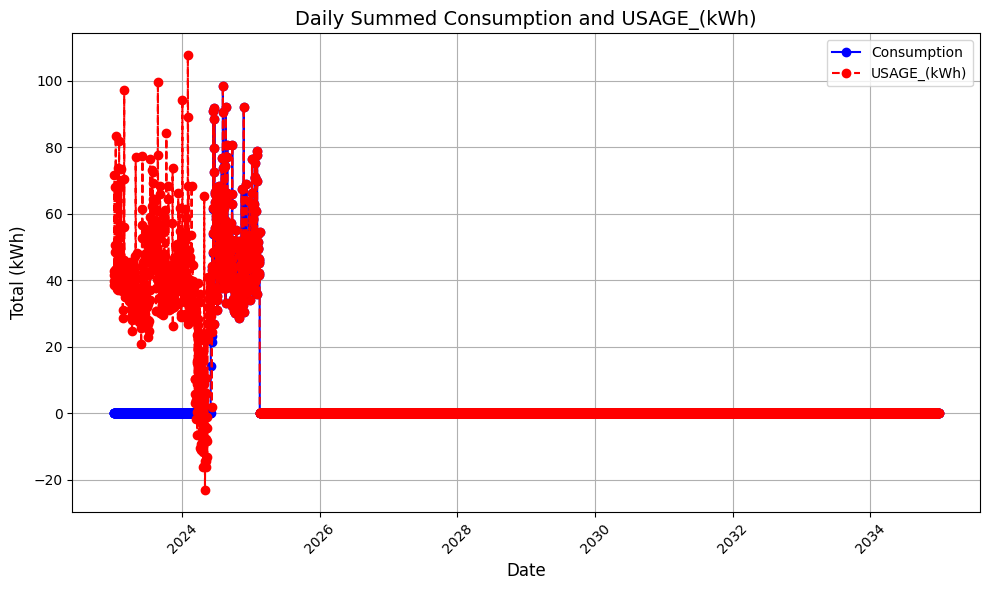

In [ ]:
# Step 1: Resample the data by month and sum the 'Consumption' and 'USAGE_(kWh)'
daily_consumption = merged_final_electric_agg.resample('d', on='date_timestamp')['Consumption'].sum()
daily_usage = merged_final_electric_agg.resample('d', on='date_timestamp')['USAGE_(kWh)'].sum()

# Step 2: Plot both the daily summed consumption and usage
plt.figure(figsize=(10, 6))

# Plot for 'Consumption'
plt.plot(daily_consumption.index, daily_consumption.values, marker='o', linestyle='-', color='b', label='Consumption')

# Plot for 'USAGE_(kWh)'
plt.plot(daily_usage.index, daily_usage.values, marker='o', linestyle='--', color='r', label='USAGE_(kWh)')

# Adding titles and labels
plt.title('Daily Summed Consumption and USAGE_(kWh)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total (kWh)', fontsize=12)

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Identify the maximum actual date from the SolarEdge data
max_actual_date = solaredge_process.loc[
    (solaredge_process['meter_type'] == 'Consumption') & (solaredge_process['value'].notna()), 'date'
].max()
print(max_actual_date)
# Step 2: Create the 'Consumption_Status' field
merged_final_electric_agg['Consumption_Status'] = merged_final_electric_agg.apply(
    lambda row: 'estimated' if (pd.Timestamp('2024-01-01') <= row['date_timestamp'] <= max_actual_date) else
                ('future' if row['date_timestamp'] > max_actual_date else 'actual'),
    axis=1
)

# Display the first few rows to verify
print(merged_final_electric_agg[['date_timestamp', 'Consumption', 'Consumption_Status']].tail())


2025-02-14 23:00:00
            date_timestamp  Consumption Consumption_Status
105185 2034-12-31 19:00:00          NaN             future
105186 2034-12-31 20:00:00          NaN             future
105187 2034-12-31 21:00:00          NaN             future
105188 2034-12-31 22:00:00          NaN             future
105189 2034-12-31 23:00:00          NaN             future


In [ ]:
# Check for duplicate 'date_timestamp' values
duplicate_timestamps = merged_final_electric_agg[merged_final_electric_agg.duplicated(subset=['date_timestamp'], keep=False)]

# Display the duplicate rows
if not duplicate_timestamps.empty:
    print("Duplicate date_timestamp values found:")
    print(duplicate_timestamps)
else:
    print("No duplicate date_timestamp values found.")


No duplicate date_timestamp values found.


In [ ]:
# Calculate the Solaredge_Update_Date based on the max date for Consumption with non-NA values
solaredge_update_date = solaredge_process.loc[
    (solaredge_process['meter_type'] == 'Consumption') & (solaredge_process['value'].notna()), 'date'
].max()

# Add the calculated Solaredge_Update_Date as a new column to merged_final_electric_agg
merged_final_electric_agg['Solaredge_Update_Date'] = solaredge_update_date

# Display a few rows to verify the addition
print(merged_final_electric_agg[['date_timestamp', 'Solaredge_Update_Date']].head())


       date_timestamp Solaredge_Update_Date
0 2023-01-01 00:00:00   2025-02-14 23:00:00
1 2023-01-01 01:00:00   2025-02-14 23:00:00
2 2023-01-01 02:00:00   2025-02-14 23:00:00
3 2023-01-01 03:00:00   2025-02-14 23:00:00
4 2023-01-01 04:00:00   2025-02-14 23:00:00


In [ ]:
merged_final_electric_agg.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105190 entries, 0 to 105189
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   hour                        105190 non-null  int64         
 1   last_day_month              105190 non-null  datetime64[ns]
 2   USAGE_(kWh)                 105190 non-null  float64       
 3   COST                        105190 non-null  float64       
 4   date_timestamp              105190 non-null  datetime64[ns]
 5   Net_Cost_per_kWh            105183 non-null  float64       
 6   cost_per_kWh                105183 non-null  float64       
 7   Net_Usage_Computed          9686 non-null    float64       
 8   Net_Usage_Electric_Company  96254 non-null   float64       
 9   Billing_Year                18622 non-null   float64       
 10  Billing_Year_Start          18622 non-null   datetime64[ns]
 11  Billing_Month_End           18622 non-n

In [ ]:
# Filter rows for the solar edge update date to make sure the last rows aren't coming in NaN
filtered_rows = merged_final_electric_agg.loc[
    merged_final_electric_agg['date_timestamp'].dt.date == merged_final_electric_agg['Solaredge_Update_Date'].dt.date,
    ['date_timestamp', 'Production', 'Consumption', 'FeedIn', 'Purchased']
]

# Display the filtered rows
print(filtered_rows)


           date_timestamp  Production  Consumption  FeedIn  Purchased
18598 2025-02-14 00:00:00       0.000        1.159   0.000      1.159
18599 2025-02-14 01:00:00       0.000        3.870   0.000      3.870
18600 2025-02-14 02:00:00       0.000        1.312   0.000      1.312
18601 2025-02-14 03:00:00       0.000        1.111   0.000      1.111
18602 2025-02-14 04:00:00       0.000        1.226   0.000      1.226
18603 2025-02-14 05:00:00       0.000        1.943   0.000      1.943
18604 2025-02-14 06:00:00       0.005       10.484   0.000     10.479
18605 2025-02-14 07:00:00       0.547        3.905   0.000      3.358
18606 2025-02-14 08:00:00       0.634        2.495   0.000      1.861
18607 2025-02-14 09:00:00       0.957        2.036   0.008      1.087
18608 2025-02-14 10:00:00       1.385        1.317   0.178      0.110
18609 2025-02-14 11:00:00       1.927        1.283   0.702      0.058
18610 2025-02-14 12:00:00       1.943        1.751   0.696      0.504
18611 2025-02-14 13:

In [ ]:
merged_final_electric_agg.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105190 entries, 0 to 105189
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   hour                        105190 non-null  int64         
 1   last_day_month              105190 non-null  datetime64[ns]
 2   USAGE_(kWh)                 105190 non-null  float64       
 3   COST                        105190 non-null  float64       
 4   date_timestamp              105190 non-null  datetime64[ns]
 5   Net_Cost_per_kWh            105183 non-null  float64       
 6   cost_per_kWh                105183 non-null  float64       
 7   Net_Usage_Computed          9686 non-null    float64       
 8   Net_Usage_Electric_Company  96254 non-null   float64       
 9   Billing_Year                18622 non-null   float64       
 10  Billing_Year_Start          18622 non-null   datetime64[ns]
 11  Billing_Month_End           18622 non-n

In [ ]:
# Make the Consumption equal to the usage (because usage was already earlier set to be from electric or consumption solar edge as appropriate).
merged_final_electric_agg['Consumption'] = merged_final_electric_agg['USAGE_(kWh)']

# Define the desired column order
desired_order = [
    'date_timestamp', 'YearMonth', 'last_day_month', 'hour', 'USAGE_(kWh)', 'Net_Usage_Electric_Company', 'COST',
    'cost_per_kWh', 'Net_Cost_per_kWh', 'Consumption', 'FeedIn', 'Production',
    'Purchased', 'Consumption_Status', 'Solaredge_Update_Date'
]

# Reorder the DataFrame columns
merged_final_electric_agg = merged_final_electric_agg[desired_order]

# Display the first few rows to verify the order
print(merged_final_electric_agg.head())


       date_timestamp YearMonth last_day_month  hour  USAGE_(kWh)  \
0 2023-01-01 00:00:00   2023-01     2023-01-31     0         1.46   
1 2023-01-01 01:00:00   2023-01     2023-01-31     1         1.52   
2 2023-01-01 02:00:00   2023-01     2023-01-31     2         1.14   
3 2023-01-01 03:00:00   2023-01     2023-01-31     3         1.64   
4 2023-01-01 04:00:00   2023-01     2023-01-31     4         2.74   

   Net_Usage_Electric_Company  COST  cost_per_kWh  Net_Cost_per_kWh  \
0                         NaN   0.0           0.0               0.0   
1                         NaN   0.0           0.0               0.0   
2                         NaN   0.0           0.0               0.0   
3                         NaN   0.0           0.0               0.0   
4                         NaN   0.0           0.0               0.0   

   Consumption  FeedIn  Production  Purchased Consumption_Status  \
0         1.46     NaN         NaN        NaN             actual   
1         1.52     NaN

In [ ]:
# Capture the maximum date in the 'date_timestamp' column
max_date_timestamp = merged_final_electric_agg['date_timestamp'].max()

# Display the max date_timestamp
print("Max date_timestamp:", max_date_timestamp)


Max date_timestamp: 2034-12-31 23:00:00


In [ ]:
merged_final_electric_agg.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105190 entries, 0 to 105189
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   date_timestamp              105190 non-null  datetime64[ns]
 1   YearMonth                   18622 non-null   period[M]     
 2   last_day_month              105190 non-null  datetime64[ns]
 3   hour                        105190 non-null  int64         
 4   USAGE_(kWh)                 105190 non-null  float64       
 5   Net_Usage_Electric_Company  96254 non-null   float64       
 6   COST                        105190 non-null  float64       
 7   cost_per_kWh                105183 non-null  float64       
 8   Net_Cost_per_kWh            105183 non-null  float64       
 9   Consumption                 105190 non-null  float64       
 10  FeedIn                      6230 non-null    float64       
 11  Production                  9686 non-nu

#Pickle at this point

In [ ]:
# Save the 'merged_final_electric_agg' DataFrame to a pickle file
merged_final_electric_agg.to_pickle('/content/drive/My Drive/merged_final_electric_agg.pkl')

print("merged_final_electric_agg DataFrame saved as pickle file.")



merged_final_electric_agg DataFrame saved as pickle file.


In [ ]:
# Load the 'merged_final_electric_agg' DataFrame from the pickle file
merged_final_electric_agg = pd.read_pickle('/content/drive/My Drive/merged_final_electric_agg.pkl')

print("merged_final_electric_agg DataFrame loaded from pickle file.")


merged_final_electric_agg DataFrame loaded from pickle file.


In [ ]:
merged_final_electric_agg

date_timestamp YearMonth      last_day_month  hour  USAGE_(kWh)  \
0      2023-01-01 00:00:00   2023-01 2023-01-31 00:00:00     0         1.46   
1      2023-01-01 01:00:00   2023-01 2023-01-31 00:00:00     1         1.52   
2      2023-01-01 02:00:00   2023-01 2023-01-31 00:00:00     2         1.14   
3      2023-01-01 03:00:00   2023-01 2023-01-31 00:00:00     3         1.64   
4      2023-01-01 04:00:00   2023-01 2023-01-31 00:00:00     4         2.74   
...                    ...       ...                 ...   ...          ...   
105185 2034-12-31 19:00:00       NaT 2034-12-31 19:00:00    19         0.00   
105186 2034-12-31 20:00:00       NaT 2034-12-31 20:00:00    20         0.00   
105187 2034-12-31 21:00:00       NaT 2034-12-31 21:00:00    21         0.00   
105188 2034-12-31 22:00:00       NaT 2034-12-31 22:00:00    22         0.00   
105189 2034-12-31 23:00:00       NaT 2034-12-31 23:00:00    23         0.00   

        Net_Usage_Electric_Company  COST  cost_per_kWh  Net_Cost_per_kWh  \
0                              NaN   0.0           0.0               0.0   
1                              NaN   0.0           0.0               0.0   
2                              NaN   0.0           0.0               0.0   
3                              NaN   0.0           0.0               0.0   
4                              NaN   0.0           0.0               0.0   
...                            ...   ...           ...               ...   
105185                         0.0   0.0           0.0               0.0   
105186                         0.0   0.0           0.0               0.0   
105187                         0.0   0.0           0.0               0.0   
105188                         0.0   0.0           0.0               0.0   
105189                         0.0   0.0           0.0               0.0   

        Consumption  FeedIn  Production  Purchased Consumption_Status  \
0              1.46     NaN         NaN        NaN             actual   
1              1.52     NaN         NaN        NaN             actual   
2              1.14     NaN         NaN        NaN             actual   
3              1.64     NaN         NaN        NaN             actual   
4              2.74     NaN         NaN        NaN             actual   
...             ...     ...         ...        ...                ...   
105185         0.00     NaN         NaN        NaN             future   
105186         0.00     NaN         NaN        NaN             future   
105187         0.00     NaN         NaN        NaN             future   
105188         0.00     NaN         NaN        NaN             future   
105189         0.00     NaN         NaN        NaN             future   

       Solaredge_Update_Date  
0        2025-02-14 23:00:00  
1        2025-02-14 23:00:00  
2        2025-02-14 23:00:00  
3        2025-02-14 23:00:00  
4        2025-02-14 23:00:00  
...                      ...  
105185   2025-02-14 23:00:00  
105186   2025-02-14 23:00:00  
105187   2025-02-14 23:00:00  
105188   2025-02-14 23:00:00  
105189   2025-02-14 23:00:00  

[105190 rows x 15 columns]

#Add the future dates with Predicted_Usage
This code processes the merged_final_electric_agg and solaredge_df2 dataframes by ensuring their timestamp columns are in datetime format and extracting key temporal features like month, day, and hour. It calculates the average Consumption for the year 2023 grouped by month, day, and hour, using this grouped data to populate the Predicted_Usage column for future dates (i.e., dates beyond the maximum date in solaredge_df2). Finally, it merges the future date data with the calculated predictions and updates the original dataframe, cleaning up intermediate columns afterward.

In [ ]:
# Assuming 'date_timestamp' exists in merged_final_electric_agg
timestamp_col_merged = 'date_timestamp'

# The date column in solaredge_df2 is 'date'
timestamp_col_solaredge = 'date'

# Ensure the timestamp columns are in datetime format
merged_final_electric_agg[timestamp_col_merged] = pd.to_datetime(merged_final_electric_agg[timestamp_col_merged])
solaredge_df2[timestamp_col_solaredge] = pd.to_datetime(solaredge_df2[timestamp_col_solaredge])

# Get the maximum date from solaredge_df2
max_date = solaredge_df2[timestamp_col_solaredge].max()
print("Maximum date in solaredge_df2:", max_date)

# Create 'Predicted_Usage' column initialized with NaN
merged_final_electric_agg['Predicted_Usage'] = np.nan

# Extract month, day, and hour from the timestamp column
merged_final_electric_agg['month'] = merged_final_electric_agg[timestamp_col_merged].dt.month
merged_final_electric_agg['day'] = merged_final_electric_agg[timestamp_col_merged].dt.day
merged_final_electric_agg['hour'] = merged_final_electric_agg[timestamp_col_merged].dt.hour

# Adjust 'adj_day' for leap years (set 2/29 to 2/28)
merged_final_electric_agg['adj_day'] = merged_final_electric_agg['day']
leap_day_mask = (merged_final_electric_agg['month'] == 2) & (merged_final_electric_agg['day'] == 29)
merged_final_electric_agg.loc[leap_day_mask, 'adj_day'] = 28

# Filter data for the year 2023
data_2023 = merged_final_electric_agg[merged_final_electric_agg[timestamp_col_merged].dt.year == 2023].copy()

# Ensure the 'USAGE_(kWh)' column exists
usage_col = 'USAGE_(kWh)'  # Replace with actual column name if different

# Verify 'USAGE_(kWh)' column exists in data_2023
if usage_col not in data_2023.columns:
    raise KeyError(f"Column '{usage_col}' does not exist in data_2023.")

# Group by month, adjusted day, and hour, then calculate the mean USAGE_(kWh)
usage_df = data_2023.groupby(['month', 'adj_day', 'hour'])[usage_col].mean().reset_index()

# Rename 'USAGE_(kWh)' to 'Predicted_Usage' in preparation for the merge
usage_df.rename(columns={usage_col: 'Predicted_Usage'}, inplace=True)

# Debug: Check columns and data in usage_df
print("Columns in usage_df:", usage_df.columns.tolist())
print("First few rows of usage_df:")
print(usage_df.head())

# Identify future dates where prediction is needed
future_dates_mask = merged_final_electric_agg[timestamp_col_merged] > max_date

# Create a copy of future_dates to avoid SettingWithCopyWarning
future_dates = merged_final_electric_agg[future_dates_mask].copy()

# Drop 'Predicted_Usage' from future_dates to prevent column conflict
future_dates.drop(columns=['Predicted_Usage'], inplace=True)

# Ensure merge keys have consistent data types
for col in ['month', 'adj_day', 'hour']:
    future_dates[col] = future_dates[col].astype(int)
    usage_df[col] = usage_df[col].astype(int)

# Perform the merge
future_dates = future_dates.merge(usage_df, on=['month', 'adj_day', 'hour'], how='left')

# Debug: Check columns and data in future_dates after merge
print("Columns in future_dates after merge:", future_dates.columns.tolist())
print("First few rows of future_dates after merge:")
print(future_dates.head())

# Ensure 'Predicted_Usage' exists in future_dates
if 'Predicted_Usage' not in future_dates.columns:
    raise KeyError("'Predicted_Usage' column does not exist in future_dates after merge.")

# Update the 'Predicted_Usage' column in the original dataframe
merged_final_electric_agg.loc[future_dates_mask, 'Predicted_Usage'] = future_dates['Predicted_Usage'].values

# Clean up the auxiliary columns if no longer needed
merged_final_electric_agg.drop(['month', 'day', 'hour', 'adj_day'], axis=1, inplace=True)

# Debug: Verify the updated DataFrame
print("Updated merged_final_electric_agg with Predicted_Usage:")
print(merged_final_electric_agg.head())


Maximum date in solaredge_df2: 2025-02-14 23:00:00
Columns in usage_df: ['month', 'adj_day', 'hour', 'Predicted_Usage']
First few rows of usage_df:
   month  adj_day  hour  Predicted_Usage
0      1        1     0             1.46
1      1        1     1             1.52
2      1        1     2             1.14
3      1        1     3             1.64
4      1        1     4             2.74
Columns in future_dates after merge: ['date_timestamp', 'YearMonth', 'last_day_month', 'hour', 'USAGE_(kWh)', 'Net_Usage_Electric_Company', 'COST', 'cost_per_kWh', 'Net_Cost_per_kWh', 'Consumption', 'FeedIn', 'Production', 'Purchased', 'Consumption_Status', 'Solaredge_Update_Date', 'month', 'day', 'adj_day', 'Predicted_Usage']
First few rows of future_dates after merge:
       date_timestamp YearMonth      last_day_month  hour  USAGE_(kWh)  \
0 2025-02-15 00:00:00       NaT 2025-02-28 00:00:00     0          0.0   
1 2025-02-15 01:00:00       NaT 2025-02-28 01:00:00     1          0.0   
2 2025-02-1

In [ ]:
merged_final_electric_agg.tail(10)

date_timestamp YearMonth      last_day_month  USAGE_(kWh)  \
105180 2034-12-31 14:00:00       NaT 2034-12-31 14:00:00          0.0   
105181 2034-12-31 15:00:00       NaT 2034-12-31 15:00:00          0.0   
105182 2034-12-31 16:00:00       NaT 2034-12-31 16:00:00          0.0   
105183 2034-12-31 17:00:00       NaT 2034-12-31 17:00:00          0.0   
105184 2034-12-31 18:00:00       NaT 2034-12-31 18:00:00          0.0   
105185 2034-12-31 19:00:00       NaT 2034-12-31 19:00:00          0.0   
105186 2034-12-31 20:00:00       NaT 2034-12-31 20:00:00          0.0   
105187 2034-12-31 21:00:00       NaT 2034-12-31 21:00:00          0.0   
105188 2034-12-31 22:00:00       NaT 2034-12-31 22:00:00          0.0   
105189 2034-12-31 23:00:00       NaT 2034-12-31 23:00:00          0.0   

        Net_Usage_Electric_Company  COST  cost_per_kWh  Net_Cost_per_kWh  \
105180                         0.0   0.0           0.0               0.0   
105181                         0.0   0.0           0.0               0.0   
105182                         0.0   0.0           0.0               0.0   
105183                         0.0   0.0           0.0               0.0   
105184                         0.0   0.0           0.0               0.0   
105185                         0.0   0.0           0.0               0.0   
105186                         0.0   0.0           0.0               0.0   
105187                         0.0   0.0           0.0               0.0   
105188                         0.0   0.0           0.0               0.0   
105189                         0.0   0.0           0.0               0.0   

        Consumption  FeedIn  Production  Purchased Consumption_Status  \
105180          0.0     NaN         NaN        NaN             future   
105181          0.0     NaN         NaN        NaN             future   
105182          0.0     NaN         NaN        NaN             future   
105183          0.0     NaN         NaN        NaN             future   
105184          0.0     NaN         NaN        NaN             future   
105185          0.0     NaN         NaN        NaN             future   
105186          0.0     NaN         NaN        NaN             future   
105187          0.0     NaN         NaN        NaN             future   
105188          0.0     NaN         NaN        NaN             future   
105189          0.0     NaN         NaN        NaN             future   

       Solaredge_Update_Date  Predicted_Usage  
105180   2025-02-14 23:00:00             2.03  
105181   2025-02-14 23:00:00             1.91  
105182   2025-02-14 23:00:00             2.83  
105183   2025-02-14 23:00:00             4.78  
105184   2025-02-14 23:00:00             4.53  
105185   2025-02-14 23:00:00             3.42  
105186   2025-02-14 23:00:00             2.87  
105187   2025-02-14 23:00:00             1.96  
105188   2025-02-14 23:00:00             1.68  
105189   2025-02-14 23:00:00             0.88

In [ ]:
merged_final_electric_agg.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105190 entries, 0 to 105189
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   date_timestamp              105190 non-null  datetime64[ns]
 1   YearMonth                   18622 non-null   period[M]     
 2   last_day_month              105190 non-null  datetime64[ns]
 3   USAGE_(kWh)                 105190 non-null  float64       
 4   Net_Usage_Electric_Company  96254 non-null   float64       
 5   COST                        105190 non-null  float64       
 6   cost_per_kWh                105183 non-null  float64       
 7   Net_Cost_per_kWh            105183 non-null  float64       
 8   Consumption                 105190 non-null  float64       
 9   FeedIn                      6230 non-null    float64       
 10  Production                  9686 non-null    float64       
 11  Purchased                   6230 non-nu

In [ ]:
# Recalculate 'YearMonth' based on the full range of 'date_timestamp'
merged_final_electric_agg['YearMonth'] = merged_final_electric_agg['date_timestamp'].dt.to_period('M')

# Verify the updated column
print("Updated YearMonth column:")
print(merged_final_electric_agg[['date_timestamp', 'YearMonth']].head())

# Ensure no truncation occurred
print("Date range in YearMonth after recalculation:")
print(merged_final_electric_agg['YearMonth'].min(), merged_final_electric_agg['YearMonth'].max())


Updated YearMonth column:
       date_timestamp YearMonth
0 2023-01-01 00:00:00   2023-01
1 2023-01-01 01:00:00   2023-01
2 2023-01-01 02:00:00   2023-01
3 2023-01-01 03:00:00   2023-01
4 2023-01-01 04:00:00   2023-01
Date range in YearMonth after recalculation:
2023-01 2034-12


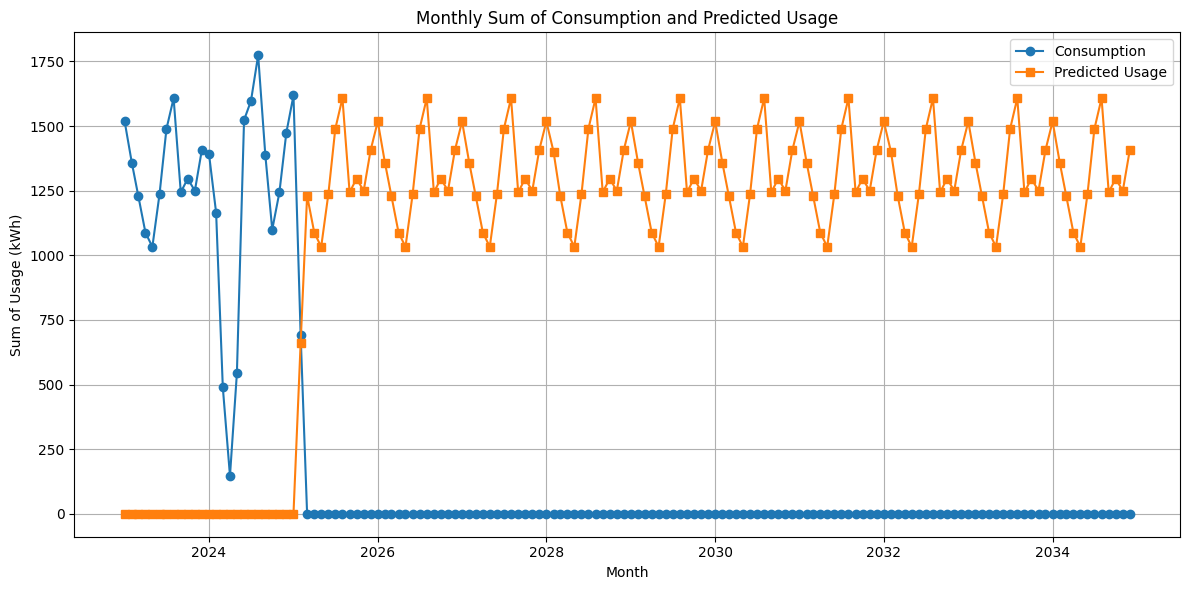

In [ ]:
# Group by 'YearMonth' and sum 'Consumption' and 'Predicted_Usage'
monthly_sums = merged_final_electric_agg.groupby('YearMonth')[['Consumption', 'Predicted_Usage']].sum().reset_index()

# Convert 'Year-Month' back to datetime for plotting
monthly_sums['YearMonth'] = monthly_sums['YearMonth'].dt.to_timestamp()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(monthly_sums['YearMonth'], monthly_sums['Consumption'], marker='o', label='Consumption')
plt.plot(monthly_sums['YearMonth'], monthly_sums['Predicted_Usage'], marker='s', label='Predicted Usage')
plt.xlabel('Month')
plt.ylabel('Sum of Usage (kWh)')
plt.title('Monthly Sum of Consumption and Predicted Usage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Check for any NaN values in Predicted_Usage
nan_predicted_usage = merged_final_electric_agg[merged_final_electric_agg['Predicted_Usage'].isna()]
print(f"Rows with NaN Predicted Usage: {nan_predicted_usage.shape[0]}")
print(nan_predicted_usage[['date_timestamp', 'Predicted_Usage']].head())

# Check the statistics of the Predicted_Usage column
print(merged_final_electric_agg['Predicted_Usage'].describe())

# Check if there are zeros in the Predicted_Usage column
zero_predicted_usage = merged_final_electric_agg[merged_final_electric_agg['Predicted_Usage'] == 0]
print(f"Rows with zero Predicted Usage: {zero_predicted_usage.shape[0]}")
print(zero_predicted_usage[['date_timestamp', 'Predicted_Usage']].head())


Rows with NaN Predicted Usage: 18632
       date_timestamp  Predicted_Usage
0 2023-01-01 00:00:00              NaN
1 2023-01-01 01:00:00              NaN
2 2023-01-01 02:00:00              NaN
3 2023-01-01 03:00:00              NaN
4 2023-01-01 04:00:00              NaN
count    86558.000000
mean         1.796014
std          1.318684
min          0.450000
25%          1.000000
50%          1.270000
75%          2.080000
max         14.110000
Name: Predicted_Usage, dtype: float64
Rows with zero Predicted Usage: 0
Empty DataFrame
Columns: [date_timestamp, Predicted_Usage]
Index: []


In [ ]:
# Ensure 'date_timestamp' is in datetime format
final_electric_agg['date_timestamp'] = pd.to_datetime(final_electric_agg['date_timestamp'])

# Get the minimum and maximum dates
min_date = final_electric_agg['date_timestamp'].min()
max_date = final_electric_agg['date_timestamp'].max()

# Print the results
print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")


Minimum Date: 2023-01-01 00:00:00
Maximum Date: 2034-12-31 23:00:00


In [ ]:
merged_final_electric_agg.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105190 entries, 0 to 105189
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   date_timestamp              105190 non-null  datetime64[ns]
 1   YearMonth                   105190 non-null  period[M]     
 2   last_day_month              105190 non-null  datetime64[ns]
 3   USAGE_(kWh)                 105190 non-null  float64       
 4   Net_Usage_Electric_Company  96254 non-null   float64       
 5   COST                        105190 non-null  float64       
 6   cost_per_kWh                105183 non-null  float64       
 7   Net_Cost_per_kWh            105183 non-null  float64       
 8   Consumption                 105190 non-null  float64       
 9   FeedIn                      6230 non-null    float64       
 10  Production                  9686 non-null    float64       
 11  Purchased                   6230 non-nu

In [ ]:
# Calculate descriptive statistics for cost_per_kWh and Net_Cost_per_kWh
descriptives = merged_final_electric_agg[['cost_per_kWh', 'Net_Cost_per_kWh']].describe()

# Display the results
print(descriptives)

        cost_per_kWh  Net_Cost_per_kWh
count  105183.000000     105183.000000
mean        0.024011          0.023625
std         0.057140          0.382941
min         0.000000        -52.000000
25%         0.000000          0.000000
50%         0.000000          0.000000
75%         0.000000          0.000000
max         1.246575         77.000000


In [ ]:
# Filter for dates prior to 1/2/2025
filtered_data = final_electric_agg[final_electric_agg['date_timestamp'] < '2025-01-02']

# Calculate descriptive statistics for cost_per_kWh and Net_Cost_per_kWh
descriptives = filtered_data[['cost_per_kWh', 'Net_Cost_per_kWh']].describe()

# Display the results
print(descriptives)


       cost_per_kWh  Net_Cost_per_kWh
count  17560.000000      17560.000000
mean       0.135494          0.133175
std        0.059114          0.928903
min        0.000000        -52.000000
25%        0.118280          0.117647
50%        0.131313          0.130769
75%        0.150259          0.150000
max        1.246575         77.000000


In [ ]:
# Filter for dates prior to 1/2/2025
filtered_data = final_electric_agg[final_electric_agg['date_timestamp'] > '2025-01-02']

# Calculate descriptive statistics for cost_per_kWh and Net_Cost_per_kWh
descriptives = filtered_data[['cost_per_kWh', 'Net_Cost_per_kWh']].describe()

# Display the results
print(descriptives)


       cost_per_kWh  Net_Cost_per_kWh
count  87622.000000      87622.000000
mean       0.001668          0.001669
std        0.015127          0.015229
min        0.000000          0.000000
25%        0.000000          0.000000
50%        0.000000          0.000000
75%        0.000000          0.000000
max        0.166667          0.500000


In [ ]:
# Filter for dates prior to 1/1/2023
filtered_data = final_electric_agg[final_electric_agg['date_timestamp'] == '2023-01-01']

# Calculate descriptive statistics for cost_per_kWh and Net_Cost_per_kWh
descriptives = filtered_data[['cost_per_kWh', 'Net_Cost_per_kWh']].describe()

# Display the results
print(descriptives)


       cost_per_kWh  Net_Cost_per_kWh
count           1.0               1.0
mean            0.0               0.0
std             NaN               NaN
min             0.0               0.0
25%             0.0               0.0
50%             0.0               0.0
75%             0.0               0.0
max             0.0               0.0


#Saving point

In [ ]:
## Save the updated DataFrame
merged_final_electric_agg .to_pickle('/content/drive/My Drive/bi_electric_all_data_raw1.pkl')
print("Electric data saved.")

Electric data saved.


In [ ]:
##Load pickle
merged_final_electric_agg = pd.read_pickle('/content/drive/My Drive/bi_electric_all_data_raw1.pkl')

In [ ]:
merged_final_electric_agg.tail(10)

date_timestamp YearMonth      last_day_month  USAGE_(kWh)  \
105180 2034-12-31 14:00:00   2034-12 2034-12-31 14:00:00          0.0   
105181 2034-12-31 15:00:00   2034-12 2034-12-31 15:00:00          0.0   
105182 2034-12-31 16:00:00   2034-12 2034-12-31 16:00:00          0.0   
105183 2034-12-31 17:00:00   2034-12 2034-12-31 17:00:00          0.0   
105184 2034-12-31 18:00:00   2034-12 2034-12-31 18:00:00          0.0   
105185 2034-12-31 19:00:00   2034-12 2034-12-31 19:00:00          0.0   
105186 2034-12-31 20:00:00   2034-12 2034-12-31 20:00:00          0.0   
105187 2034-12-31 21:00:00   2034-12 2034-12-31 21:00:00          0.0   
105188 2034-12-31 22:00:00   2034-12 2034-12-31 22:00:00          0.0   
105189 2034-12-31 23:00:00   2034-12 2034-12-31 23:00:00          0.0   

        Net_Usage_Electric_Company  COST  cost_per_kWh  Net_Cost_per_kWh  \
105180                         0.0   0.0           0.0               0.0   
105181                         0.0   0.0           0.0               0.0   
105182                         0.0   0.0           0.0               0.0   
105183                         0.0   0.0           0.0               0.0   
105184                         0.0   0.0           0.0               0.0   
105185                         0.0   0.0           0.0               0.0   
105186                         0.0   0.0           0.0               0.0   
105187                         0.0   0.0           0.0               0.0   
105188                         0.0   0.0           0.0               0.0   
105189                         0.0   0.0           0.0               0.0   

        Consumption  FeedIn  Production  Purchased Consumption_Status  \
105180          0.0     NaN         NaN        NaN             future   
105181          0.0     NaN         NaN        NaN             future   
105182          0.0     NaN         NaN        NaN             future   
105183          0.0     NaN         NaN        NaN             future   
105184          0.0     NaN         NaN        NaN             future   
105185          0.0     NaN         NaN        NaN             future   
105186          0.0     NaN         NaN        NaN             future   
105187          0.0     NaN         NaN        NaN             future   
105188          0.0     NaN         NaN        NaN             future   
105189          0.0     NaN         NaN        NaN             future   

       Solaredge_Update_Date  Predicted_Usage  
105180   2025-02-14 23:00:00             2.03  
105181   2025-02-14 23:00:00             1.91  
105182   2025-02-14 23:00:00             2.83  
105183   2025-02-14 23:00:00             4.78  
105184   2025-02-14 23:00:00             4.53  
105185   2025-02-14 23:00:00             3.42  
105186   2025-02-14 23:00:00             2.87  
105187   2025-02-14 23:00:00             1.96  
105188   2025-02-14 23:00:00             1.68  
105189   2025-02-14 23:00:00             0.88

##Add the best guess of what the billing month might be in the future.
- build on the already existing billing_month_df
- develop a function that will add a best guess of future billing dates up through 1/31/2035.
- billing months should be about 30-35 days
- the billing month should never start on Saturday, Sunday, or a US holiday
- the billing year starts in the April billing month

###Create future_billing_month_df

In [ ]:
from datetime import timedelta
import pandas as pd
import holidays

# Define US holidays
us_holidays = holidays.US()

# Initialize variables for generating future billing months
current_month_start = billing_month_df["Billing_Month_End"].max() + timedelta(hours=1)  # Start 1 hour after last end
future_billing_months = []

# Generate future billing months up to January 31, 2035
while current_month_start <= pd.Timestamp("2035-01-31"):
    # Ensure start date is not a weekend or US holiday
    while current_month_start.weekday() >= 5 or current_month_start in us_holidays:
        current_month_start += timedelta(days=1)  # Move to next day

    # Calculate an approximate end date (30-35 days later)
    next_month_start = current_month_start + timedelta(days=30)
    while next_month_start.weekday() >= 5 or next_month_start in us_holidays:
        next_month_start += timedelta(days=1)  # Move end to next valid day

    # Billing month ends 1 hour before the next month starts
    billing_month_end = next_month_start - timedelta(hours=1)

    # Determine the billing year
    # The billing year starts with April; months before April belong to the previous year
    if current_month_start.month >= 4:  # April or later belongs to the current year
        billing_year = current_month_start.year
    else:  # January, February, March belong to the previous year
        billing_year = current_month_start.year - 1

    # Get billing month name
    billing_month = current_month_start.strftime("%B")

    # Append to the future billing months list
    future_billing_months.append({
        "Billing_Year": billing_year,
        "Billing_Year_Start": pd.Timestamp(billing_year, 4, 1),  # April 1 of the billing year
        "Billing_Month_Start": current_month_start,
        "Billing_Month_Start_Day": current_month_start.strftime("%A"),  # Add start day of the week
        "Billing_Month_End": billing_month_end,
        "Billing_Month_End_Day": billing_month_end.strftime("%A"),      # Add end day of the week
        "Billing_Month": billing_month
    })

    # Move to the next billing month
    current_month_start = next_month_start

# Convert the future billing months list to a DataFrame
future_billing_months_df = pd.DataFrame(future_billing_months)

# Append to the original billing_month_df
future_billing_month_df = pd.concat([billing_month_df, future_billing_months_df], ignore_index=True)


In [ ]:
future_billing_month_df

Billing_Year Billing_Year_Start Billing_Month Billing_Month_Start  \
0            2022         2022-04-01       January          2022-12-29   
1            2022         2022-04-01      February          2023-01-30   
2            2022         2022-04-01         March          2023-02-28   
3            2023         2023-03-29         April          2023-03-29   
4            2023         2023-03-29           May          2023-04-27   
..            ...                ...           ...                 ...   
141          2034         2034-04-01     September          2034-09-06   
142          2034         2034-04-01       October          2034-10-06   
143          2034         2034-04-01      November          2034-11-06   
144          2034         2034-04-01      December          2034-12-06   
145          2034         2034-04-01       January          2035-01-05   

      Billing_Month_End Billing_Month_Start_Day Billing_Month_End_Day  
0   2023-01-29 23:00:00                     NaN                   NaN  
1   2023-02-27 23:00:00                     NaN                   NaN  
2   2023-03-28 23:00:00                     NaN                   NaN  
3   2023-04-26 23:00:00                     NaN                   NaN  
4   2023-05-25 23:00:00                     NaN                   NaN  
..                  ...                     ...                   ...  
141 2034-10-05 23:00:00               Wednesday              Thursday  
142 2034-11-05 23:00:00                  Friday                Sunday  
143 2034-12-05 23:00:00                  Monday               Tuesday  
144 2035-01-04 23:00:00               Wednesday              Thursday  
145 2035-02-04 23:00:00                  Friday                Sunday  

[146 rows x 7 columns]

###Add future_billing_month_df to merged_final_electric_agg

In [ ]:
# Ensure the result DataFrame starts as a complete copy of merged_final_electric_agg
merged_df = merged_final_electric_agg.copy()

# Ensure future_billing_month_df has a 'Billing_Month' column
if 'Billing_Month' not in future_billing_month_df.columns:
    future_billing_month_df['Billing_Month'] = future_billing_month_df['Billing_Month_Start'].dt.month_name()

# Sort future_billing_month_df by Billing_Month_Start to ensure proper processing order
future_billing_month_df = future_billing_month_df.sort_values(by='Billing_Month_Start')

# Process each billing month row by row
for _, row in future_billing_month_df.iterrows():
    # Create a condition to check if date_timestamp falls within the billing range
    condition = (merged_df['date_timestamp'] >= row['Billing_Month_Start']) & \
                (merged_df['date_timestamp'] <= row['Billing_Month_End'])

    # Assign billing information only if the condition matches
    merged_df.loc[condition, ['Billing_Year', 'Billing_Year_Start',
                              'Billing_Month_Start', 'Billing_Month_End', 'Billing_Month']] = \
        row[['Billing_Year', 'Billing_Year_Start',
             'Billing_Month_Start', 'Billing_Month_End', 'Billing_Month']].values

# Perform a left join to add the new billing information to electric_agg_updated
merged_final_electric_agg_updated = pd.merge(
    merged_final_electric_agg,
    merged_df[['date_timestamp', 'Billing_Year', 'Billing_Year_Start', 'Billing_Month_Start',
               'Billing_Month_End', 'Billing_Month']],
    on='date_timestamp',
    how='left'
)

# Check rows for March 2024 to ensure the fix worked
march_2024_check = merged_final_electric_agg_updated[
    (merged_final_electric_agg_updated['date_timestamp'] >= '2024-03-01') &
    (merged_final_electric_agg_updated['date_timestamp'] <= '2024-03-31')
]

# Display March 2024 data if needed
march_2024_check[['date_timestamp', 'Billing_Year', 'Billing_Month', 'Billing_Month_Start', 'Billing_Month_End']]


date_timestamp  Billing_Year Billing_Month Billing_Month_Start  \
10199 2024-03-01 00:00:00        2023.0      February          2024-01-29   
10200 2024-03-01 01:00:00        2023.0      February          2024-01-29   
10201 2024-03-01 02:00:00        2023.0      February          2024-01-29   
10202 2024-03-01 03:00:00        2023.0      February          2024-01-29   
10203 2024-03-01 04:00:00        2023.0      February          2024-01-29   
...                   ...           ...           ...                 ...   
10914 2024-03-30 20:00:00        2023.0         March          2024-03-05   
10915 2024-03-30 21:00:00        2023.0         March          2024-03-05   
10916 2024-03-30 22:00:00        2023.0         March          2024-03-05   
10917 2024-03-30 23:00:00        2023.0         March          2024-03-05   
10918 2024-03-31 00:00:00        2023.0         March          2024-03-05   

        Billing_Month_End  
10199 2024-03-04 23:00:00  
10200 2024-03-04 23:00:00  
10201 2024-03-04 23:00:00  
10202 2024-03-04 23:00:00  
10203 2024-03-04 23:00:00  
...                   ...  
10914 2024-04-01 23:00:00  
10915 2024-04-01 23:00:00  
10916 2024-04-01 23:00:00  
10917 2024-04-01 23:00:00  
10918 2024-04-01 23:00:00  

[720 rows x 5 columns]

In [ ]:
# Convert Billing_Year to integers
merged_final_electric_agg_updated['Billing_Year'] = merged_final_electric_agg_updated['Billing_Year'].astype(int)


In [ ]:
## Save the updated DataFrame
merged_final_electric_agg_updated.to_pickle('/content/drive/My Drive/bi_electric_all_data_raw2.pkl')
print("Electric data saved.")

Electric data saved.


In [ ]:
## Load the updated DataFrame
merged_final_electric_agg = pd.read_pickle('/content/drive/My Drive/bi_electric_all_data_raw2.pkl')
print("Electric data saved.")

Electric data saved.


In [ ]:
merged_final_electric_agg.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105190 entries, 0 to 105189
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   date_timestamp              105190 non-null  datetime64[ns]
 1   YearMonth                   105190 non-null  period[M]     
 2   last_day_month              105190 non-null  datetime64[ns]
 3   USAGE_(kWh)                 105190 non-null  float64       
 4   Net_Usage_Electric_Company  96254 non-null   float64       
 5   COST                        105190 non-null  float64       
 6   cost_per_kWh                105183 non-null  float64       
 7   Net_Cost_per_kWh            105183 non-null  float64       
 8   Consumption                 105190 non-null  float64       
 9   FeedIn                      6230 non-null    float64       
 10  Production                  9686 non-null    float64       
 11  Purchased                   6230 non-nu

#Part 2 Predict the production values

In [ ]:
# Load the production data from the pickle file
production_df = pd.read_pickle('/content/drive/My Drive/bi_solaredge_data_process.pkl')

# Load the weather data from the pickle file
weather_df = pd.read_pickle('/content/drive/My Drive/bi_weather_all_data_raw.pkl')


# Load the electric data from the pickle file
electric_df = pd.read_pickle('/content/drive/My Drive/bi_electric_all_data_raw2.pkl')


# Load the area predicted values by month/hour dataframe
df_solar = pd.read_pickle('/content/drive/My Drive/solar_production_estimate.pkl')

In [ ]:
# Filter the DataFrame where meter_type is 'Production' and value is not NaN
production_data = production_df[(production_df['meter_type'] == 'Production') & (production_df['value'].notna())]

# Ensure the 'date' column in production_df is in datetime format
production_df['date'] = pd.to_datetime(production_df['date'])

# Filter production_df where meter_type is "Production" (no date range limit)
filtered_production_df = production_df[production_df['meter_type'] == "Production"]

# Perform the left join, keeping all dates from weather_df
# Assuming 'weather_df' has the correct date field which was 'date_timestamp' in previous descriptions
merged_df = pd.merge(weather_df, filtered_production_df, left_on='date_timestamp', right_on='date', how='left')

# Display the structure and a sample of the merged DataFrame to verify the result
print(merged_df.info())
print(merged_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype                          
---  ------                    --------------   -----                          
 0   date_timestamp            113952 non-null  datetime64[ns]                 
 1   day_hour                  113952 non-null  object                         
 2   hour                      113952 non-null  float64                        
 3   temperature_2m            113952 non-null  float32                        
 4   relative_humidity_2m      113952 non-null  float32                        
 5   dew_point_2m              113952 non-null  float32                        
 6   precipitation             113952 non-null  float32                        
 7   snowfall                  113952 non-null  float32                        
 8   snow_depth                113295 non-null  float32                        
 9   clou

In [ ]:
merged_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype                          
---  ------                    --------------   -----                          
 0   date_timestamp            113952 non-null  datetime64[ns]                 
 1   day_hour                  113952 non-null  object                         
 2   hour                      113952 non-null  float64                        
 3   temperature_2m            113952 non-null  float32                        
 4   relative_humidity_2m      113952 non-null  float32                        
 5   dew_point_2m              113952 non-null  float32                        
 6   precipitation             113952 non-null  float32                        
 7   snowfall                  113952 non-null  float32                        
 8   snow_depth                113295 non-null  float32                        
 9   clou

#Data Preprocessing

In [ ]:
# Find and display the row(s) with any null values
null_rows = merged_df[merged_df.isnull().any(axis=1)]


# Display the row with null values
print(null_rows)

#There is 1 NaN production value and that is happening when it is not daytime so that is ok since the analysis will be focused on day.
#There are NaN snow data. Those can be 0 filled because they happen in summer dates.

            date_timestamp  day_hour  hour  temperature_2m  \
0      2022-01-01 00:00:00  01-01 00   0.0       30.799400   
1      2022-01-01 01:00:00  01-01 01   1.0       29.179399   
2      2022-01-01 02:00:00  01-01 02   2.0       29.629400   
3      2022-01-01 03:00:00  01-01 03   3.0       29.449400   
4      2022-01-01 04:00:00  01-01 04   4.0       28.729401   
...                    ...       ...   ...             ...   
113947 2034-12-31 19:00:00  12-31 19  19.0       30.439400   
113948 2034-12-31 20:00:00  12-31 20  20.0       30.709400   
113949 2034-12-31 21:00:00  12-31 21  21.0       30.619400   
113950 2034-12-31 22:00:00  12-31 22  22.0       30.349400   
113951 2034-12-31 23:00:00  12-31 23  23.0       30.439400   

        relative_humidity_2m  dew_point_2m  precipitation  snowfall  \
0                  92.598465     28.909401            0.0       0.0   
1                  92.888649     27.379400            0.0       0.0   
2                  93.591866     28.009399

In [ ]:
merged_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype                          
---  ------                    --------------   -----                          
 0   date_timestamp            113952 non-null  datetime64[ns]                 
 1   day_hour                  113952 non-null  object                         
 2   hour                      113952 non-null  float64                        
 3   temperature_2m            113952 non-null  float32                        
 4   relative_humidity_2m      113952 non-null  float32                        
 5   dew_point_2m              113952 non-null  float32                        
 6   precipitation             113952 non-null  float32                        
 7   snowfall                  113952 non-null  float32                        
 8   snow_depth                113295 non-null  float32                        
 9   clou

In [ ]:
# Drop the 'date' and 'hour_y' columns from merged_df
merged_df.drop(columns=['date'], inplace=True, errors='ignore')


In [ ]:

# Replace NaN values in 'snow_depth' with 0 only for months between May (5) and October (10) inclusive
merged_df.loc[(merged_df['snow_depth'].isna()) & (merged_df['date_timestamp'].dt.month >= 5) & (merged_df['date_timestamp'].dt.month <= 10), 'snow_depth'] = 0

# Fill NaN values in 'value' with 0 where 'is_daylight' is 0
merged_df.loc[(merged_df['is_daylight'] == 0) & (merged_df['value'].isnull()), 'value'] = 0

# Add month and day number fields.
# Ensure the 'date' column is in datetime format (assuming you meant to convert 'date_x' here)
merged_df['date_timestamp'] = pd.to_datetime(merged_df['date_timestamp'])

# Add a column for the day of the month
merged_df['day_of_month'] = merged_df['date_timestamp'].dt.day

# Add a column for the month
merged_df['month'] = merged_df['date_timestamp'].dt.month

merged_df.info(verbose=True,show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype                          
---  ------                    --------------   -----                          
 0   date_timestamp            113952 non-null  datetime64[ns]                 
 1   day_hour                  113952 non-null  object                         
 2   hour                      113952 non-null  float64                        
 3   temperature_2m            113952 non-null  float32                        
 4   relative_humidity_2m      113952 non-null  float32                        
 5   dew_point_2m              113952 non-null  float32                        
 6   precipitation             113952 non-null  float32                        
 7   snowfall                  113952 non-null  float32                        
 8   snow_depth                113816 non-null  float32                        
 9   clou

In [ ]:
# Identify rows where 'is_daylight' is null
null_is_daylight_df = merged_df[merged_df['is_daylight'].isna()]

# Display the rows where 'is_daylight' is null
print(null_is_daylight_df)

# Optionally, show the number of rows where 'is_daylight' is null
print(f"Number of rows with 'is_daylight' as null: {null_is_daylight_df.shape[0]}")


Empty DataFrame
Columns: [date_timestamp, day_hour, hour, temperature_2m, relative_humidity_2m, dew_point_2m, precipitation, snowfall, snow_depth, cloud_cover, cloud_cover_low, cloud_cover_mid, cloud_cover_high, wind_speed_10m, wind_gusts_10m, sunshine_duration, global_tilted_irradiance, is_daylight, solar_angle, solar_azimuth, sunrise_hour, sunset_hour, sunset, sunrise, data_type, meter_type, value, date_meter_combination, day_of_month, month]
Index: []

[0 rows x 30 columns]
Number of rows with 'is_daylight' as null: 0


#Restructure the Dataframe and fields

In [ ]:
merged_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype                          
---  ------                    --------------   -----                          
 0   date_timestamp            113952 non-null  datetime64[ns]                 
 1   day_hour                  113952 non-null  object                         
 2   hour                      113952 non-null  float64                        
 3   temperature_2m            113952 non-null  float32                        
 4   relative_humidity_2m      113952 non-null  float32                        
 5   dew_point_2m              113952 non-null  float32                        
 6   precipitation             113952 non-null  float32                        
 7   snowfall                  113952 non-null  float32                        
 8   snow_depth                113816 non-null  float32                        
 9   clou

In [ ]:
# Step 1: Add 'month' and 'day_of_month' columns safely
merged_df = merged_df.copy()  # Ensure we're working on a copy of the DataFrame
merged_df['month'] = merged_df['date_timestamp'].dt.month
merged_df['day_of_month'] = merged_df['date_timestamp'].dt.day

# Step 2: Drop the specified fields from merged_df
fields_to_drop = ['meter_type', 'sunrise_hour', 'sunset_hour', 'snowfall', 'sunrise', 'sunset']
merged_df.drop(columns=fields_to_drop, inplace=True, errors='ignore')

# Step 3: Reorder the columns in the desired order
columns_order = [
    'date_timestamp', 'month', 'day_of_month', 'hour', 'is_daylight',  'solar_angle',
    'solar_azimuth', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
    'precipitation', 'snow_depth', 'cloud_cover', 'cloud_cover_low',
    'cloud_cover_mid', 'cloud_cover_high', 'wind_speed_10m',
    'wind_gusts_10m', 'sunshine_duration', 'global_tilted_irradiance','value'
]

# Step 4: Reorder the DataFrame
merged_df = merged_df[columns_order]

# Step 5: Display the first few rows to confirm the changes
print(merged_df.head())


       date_timestamp  month  day_of_month  hour  is_daylight  solar_angle  \
0 2022-01-01 00:00:00      1             1   0.0            0   -70.688555   
1 2022-01-01 01:00:00      1             1   1.0            0   -66.512771   
2 2022-01-01 02:00:00      1             1   2.0            0   -57.778016   
3 2022-01-01 03:00:00      1             1   3.0            0   -47.315025   
4 2022-01-01 04:00:00      1             1   4.0            0   -36.299107   

   solar_azimuth  temperature_2m  relative_humidity_2m  dew_point_2m  ...  \
0       3.056930       30.799400             92.598465     28.909401  ...   
1      39.814783       29.179399             92.888649     27.379400  ...   
2      63.069547       29.629400             93.591866     28.009399  ...   
3      78.020430       29.449400             93.586723     27.829399  ...   
4      89.240580       28.729401             94.262344     27.289400  ...   

   snow_depth  cloud_cover  cloud_cover_low  cloud_cover_mid  \
0   

#Code the value where is_daylight = 0 to 0.0

In [ ]:
# Set 'value' to 0.0 wherever 'is_daylight' is 0
merged_df.loc[merged_df['is_daylight'] == 0, 'value'] = 0.0


In [ ]:
merged_df

date_timestamp  month  day_of_month  hour  is_daylight  \
0      2022-01-01 00:00:00      1             1   0.0            0   
1      2022-01-01 01:00:00      1             1   1.0            0   
2      2022-01-01 02:00:00      1             1   2.0            0   
3      2022-01-01 03:00:00      1             1   3.0            0   
4      2022-01-01 04:00:00      1             1   4.0            0   
...                    ...    ...           ...   ...          ...   
113947 2034-12-31 19:00:00     12            31  19.0            0   
113948 2034-12-31 20:00:00     12            31  20.0            0   
113949 2034-12-31 21:00:00     12            31  21.0            0   
113950 2034-12-31 22:00:00     12            31  22.0            0   
113951 2034-12-31 23:00:00     12            31  23.0            0   

        solar_angle  solar_azimuth  temperature_2m  relative_humidity_2m  \
0        -70.688555       3.056930       30.799400             92.598465   
1        -66.512771      39.814783       29.179399             92.888649   
2        -57.778016      63.069547       29.629400             93.591866   
3        -47.315025      78.020430       29.449400             93.586723   
4        -36.299107      89.240580       28.729401             94.262344   
...             ...            ...             ...                   ...   
113947   -26.893894     262.454319       30.439400             93.597000   
113948   -37.962894     272.252301       30.709400             93.208801   
113949   -48.934295     283.851877       30.619400             93.167740   
113950   -59.239961     299.669257       30.349400             92.121437   
113951   -67.526769     324.736302       30.439400             91.906746   

        dew_point_2m  ...  snow_depth  cloud_cover  cloud_cover_low  \
0          28.909401  ...    0.131234    60.299999             67.0   
1          27.379400  ...    0.131234    87.299995             97.0   
2          28.009399  ...    0.131234    89.099998             99.0   
3          27.829399  ...    0.131234    90.000000            100.0   
4          27.289400  ...    0.131234    71.099998             79.0   
...              ...  ...         ...          ...              ...   
113947     28.189400  ...    0.000000    30.600002              0.0   
113948     28.099400  ...    0.000000    80.100006              0.0   
113949     28.099400  ...    0.000000    92.700005              0.0   
113950     28.189400  ...    0.000000   100.000000              0.0   
113951     28.369400  ...    0.000000   100.000000              0.0   

        cloud_cover_mid  cloud_cover_high  wind_speed_10m  wind_gusts_10m  \
0                   0.0               0.0        6.267593       11.856100   
1                   0.0               0.0        6.109918       11.632400   
2                   0.0               0.0        6.105822       11.408700   
3                   0.0               0.0        5.317288       11.184999   
4                   0.0               0.0        3.257121        9.842800   
...                 ...               ...             ...             ...   
113947              1.0             100.0        4.302955        8.053200   
113948             79.0             100.0        3.906753        7.382100   
113949            100.0             100.0        3.537008        6.711000   
113950             86.0             100.0        4.367882        7.605800   
113951              0.0             100.0        5.415204        9.619101   

        sunshine_duration  global_tilted_irradiance  value  
0                     0.0                       0.0    0.0  
1                     0.0                       0.0    0.0  
2                     0.0                       0.0    0.0  
3                     0.0                       0.0    0.0  
4                     0.0                       0.0    0.0  
...                   ...                       ...    ...  
113947                0.0                       0.0  

#Create a Solstice Field

In [ ]:
# Define the function to create the solar day feature
def create_solar_day_feature(df, date_column):
    # Define the key dates
    winter_solstice = pd.Timestamp("2020-12-21")
    summer_solstice = pd.Timestamp("2021-06-20")

    def calculate_day_count(date):
        year = date.year
        # Adjust for leap years
        winter_solstice_this_year = winter_solstice.replace(year=int(year))
        summer_solstice_this_year = summer_solstice.replace(year=int(year + 1 if date > summer_solstice.replace(year=int(year)) else year))

        if date < winter_solstice_this_year:
            # Date is in the prior year before winter solstice, adjust to this year's winter solstice
            winter_solstice_this_year = winter_solstice_this_year.replace(year=int(year - 1))

        days_from_solstice = (date - winter_solstice_this_year).days

        if days_from_solstice < 0:
            days_from_solstice += 365 + (1 if year % 4 == 0 else 0)  # Add days for the previous year

        # If it's between December 21 and June 20, return the count up
        if days_from_solstice <= 182:  # Max count is 182 (half a year, considering leap year)
            return days_from_solstice

        # If it's after June 20, return the count down
        return 365 + (1 if year % 4 == 0 else 0) - days_from_solstice

    # Ensure we work on a copy of the DataFrame
    df = df.copy()

    # Ensure the date_column is in datetime format and drop NaN values
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    df = df.dropna(subset=[date_column])

    # Apply the solar day calculation
    df['solar_day_count'] = df[date_column].apply(calculate_day_count)
    return df

# Assuming merged_df is already defined and has a 'date_timestamp' column
# Apply the solar day feature creation function to merged_df, using 'date_timestamp'
merged_df = create_solar_day_feature(merged_df, 'date_timestamp')

# Verify the new column
print(merged_df[['date_timestamp', 'solar_day_count']].head())


       date_timestamp  solar_day_count
0 2022-01-01 00:00:00               11
1 2022-01-01 01:00:00               11
2 2022-01-01 02:00:00               11
3 2022-01-01 03:00:00               11
4 2022-01-01 04:00:00               11


#Add the estimated area solar production predicted value

In [ ]:
# Step 1: Create a mapping from month abbreviation to number
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Step 2: Map df_solar Month to numbers
df_solar['month'] = df_solar['Month'].map(month_map)

# Step 3: Merge on 'month' and 'hour'
merged_df2 = pd.merge(merged_df, df_solar[['month', 'Hour', 'Solar_Generation']],
                     left_on=['month', 'hour'], right_on=['month', 'Hour'], how='left')

# Step 4: Rename Solar_Generation to Estimated_Area_Solar_Production
merged_df2.rename(columns={'Solar_Generation': 'Estimated_Area_Solar_Production'}, inplace=True)

# Step 5: Drop the 'Hour' column added from df_solar
merged_df2.drop(columns=['Hour'], inplace=True)



In [ ]:
# Set 'date_timestamp' as the index for merged_df
merged_df2.set_index('date_timestamp', inplace=True)



In [ ]:
merged_df2.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113952 entries, 2022-01-01 00:00:00 to 2034-12-31 23:00:00
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   month                            113952 non-null  int32  
 1   day_of_month                     113952 non-null  int32  
 2   hour                             113952 non-null  float64
 3   is_daylight                      113952 non-null  int64  
 4   solar_angle                      113952 non-null  float64
 5   solar_azimuth                    113952 non-null  float64
 6   temperature_2m                   113952 non-null  float32
 7   relative_humidity_2m             113952 non-null  float32
 8   dew_point_2m                     113952 non-null  float32
 9   precipitation                    113952 non-null  float32
 10  snow_depth                       113816 non-null  float32
 11  cloud_cover                    

##Pickle merged_df2

In [ ]:
# Save the 'merged_final_electric_agg' DataFrame to a pickle file
merged_df2.to_pickle('/content/drive/My Drive/bi_merged_df2.pkl')

print("merged_df2 DataFrame saved as pickle file.")

merged_df2 DataFrame saved as pickle file.


In [ ]:
# Load the 'merged_final_electric_agg' DataFrame from the pickle file
merged_df2= pd.read_pickle('/content/drive/My Drive/bi_merged_df2.pkl')

print("merged_df2 DataFrame loaded from pickle file.")


merged_df2 DataFrame loaded from pickle file.


#Load pickle for best performing model



In [ ]:
# Path to the saved Random Forest model pickle file
model_filename = '/content/drive/My Drive/first_rf_model_no_corrected_estimate.pkl'

# Load the model
with open(model_filename, 'rb') as f:
    loaded_model = pickle.load(f)

print(f"Random Forest model loaded from '{model_filename}'.")

# Verify the loaded model
print(loaded_model)


Random Forest model loaded from '/content/drive/My Drive/first_rf_model_no_corrected_estimate.pkl'.
RandomForestRegressor(random_state=42)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


##Make the dataframe ready to have the best model applied to it.

In [ ]:
# Create new_data by selecting only the relevant columns from merged_df2
new_data = merged_df2[[
    'month',
    'day_of_month',
    'hour',
    'is_daylight',
    'solar_angle',
    'solar_azimuth',
    'global_tilted_irradiance',
    'solar_day_count',
    'Estimated_Area_Solar_Production',
    'value'
]].copy()

# Ensure the index is DatetimeIndex
if not isinstance(new_data.index, pd.DatetimeIndex):
    new_data = new_data.set_index(pd.to_datetime(merged_df2.index))

# Debug step: Print the range of dates in the DataFrame
print(f"Date range in new_data: {new_data.index.min()} to {new_data.index.max()}")

# Replace 'value' with NaN for dates >= 2024-01-08
start_date = datetime(2024, 1, 8)
new_data.loc[new_data.index >= start_date, 'value'] = np.nan

# Debug step: Check rows with dates >= 2024-01-08
print(new_data[new_data.index >= start_date][['value']].head(10))


# Ensure data types match those expected by the model
new_data['month'] = new_data['month'].astype(int)
new_data['day_of_month'] = new_data['day_of_month'].astype(int)
new_data['hour'] = new_data['hour'].astype(float)
new_data['is_daylight'] = new_data['is_daylight'].astype(int)
new_data['solar_angle'] = new_data['solar_angle'].astype(float)
new_data['solar_azimuth'] = new_data['solar_azimuth'].astype(float)
new_data['solar_day_count'] = new_data['solar_day_count'].astype(int)
new_data['Estimated_Area_Solar_Production'] = new_data['Estimated_Area_Solar_Production'].astype(float)


# Debug step: Check the final rows of new_data to confirm changes
print(new_data.tail(10))


Date range in new_data: 2022-01-01 00:00:00 to 2034-12-31 23:00:00
                     value
date_timestamp            
2024-01-08 00:00:00    NaN
2024-01-08 01:00:00    NaN
2024-01-08 02:00:00    NaN
2024-01-08 03:00:00    NaN
2024-01-08 04:00:00    NaN
2024-01-08 05:00:00    NaN
2024-01-08 06:00:00    NaN
2024-01-08 07:00:00    NaN
2024-01-08 08:00:00    NaN
2024-01-08 09:00:00    NaN
                     month  day_of_month  hour  is_daylight  solar_angle  \
date_timestamp                                                             
2034-12-31 14:00:00     12            31  14.0            1    18.658624   
2034-12-31 15:00:00     12            31  15.0            1    12.089714   
2034-12-31 16:00:00     12            31  16.0            1     3.931251   
2034-12-31 17:00:00     12            31  17.0            0    -5.701727   
2034-12-31 18:00:00     12            31  18.0            0   -16.054796   
2034-12-31 19:00:00     12            31  19.0            0   -26.893894   
2

In [ ]:
# Step 1: Define the date range for predictions
start_date = datetime(2024, 1, 8)

# Step 2: Ensure the 'value' column is NaN for all rows >= start_date
new_data.loc[new_data.index >= start_date, 'value'] = np.nan

# Step 3: Filter the DataFrame for rows where predictions are needed
condition = new_data.index >= start_date  # All rows greater than or equal to start_date

# Step 4: Align the DataFrame with the model feature names
features_to_predict = new_data.loc[condition, loaded_model.feature_names_in_]

# Step 5: Predict values and update the DataFrame
if not features_to_predict.empty:
    predicted_values = loaded_model.predict(features_to_predict)

    # Update 'predicted_value' column based on is_daylight condition
    new_data.loc[condition, 'predicted_value'] = np.where(
        new_data.loc[condition, 'is_daylight'] == 0,
        0,  # Set to 0 when is_daylight == 0
        predicted_values  # Otherwise, use the predicted values
    )
    print("Predictions completed and added to 'predicted_value' column.")
else:
    print("No rows to predict.")

# Step 6: Verify the updated DataFrame
print(new_data[['is_daylight', 'value', 'predicted_value']].tail(10))


Predictions completed and added to 'predicted_value' column.
                     is_daylight  value  predicted_value
date_timestamp                                          
2034-12-31 14:00:00            1    NaN          0.89400
2034-12-31 15:00:00            1    NaN          0.07226
2034-12-31 16:00:00            1    NaN          0.08874
2034-12-31 17:00:00            0    NaN          0.00000
2034-12-31 18:00:00            0    NaN          0.00000
2034-12-31 19:00:00            0    NaN          0.00000
2034-12-31 20:00:00            0    NaN          0.00000
2034-12-31 21:00:00            0    NaN          0.00000
2034-12-31 22:00:00            0    NaN          0.00000
2034-12-31 23:00:00            0    NaN          0.00000


In [ ]:
# Filter the merged_df to show data for September 12, 2024
filtered_df_sept_12_2024 = new_data.loc['2024-09-12']

# Display the first few rows to verify the data for that specific date
filtered_df_sept_12_2024


month  day_of_month  hour  is_daylight  solar_angle  \
date_timestamp                                                             
2024-09-12 00:00:00      9            12   0.0            0   -42.433790   
2024-09-12 01:00:00      9            12   1.0            0   -43.660627   
2024-09-12 02:00:00      9            12   2.0            0   -40.977512   
2024-09-12 03:00:00      9            12   3.0            0   -34.976287   
2024-09-12 04:00:00      9            12   4.0            0   -26.643198   
2024-09-12 05:00:00      9            12   5.0            0   -16.847196   
2024-09-12 06:00:00      9            12   6.0            1    -6.190473   
2024-09-12 07:00:00      9            12   7.0            1     4.936549   
2024-09-12 08:00:00      9            12   8.0            1    15.871347   
2024-09-12 09:00:00      9            12   9.0            1    26.545745   
2024-09-12 10:00:00      9            12  10.0            1    36.386889   
2024-09-12 11:00:00      9            12  11.0            1    44.610928   
2024-09-12 12:00:00      9            12  12.0            1    50.047673   
2024-09-12 13:00:00      9            12  13.0            1    51.415717   
2024-09-12 14:00:00      9            12  14.0            1    48.294873   
2024-09-12 15:00:00      9            12  15.0            1    41.577078   
2024-09-12 16:00:00      9            12  16.0            1    32.581735   
2024-09-12 17:00:00      9            12  17.0            1    22.320980   
2024-09-12 18:00:00      9            12  18.0            1    11.457602   
2024-09-12 19:00:00      9            12  19.0            0     0.727383   
2024-09-12 20:00:00      9            12  20.0            0   -10.618251   
2024-09-12 21:00:00      9            12  21.0            0   -21.024542   
2024-09-12 22:00:00      9            12  22.0            0   -30.377210   
2024-09-12 23:00:00      9            12  23.0            0   -37.964250   

                     solar_azimuth  global_tilted_irradiance  solar_day_count  \
date_timestamp                                                                  
2024-09-12 00:00:00     343.542045                  0.000000              100   
2024-09-12 01:00:00       4.008619                  0.000000              100   
2024-09-12 02:00:00      23.978068                  0.000000              100   
2024-09-12 03:00:00      41.424515                  0.000000              100   
2024-09-12 04:00:00      55.942520                  0.000000              100   
2024-09-12 05:00:00      68.160979                  0.000000              100   
2024-09-12 06:00:00      78.943064                  4.785641              100   
2024-09-12 07:00:00      89.096517                 41.847820              100   
2024-09-12 08:00:00      99.384635                 68.517693              100   
2024-09-12 09:00:00     110.638802                145.362381              100   
2024-09-12 10:00:00     123.892589                327.281281              100   
2024-09-12 11:00:00     140.402666                498.410767              100   
2024-09-12 12:00:00     161.070655                657.442078              100   
2024-09-12 13:00:00     184.721436                763.420532              100   
2024-09-12 14:00:00     207.528504                808.296143              100   
2024-09-12 15:00:00     226.507774                783.162659              100   
2024-09-12 16:00:00     241.555939                681.954895              100   
2024-09-12 17:00:00     253.858833                500.019470              100   
2024-09-12 18:00:00     264.602062                211.436005              100   
2024-09-12 19:00:00     274.723664                  0.000000              100   
2024-09-12 20:00:00     285.011606                  0.000000              100   
2024-09-12 21:00:00     296.238581                  0.000000              100   
2024-09-12 22:00:00     309.251043                  0.000000              100   
2024-09-12 23:00:00

In [ ]:
# Reset the index to turn 'date_timestamp' back into a regular column
new_data.reset_index(inplace=True)

# Verify the change by displaying the first few rows of the DataFrame
print(new_data.head())


       date_timestamp  month  day_of_month  hour  is_daylight  solar_angle  \
0 2022-01-01 00:00:00      1             1   0.0            0   -70.688555   
1 2022-01-01 01:00:00      1             1   1.0            0   -66.512771   
2 2022-01-01 02:00:00      1             1   2.0            0   -57.778016   
3 2022-01-01 03:00:00      1             1   3.0            0   -47.315025   
4 2022-01-01 04:00:00      1             1   4.0            0   -36.299107   

   solar_azimuth  global_tilted_irradiance  solar_day_count  \
0       3.056930                       0.0               11   
1      39.814783                       0.0               11   
2      63.069547                       0.0               11   
3      78.020430                       0.0               11   
4      89.240580                       0.0               11   

   Estimated_Area_Solar_Production  value  predicted_value  
0                              0.0    0.0              NaN  
1                             

In [ ]:
new_data.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 12 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date_timestamp                   113952 non-null  datetime64[ns]
 1   month                            113952 non-null  int64         
 2   day_of_month                     113952 non-null  int64         
 3   hour                             113952 non-null  float64       
 4   is_daylight                      113952 non-null  int64         
 5   solar_angle                      113952 non-null  float64       
 6   solar_azimuth                    113952 non-null  float64       
 7   global_tilted_irradiance         113952 non-null  float32       
 8   solar_day_count                  113952 non-null  int64         
 9   Estimated_Area_Solar_Production  113952 non-null  float64       
 10  value                            8268 non-nu

In [ ]:
# Save the updated DataFrame
new_data.to_pickle('/content/drive/My Drive/bi_predicted_values_all.pkl')
print("Predicted value data saved.")

Predicted value data saved.


#Load data again

In [ ]:
# Load and prepare the data
merged_df = pd.read_pickle('/content/drive/My Drive/bi_predicted_values_all.pkl')

#Merge the electric data into the dataframe

In [ ]:
# Perform the merge on 'date_timestamp'
merged_combined_df = pd.merge(merged_df, electric_df, on='date_timestamp', how='inner')

# Display the first few rows of the merged DataFrame to verify the result
print(merged_combined_df.head())


       date_timestamp  month  day_of_month  hour  is_daylight  solar_angle  \
0 2023-01-01 00:00:00      1             1   0.0            0   -70.707597   
1 2023-01-01 01:00:00      1             1   1.0            0   -66.516367   
2 2023-01-01 02:00:00      1             1   2.0            0   -57.773024   
3 2023-01-01 03:00:00      1             1   3.0            0   -47.306608   
4 2023-01-01 04:00:00      1             1   4.0            0   -36.289815   

   solar_azimuth  global_tilted_irradiance  solar_day_count  \
0       3.140638                       0.0               11   
1      39.898676                       0.0               11   
2      63.131979                       0.0               11   
3      78.068559                       0.0               11   
4      89.280822                       0.0               11   

   Estimated_Area_Solar_Production  ...  Production  Purchased  \
0                              0.0  ...         NaN        NaN   
1                   

In [ ]:
merged_combined_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105190 entries, 0 to 105189
Data columns (total 31 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date_timestamp                   105190 non-null  datetime64[ns]
 1   month                            105190 non-null  int64         
 2   day_of_month                     105190 non-null  int64         
 3   hour                             105190 non-null  float64       
 4   is_daylight                      105190 non-null  int64         
 5   solar_angle                      105190 non-null  float64       
 6   solar_azimuth                    105190 non-null  float64       
 7   global_tilted_irradiance         105190 non-null  float32       
 8   solar_day_count                  105190 non-null  int64         
 9   Estimated_Area_Solar_Production  105190 non-null  float64       
 10  value                            4182 non-nu

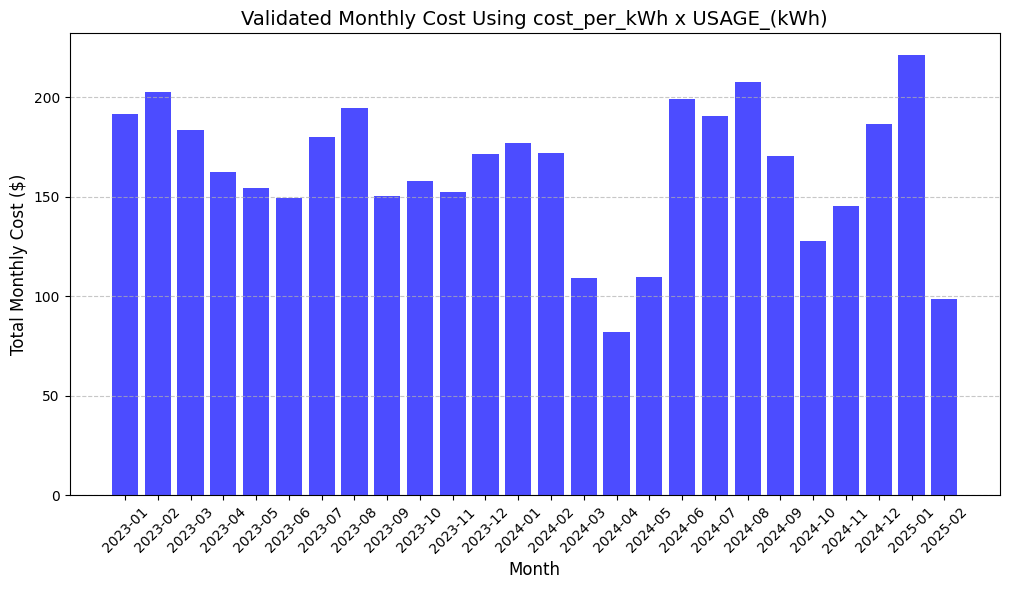

In [ ]:
# Filter out rows with negative USAGE or cost_per_kWh
valid_data = merged_combined_df.loc[
    (merged_combined_df['USAGE_(kWh)'] > 0) & (merged_combined_df['cost_per_kWh'] > 0)
].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Extract year and month for grouping
valid_data['Year-Month'] = valid_data['date_timestamp'].dt.to_period('M')

# Calculate total monthly cost using cost_per_kWh
monthly_cost_valid = valid_data.groupby('Year-Month', as_index=False).apply(
    lambda x: pd.Series({'Total_Cost': (x['cost_per_kWh'] * x['USAGE_(kWh)']).sum()}),
    include_groups=False  # Exclude grouping columns during the operation
)

# Convert 'Year-Month' to string for plotting
monthly_cost_valid['Year-Month'] = monthly_cost_valid['Year-Month'].astype(str)

# Plot the monthly cost
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(monthly_cost_valid['Year-Month'], monthly_cost_valid['Total_Cost'], color='blue', alpha=0.7)

# Formatting
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Monthly Cost ($)', fontsize=12)
plt.title('Validated Monthly Cost Using cost_per_kWh x USAGE_(kWh)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [ ]:
print(merged_combined_df['cost_per_kWh'].describe())


count    105183.000000
mean          0.024011
std           0.057140
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.246575
Name: cost_per_kWh, dtype: float64


#Adding the data for the dashboard

#Create dashboard_filtered and make it start at 1/1/2024

In [ ]:
# Ensure 'date_timestamp' is in datetime format
merged_combined_df['date_timestamp'] = pd.to_datetime(merged_combined_df['date_timestamp'])

# Create a new DataFrame and filter rows
dashboard_filtered = merged_combined_df[merged_combined_df['date_timestamp'] >= '2024-01-08'].copy()  #Filter data to the solar start date.

# Display the first few rows of the new DataFrame to verify
print("Filtered DataFrame (merged_combined_df):")
print(dashboard_filtered.head())
print(f"Number of rows: {len(merged_combined_df)}")


Filtered DataFrame (merged_combined_df):
          date_timestamp  month  day_of_month  hour  is_daylight  solar_angle  \
8927 2024-01-08 00:00:00      1             8   0.0            0   -70.011063   
8928 2024-01-08 01:00:00      1             8   1.0            0   -66.246124   
8929 2024-01-08 02:00:00      1             8   2.0            0   -57.762338   
8930 2024-01-08 03:00:00      1             8   3.0            0   -47.404734   
8931 2024-01-08 04:00:00      1             8   4.0            0   -36.417971   

      solar_azimuth  global_tilted_irradiance  solar_day_count  \
8927       0.987786                       0.0               18   
8928      37.481176                       0.0               18   
8929      61.244512                       0.0               18   
8930      76.587755                       0.0               18   
8931      88.037915                       0.0               18   

      Estimated_Area_Solar_Production  ...  Production  Purchased  \
8927  

In [ ]:
dashboard_filtered.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 96263 entries, 8927 to 105189
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_timestamp                   96263 non-null  datetime64[ns]
 1   month                            96263 non-null  int64         
 2   day_of_month                     96263 non-null  int64         
 3   hour                             96263 non-null  float64       
 4   is_daylight                      96263 non-null  int64         
 5   solar_angle                      96263 non-null  float64       
 6   solar_azimuth                    96263 non-null  float64       
 7   global_tilted_irradiance         96263 non-null  float32       
 8   solar_day_count                  96263 non-null  int64         
 9   Estimated_Area_Solar_Production  96263 non-null  float64       
 10  value                            0 non-null      float64   

#Create Estimated Consumption

In [ ]:
# Step 1: Initialize 'Estimated_Consumption' as 0 for all rows
dashboard_filtered['Estimated_Consumption'] = 0.0

# Step 2: Update 'Estimated_Consumption' for dates greater than the maximum actual date
dashboard_filtered.loc[dashboard_filtered['date_timestamp'] > dashboard_filtered['Solaredge_Update_Date'], 'Estimated_Consumption'] = \
    dashboard_filtered.loc[dashboard_filtered['date_timestamp'] > dashboard_filtered['Solaredge_Update_Date'], 'Predicted_Usage']

# Step 4: Add labels for 'Estimated_Consumption_Label'
dashboard_filtered['Estimated_Consumption_Label'] = 'Actual'  # Default to 'Actual'
dashboard_filtered.loc[dashboard_filtered['date_timestamp'] > max_actual_date, 'Estimated_Consumption_Label'] = 'Predicted'

# Step 5: Drop the 'Predicted_Usage' column
dashboard_filtered = dashboard_filtered.drop(columns=['Predicted_Usage'], errors='ignore')

# Step 6: Verify the changes
dashboard_filtered[['date_timestamp', 'USAGE_(kWh)', 'Consumption', 'Estimated_Consumption', 'Estimated_Consumption_Label']].tail()


date_timestamp  USAGE_(kWh)  Consumption  Estimated_Consumption  \
105185 2034-12-31 19:00:00          0.0          0.0                   3.42   
105186 2034-12-31 20:00:00          0.0          0.0                   2.87   
105187 2034-12-31 21:00:00          0.0          0.0                   1.96   
105188 2034-12-31 22:00:00          0.0          0.0                   1.68   
105189 2034-12-31 23:00:00          0.0          0.0                   0.88   

       Estimated_Consumption_Label  
105185                   Predicted  
105186                   Predicted  
105187                   Predicted  
105188                   Predicted  
105189                   Predicted

In [ ]:
dashboard_filtered[['date_timestamp', 'USAGE_(kWh)', 'Consumption', 'Estimated_Consumption', 'Estimated_Consumption_Label']].head()

date_timestamp  USAGE_(kWh)  Consumption  Estimated_Consumption  \
8927 2024-01-08 00:00:00         0.90         0.90                    0.0   
8928 2024-01-08 01:00:00         0.90         0.90                    0.0   
8929 2024-01-08 02:00:00         3.44         3.44                    0.0   
8930 2024-01-08 03:00:00         0.89         0.89                    0.0   
8931 2024-01-08 04:00:00         1.00         1.00                    0.0   

     Estimated_Consumption_Label  
8927                      Actual  
8928                      Actual  
8929                      Actual  
8930                      Actual  
8931                      Actual

In [ ]:
dashboard_filtered.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 96263 entries, 8927 to 105189
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_timestamp                   96263 non-null  datetime64[ns]
 1   month                            96263 non-null  int64         
 2   day_of_month                     96263 non-null  int64         
 3   hour                             96263 non-null  float64       
 4   is_daylight                      96263 non-null  int64         
 5   solar_angle                      96263 non-null  float64       
 6   solar_azimuth                    96263 non-null  float64       
 7   global_tilted_irradiance         96263 non-null  float32       
 8   solar_day_count                  96263 non-null  int64         
 9   Estimated_Area_Solar_Production  96263 non-null  float64       
 10  value                            0 non-null      float64   

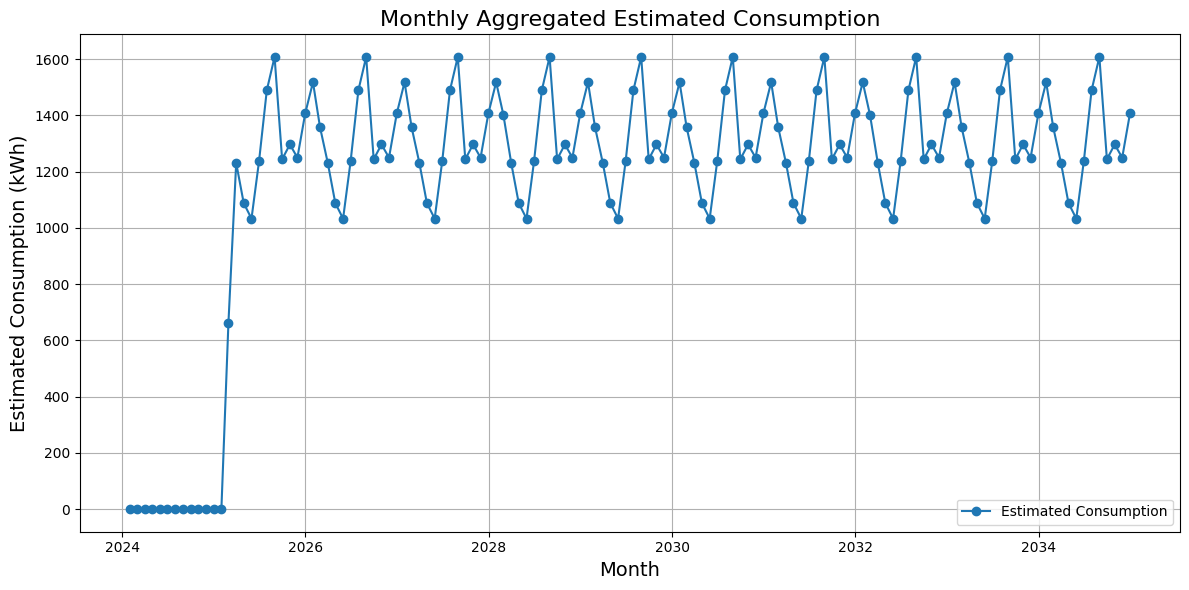

In [ ]:
# Ensure 'date_timestamp' is in datetime format
dashboard_filtered['date_timestamp'] = pd.to_datetime(dashboard_filtered['date_timestamp'])

# Aggregate 'Estimated_Consumption' by month
monthly_aggregated = dashboard_filtered.resample('ME', on='date_timestamp')['Estimated_Consumption'].sum()

# Create the line graph
plt.figure(figsize=(12, 6))
plt.plot(monthly_aggregated.index, monthly_aggregated, marker='o', linestyle='-', label='Estimated Consumption')
plt.title('Monthly Aggregated Estimated Consumption', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Estimated Consumption (kWh)', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the chart
plt.show()


###Create Estimated Production field and set it to 0.

In [ ]:
# Step 1: Initialize 'Estimated_Production' as 0 for all rows
dashboard_filtered['Estimated_Production'] = 0.0

# Step 2: Update 'Estimated_Production' for dates greater than the maximum actual date with the predicted_value
dashboard_filtered.loc[dashboard_filtered['date_timestamp'] > dashboard_filtered['Solaredge_Update_Date'], 'Estimated_Production'] = \
    dashboard_filtered.loc[dashboard_filtered['date_timestamp'] > dashboard_filtered['Solaredge_Update_Date'], 'predicted_value']

# Step 3: Add labels for 'Estimated_Production_Label'
dashboard_filtered['Estimated_Production_Label'] = 'Actual'  # Default to 'Actual'
dashboard_filtered.loc[dashboard_filtered['date_timestamp'] > dashboard_filtered['Solaredge_Update_Date'], 'Estimated_Production_Label'] = 'Predicted'

# Step 4: Verify the changes
dashboard_filtered[['date_timestamp', 'Production', 'Estimated_Production', 'Estimated_Production_Label']].tail()


date_timestamp  Production  Estimated_Production  \
105185 2034-12-31 19:00:00         NaN                   0.0   
105186 2034-12-31 20:00:00         NaN                   0.0   
105187 2034-12-31 21:00:00         NaN                   0.0   
105188 2034-12-31 22:00:00         NaN                   0.0   
105189 2034-12-31 23:00:00         NaN                   0.0   

       Estimated_Production_Label  
105185                  Predicted  
105186                  Predicted  
105187                  Predicted  
105188                  Predicted  
105189                  Predicted

In [ ]:
dashboard_filtered[['date_timestamp', 'Production', 'Estimated_Production', 'Estimated_Production_Label', 'predicted_value', 'is_daylight']].head()

date_timestamp  Production  Estimated_Production  \
8927 2024-01-08 00:00:00         NaN                   0.0   
8928 2024-01-08 01:00:00         NaN                   0.0   
8929 2024-01-08 02:00:00         NaN                   0.0   
8930 2024-01-08 03:00:00         NaN                   0.0   
8931 2024-01-08 04:00:00         NaN                   0.0   

     Estimated_Production_Label  predicted_value  is_daylight  
8927                     Actual              0.0            0  
8928                     Actual              0.0            0  
8929                     Actual              0.0            0  
8930                     Actual              0.0            0  
8931                     Actual              0.0            0

In [ ]:
dashboard_filtered.info(verbose=True,show_counts=True)


<class 'pandas.core.frame.DataFrame'>
Index: 96263 entries, 8927 to 105189
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_timestamp                   96263 non-null  datetime64[ns]
 1   month                            96263 non-null  int64         
 2   day_of_month                     96263 non-null  int64         
 3   hour                             96263 non-null  float64       
 4   is_daylight                      96263 non-null  int64         
 5   solar_angle                      96263 non-null  float64       
 6   solar_azimuth                    96263 non-null  float64       
 7   global_tilted_irradiance         96263 non-null  float32       
 8   solar_day_count                  96263 non-null  int64         
 9   Estimated_Area_Solar_Production  96263 non-null  float64       
 10  value                            0 non-null      float64   

#Calculating Cost per kWh and taking it to the future

In [ ]:
print(dashboard_filtered['cost_per_kWh'].describe())


count    96256.000000
mean         0.013098
std          0.040451
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.166667
Name: cost_per_kWh, dtype: float64


In [ ]:
# Step 1: Calculate the mean of valid (non-zero, non-NaN) cost_per_kWh values
non_zero_mean_cost = dashboard_filtered.loc[dashboard_filtered['cost_per_kWh'] > 0, 'cost_per_kWh'].mean()

# Step 2: Replace 0 and NaN values in cost_per_kWh with the calculated mean
dashboard_filtered['cost_per_kWh'] = dashboard_filtered['cost_per_kWh'].apply(
    lambda x: non_zero_mean_cost if pd.isna(x) or x == 0 else x
)

# Step 3: Verify the changes
print("Updated cost_per_kWh column:")
print(dashboard_filtered['cost_per_kWh'].describe())


Updated cost_per_kWh column:
count    96263.000000
mean         0.130134
std          0.010166
min          0.002899
25%          0.130134
50%          0.130134
75%          0.130134
max          0.166667
Name: cost_per_kWh, dtype: float64


In [ ]:
# Display the first few rows to verify the result
dashboard_filtered[['date_timestamp', 'COST', 'cost_per_kWh']].tail()

date_timestamp  COST  cost_per_kWh
105185 2034-12-31 19:00:00   0.0      0.130134
105186 2034-12-31 20:00:00   0.0      0.130134
105187 2034-12-31 21:00:00   0.0      0.130134
105188 2034-12-31 22:00:00   0.0      0.130134
105189 2034-12-31 23:00:00   0.0      0.130134

In [ ]:
# Step 1: Identify the maximum actual date
max_cost_date = electric_df.loc[electric_df['cost_per_kWh'] != 0, 'date_timestamp'].max()
print("Maximum cost date:", max_cost_date)

# Step 2: Filter historical data (before max_cost_date)
historical_data = dashboard_filtered[dashboard_filtered['date_timestamp'] <= max_cost_date].copy()

# Extract month, day, and hour for historical data
historical_data['month'] = historical_data['date_timestamp'].dt.month
historical_data['day'] = historical_data['date_timestamp'].dt.day
historical_data['hour'] = historical_data['date_timestamp'].dt.hour

# Step 3: Group historical data by month, day, and hour and calculate mean and std for cost_per_kWh
grouped_historical_costs = historical_data.groupby(['month', 'day', 'hour'])['cost_per_kWh'].agg(['mean', 'std']).reset_index()

# Step 4: Filter future data (after max_cost_date)
future_data = dashboard_filtered[dashboard_filtered['date_timestamp'] > max_cost_date].copy()

# Extract month, day, and hour for future data
future_data['month'] = future_data['date_timestamp'].dt.month
future_data['day'] = future_data['date_timestamp'].dt.day
future_data['hour'] = future_data['date_timestamp'].dt.hour

# Handle leap year: Replace February 29 in future data with February 28 from historical data
future_data.loc[(future_data['month'] == 2) & (future_data['day'] == 29), 'day'] = 28

# Step 5: Merge future data with grouped historical costs
future_data = future_data.merge(
    grouped_historical_costs,
    on=['month', 'day', 'hour'],
    how='left',
    suffixes=('', '_historical')
)

# Step 6: Assign historical averages to 'Estimated_Cost_Per_kWh'
# If no match is found, fill missing values with the overall historical mean
historical_mean_cost = historical_data['cost_per_kWh'].mean()
future_data['Estimated_Cost_Per_KWh'] = future_data['mean'].fillna(historical_mean_cost)

# Add variability to the estimated costs using historical standard deviation
future_data['Estimated_Cost_Per_KWh'] += future_data['std'].fillna(0) * np.random.uniform(-0.5, 0.5, size=len(future_data))

# Step 7: Add 'Cost_Label' to indicate whether the row is 'Actual' or 'Estimated'
historical_data['Cost_Label'] = 'Actual'
future_data['Cost_Label'] = 'Estimated'

# Drop unnecessary columns from future_data
future_data.drop(columns=['mean', 'std'], inplace=True, errors='ignore')

# Step 8: Update the original DataFrame by concatenating historical and future data
dashboard_filtered = pd.concat(
    [historical_data, future_data],
    ignore_index=True
).sort_values(by='date_timestamp')

# Drop the extra columns from the future data (if needed)
dashboard_filtered.drop(columns=['month', 'day', 'hour'], errors='ignore', inplace=True)

# Step 9: Verify the changes
print("Updated DataFrame with 'Estimated_Cost_Per_KWh' and 'Cost_Label':")
print(dashboard_filtered[['date_timestamp', 'cost_per_kWh', 'Estimated_Cost_Per_KWh', 'Cost_Label']].tail())


Maximum cost date: 2025-02-14 23:00:00
Updated DataFrame with 'Estimated_Cost_Per_KWh' and 'Cost_Label':
           date_timestamp  cost_per_kWh  Estimated_Cost_Per_KWh Cost_Label
96258 2034-12-31 19:00:00      0.130134                0.126638  Estimated
96259 2034-12-31 20:00:00      0.130134                0.126984  Estimated
96260 2034-12-31 21:00:00      0.130134                0.126168  Estimated
96261 2034-12-31 22:00:00      0.130134                0.127572  Estimated
96262 2034-12-31 23:00:00      0.130134                0.127517  Estimated


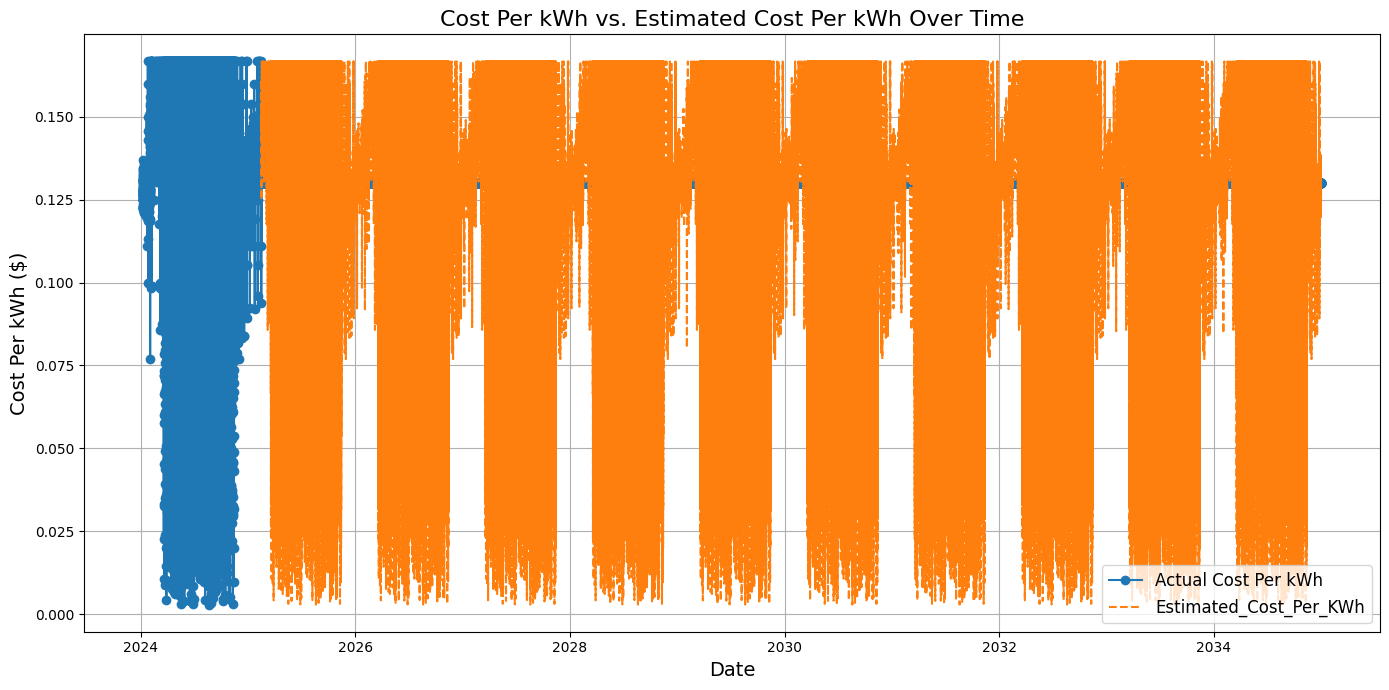

In [ ]:
# Plot the line graph for cost_per_kWh and Estimated_Cost_Per_KWh
plt.figure(figsize=(14, 7))
plt.plot(dashboard_filtered['date_timestamp'], dashboard_filtered['cost_per_kWh'], label='Actual Cost Per kWh', marker='o')
plt.plot(dashboard_filtered['date_timestamp'], dashboard_filtered['Estimated_Cost_Per_KWh'], label='Estimated_Cost_Per_KWh', linestyle='--')
plt.title('Cost Per kWh vs. Estimated Cost Per kWh Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cost Per kWh ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Display the chart
plt.show()


In [ ]:
# Apply absolute value correction to cost_per_kWh
dashboard_filtered['cost_per_kWh'] = dashboard_filtered['cost_per_kWh'].abs()
dashboard_filtered['Estimated_Cost_Per_KWh'] = dashboard_filtered['Estimated_Cost_Per_KWh'].abs()
# Verify the update
print("Updated dashboard_filtered DataFrame with absolute cost_per_kWh:")
print(dashboard_filtered[['date_timestamp', 'cost_per_kWh']].tail())


Updated dashboard_filtered DataFrame with absolute cost_per_kWh:
           date_timestamp  cost_per_kWh
96258 2034-12-31 19:00:00      0.130134
96259 2034-12-31 20:00:00      0.130134
96260 2034-12-31 21:00:00      0.130134
96261 2034-12-31 22:00:00      0.130134
96262 2034-12-31 23:00:00      0.130134


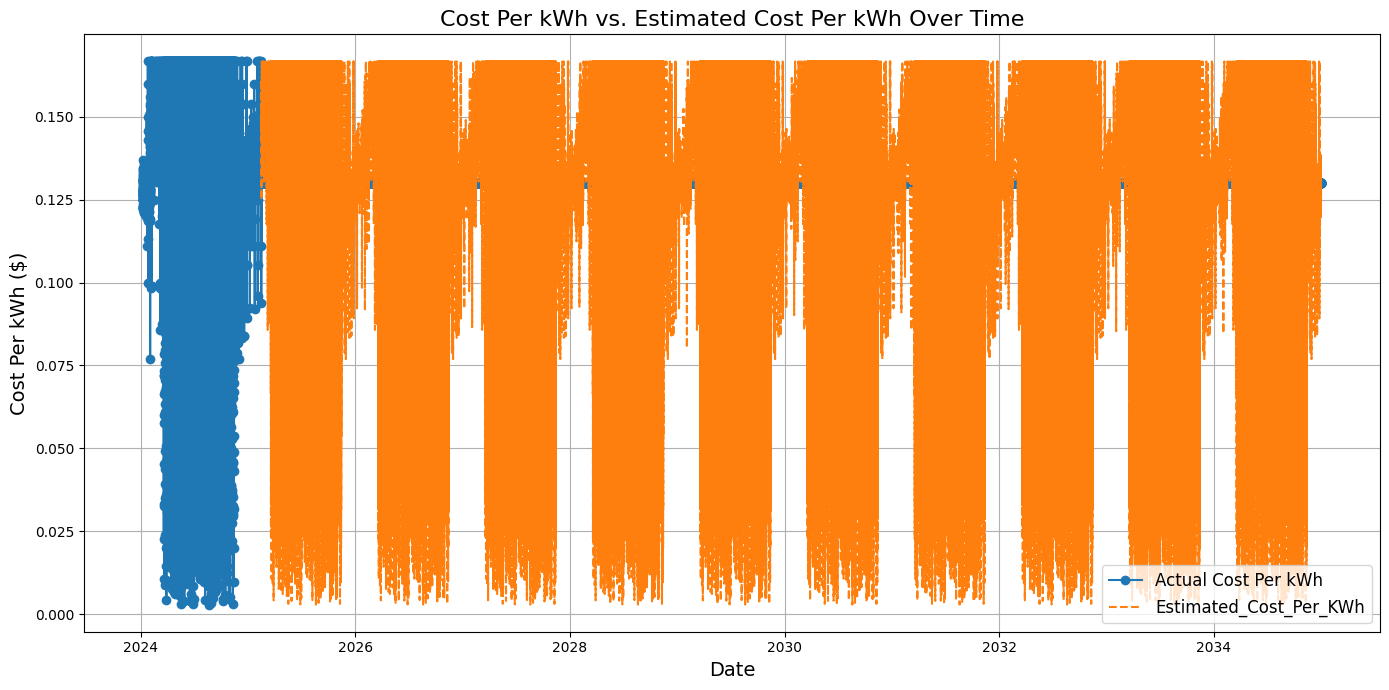

In [ ]:
# Plot the line graph for cost_per_kWh and Estimated_Cost_Per_KWh
plt.figure(figsize=(14, 7))
plt.plot(dashboard_filtered['date_timestamp'], dashboard_filtered['cost_per_kWh'], label='Actual Cost Per kWh', marker='o')
plt.plot(dashboard_filtered['date_timestamp'], dashboard_filtered['Estimated_Cost_Per_KWh'], label='Estimated_Cost_Per_KWh', linestyle='--')
plt.title('Cost Per kWh vs. Estimated Cost Per kWh Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cost Per kWh ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Display the chart
plt.show()


In [ ]:
dashboard_filtered.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96263 entries, 0 to 96262
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_timestamp                   96263 non-null  datetime64[ns]
 1   day_of_month                     96263 non-null  int64         
 2   is_daylight                      96263 non-null  int64         
 3   solar_angle                      96263 non-null  float64       
 4   solar_azimuth                    96263 non-null  float64       
 5   global_tilted_irradiance         96263 non-null  float32       
 6   solar_day_count                  96263 non-null  int64         
 7   Estimated_Area_Solar_Production  96263 non-null  float64       
 8   value                            0 non-null      float64       
 9   predicted_value                  96263 non-null  float64       
 10  YearMonth                        96263 non-null  period[M]

In [ ]:
# Save the updated DataFrame
dashboard_filtered.to_pickle('/content/drive/My Drive/bi_solar_dashboard.pkl')
print("Data for dashboard saved.")

Data for dashboard saved.


#Loading data point and Add new fields for dashboard

In [ ]:
# Load and prepare the data
dashboard_filtered = pd.read_pickle('/content/drive/My Drive/bi_solar_dashboard.pkl')

In [ ]:
dashboard_filtered.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96263 entries, 0 to 96262
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_timestamp                   96263 non-null  datetime64[ns]
 1   day_of_month                     96263 non-null  int64         
 2   is_daylight                      96263 non-null  int64         
 3   solar_angle                      96263 non-null  float64       
 4   solar_azimuth                    96263 non-null  float64       
 5   global_tilted_irradiance         96263 non-null  float32       
 6   solar_day_count                  96263 non-null  int64         
 7   Estimated_Area_Solar_Production  96263 non-null  float64       
 8   value                            0 non-null      float64       
 9   predicted_value                  96263 non-null  float64       
 10  YearMonth                        96263 non-null  period[M]

In [ ]:
display(dashboard_filtered[['date_timestamp', 'Billing_Year', 'Billing_Year_Start', 'Billing_Month', 'Billing_Month_Start', 'Billing_Month_End']])


date_timestamp  Billing_Year Billing_Year_Start Billing_Month  \
0     2024-01-08 00:00:00          2023         2023-03-29       January   
1     2024-01-08 01:00:00          2023         2023-03-29       January   
2     2024-01-08 02:00:00          2023         2023-03-29       January   
3     2024-01-08 03:00:00          2023         2023-03-29       January   
4     2024-01-08 04:00:00          2023         2023-03-29       January   
...                   ...           ...                ...           ...   
96258 2034-12-31 19:00:00          2034         2034-04-01      December   
96259 2034-12-31 20:00:00          2034         2034-04-01      December   
96260 2034-12-31 21:00:00          2034         2034-04-01      December   
96261 2034-12-31 22:00:00          2034         2034-04-01      December   
96262 2034-12-31 23:00:00          2034         2034-04-01      December   

      Billing_Month_Start   Billing_Month_End  
0              2023-12-28 2024-01-28 23:00:00  
1              2023-12-28 2024-01-28 23:00:00  
2              2023-12-28 2024-01-28 23:00:00  
3              2023-12-28 2024-01-28 23:00:00  
4              2023-12-28 2024-01-28 23:00:00  
...                   ...                 ...  
96258          2034-12-06 2035-01-04 23:00:00  
96259          2034-12-06 2035-01-04 23:00:00  
96260          2034-12-06 2035-01-04 23:00:00  
96261          2034-12-06 2035-01-04 23:00:00  
96262          2034-12-06 2035-01-04 23:00:00  

[96263 rows x 6 columns]

#Investigate NaN and 0 values on the key fields - production, consumption, estimated prodction, estimated consumption, estimated cost per kwh, cost per kwh to decide how to handle NaN safely.

###Production and Estimated Production.
- These are both fine to 0 fill the NaN. 0's are naturally happening due to snowfall and around the edges of sunrise and sunset.  NaNs are too few to worry about (2)

In [ ]:
# Identify problematic 0 or NaN values in Production
# Define the condition to filter rows
condition = (
    ((dashboard_filtered['Production'] == 0) | (dashboard_filtered['Production'].isna())) &
    (dashboard_filtered['is_daylight'] == 1) &
    (dashboard_filtered['date_timestamp'] > '2024-01-08') &
    (dashboard_filtered['date_timestamp'] <= dashboard_filtered['Solaredge_Update_Date'])
)

# Filter the DataFrame based on the condition
zero_or_nan_production = dashboard_filtered.loc[condition, ['date_timestamp', 'Production', 'is_daylight']]

# Print the count of rows matching the condition
print(f"Total rows matching the condition: {len(zero_or_nan_production)}")

# Display the filtered data
print(zero_or_nan_production)


Total rows matching the condition: 168
          date_timestamp  Production  is_daylight
7    2024-01-08 07:00:00         NaN            1
8    2024-01-08 08:00:00         NaN            1
16   2024-01-08 16:00:00         0.0            1
31   2024-01-09 07:00:00         0.0            1
32   2024-01-09 08:00:00         0.0            1
...                  ...         ...          ...
8934 2025-01-14 07:00:00         0.0            1
8935 2025-01-14 08:00:00         0.0            1
9544 2025-02-08 17:00:00         0.0            1
9640 2025-02-12 17:00:00         0.0            1
9688 2025-02-14 17:00:00         0.0            1

[168 rows x 3 columns]


In [ ]:
# Identify problematic 0 or NaN values in Estimated Production
# Define the condition to filter rows
condition = (
    ((dashboard_filtered['Estimated_Production'] == 0) | (dashboard_filtered['Estimated_Production'].isna())) &
    (dashboard_filtered['is_daylight'] == 1) &
    (dashboard_filtered['date_timestamp'] > dashboard_filtered['Solaredge_Update_Date'])
)

# Filter the DataFrame based on the condition
zero_or_nan_estimated_production = dashboard_filtered.loc[condition, ['date_timestamp', 'Estimated_Production', 'is_daylight']]

# Print the count of rows matching the condition
print(f"Total rows matching the condition: {len(zero_or_nan_estimated_production)}")

# Display the filtered data
print(zero_or_nan_estimated_production)


Total rows matching the condition: 0
Empty DataFrame
Columns: [date_timestamp, Estimated_Production, is_daylight]
Index: []


###Consumption and Estimated consumption
- These were already 0 filled at an earlier step. Just examining more closely to make sure that didn't create issues.

In [ ]:
solar_update_date = dashboard_filtered['Solaredge_Update_Date'].max()
solar_update_date

Timestamp('2025-02-14 23:00:00')

In [ ]:
# Convert negative Consumption values to absolute values
dashboard_filtered['Consumption'] = dashboard_filtered['Consumption'].abs()
dashboard_filtered['Estimated_Consumption'] = dashboard_filtered['Estimated_Consumption'].abs()

# Define the condition to filter rows where Consumption is 0 or NaN
condition = (
    ((dashboard_filtered['Consumption'] == 0) | (dashboard_filtered['Consumption'].isna())) &
    (dashboard_filtered['date_timestamp'] > '2024-01-08') &
    (dashboard_filtered['date_timestamp'] <= dashboard_filtered['Solaredge_Update_Date'])
)

# Filter the DataFrame based on the condition
zero_or_nan_Consumption = dashboard_filtered.loc[condition, ['date_timestamp', 'Consumption', 'USAGE_(kWh)']]

# Print the count of rows matching the condition
print(f"Total rows matching the condition: {len(zero_or_nan_Consumption)}")

# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)

# Display the filtered data
display(zero_or_nan_Consumption)

# Reset pandas display options to default
pd.reset_option('display.max_rows')


Total rows matching the condition: 0


Empty DataFrame
Columns: [date_timestamp, Consumption, USAGE_(kWh)]
Index: []

In [ ]:
# Identify problematic 0 or NaN values in Estimated Consumption
# Define the condition to filter rows
condition = (
    ((dashboard_filtered['Estimated_Consumption'] == 0) | (dashboard_filtered['Estimated_Consumption'].isna())) &
    (dashboard_filtered['date_timestamp'] > dashboard_filtered['Solaredge_Update_Date'])
)

# Filter the DataFrame based on the condition
zero_or_nan_estimated_consumption = dashboard_filtered.loc[condition, ['date_timestamp', 'Estimated_Consumption']]

# Print the count of rows matching the condition
print(f"Total rows matching the condition: {len(zero_or_nan_estimated_consumption)}")

# Display the filtered data
print(zero_or_nan_estimated_consumption)


Total rows matching the condition: 10
           date_timestamp  Estimated_Consumption
10297 2025-03-12 02:00:00                    NaN
19057 2026-03-12 02:00:00                    NaN
27817 2027-03-12 02:00:00                    NaN
36601 2028-03-12 02:00:00                    NaN
45361 2029-03-12 02:00:00                    NaN
54121 2030-03-12 02:00:00                    NaN
62881 2031-03-12 02:00:00                    NaN
71665 2032-03-12 02:00:00                    NaN
80425 2033-03-12 02:00:00                    NaN
89185 2034-03-12 02:00:00                    NaN


In [ ]:
# Find the value of Consumption on March 12, 2024, at 2:00 AM
reference_value = dashboard_filtered.loc[
    (dashboard_filtered['date_timestamp'] == '2024-03-12 02:00:00'), 'Consumption'
].values[0]

# Define the condition to locate rows with NaN values for Estimated_Consumption on March 12 at 2:00 AM
condition = (
    (dashboard_filtered['date_timestamp'].dt.month == 3) &
    (dashboard_filtered['date_timestamp'].dt.day == 12) &
    (dashboard_filtered['date_timestamp'].dt.hour == 2) &
    (dashboard_filtered['Estimated_Consumption'].isna())
)

# Fill NaN values with the reference value
dashboard_filtered.loc[condition, 'Estimated_Consumption'] = reference_value

# Verify the changes
updated_rows = dashboard_filtered.loc[condition, ['date_timestamp', 'Estimated_Consumption']]
print("Updated rows:")
print(updated_rows)


Updated rows:
           date_timestamp  Estimated_Consumption
10297 2025-03-12 02:00:00                   0.93
19057 2026-03-12 02:00:00                   0.93
27817 2027-03-12 02:00:00                   0.93
36601 2028-03-12 02:00:00                   0.93
45361 2029-03-12 02:00:00                   0.93
54121 2030-03-12 02:00:00                   0.93
62881 2031-03-12 02:00:00                   0.93
71665 2032-03-12 02:00:00                   0.93
80425 2033-03-12 02:00:00                   0.93
89185 2034-03-12 02:00:00                   0.93


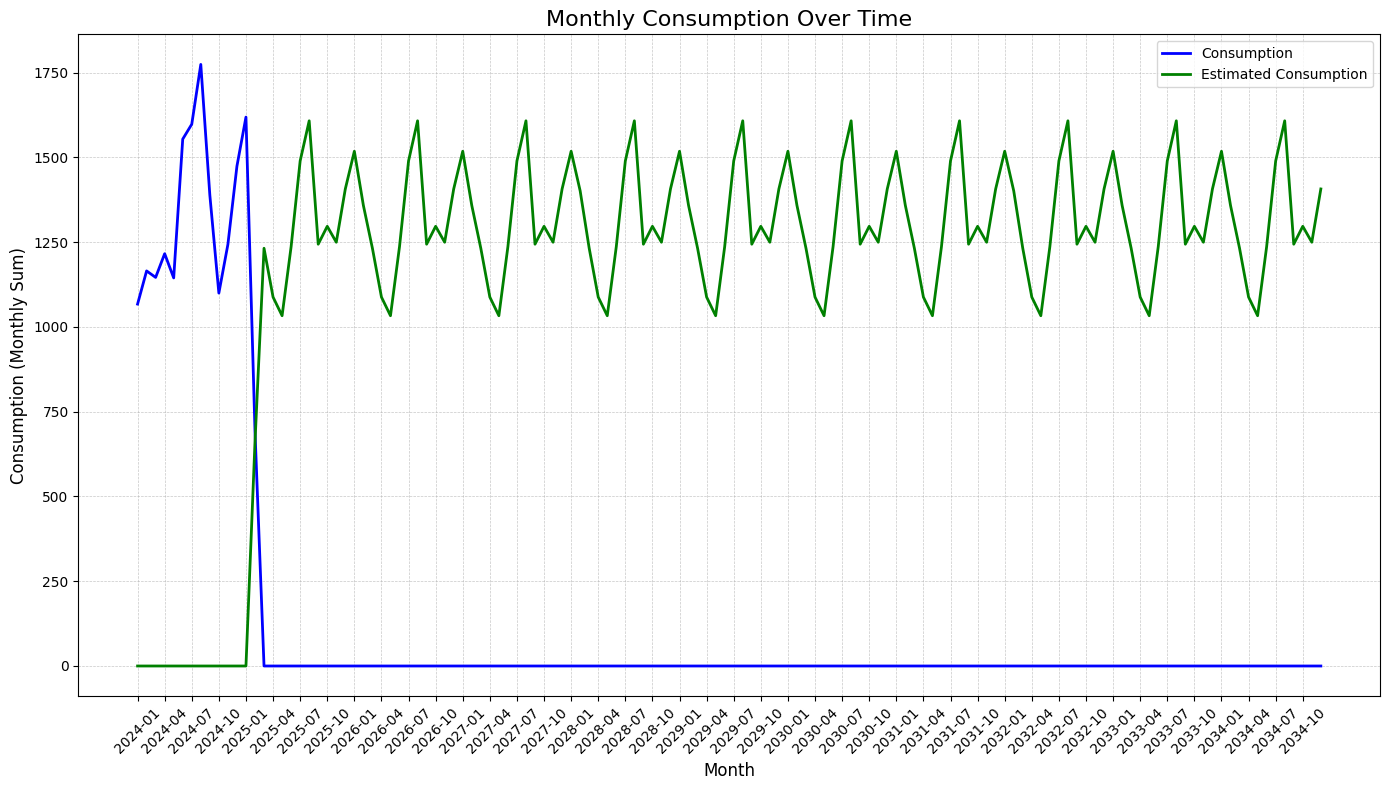

In [ ]:
# Step 1: Ensure the date column is in datetime format and create a monthly aggregation
dashboard_filtered['month'] = pd.to_datetime(dashboard_filtered['date_timestamp']).dt.to_period('M')

# Step 2: Aggregate data at the monthly level
monthly_consumption = dashboard_filtered.groupby(['month']).agg({
    'Consumption': 'sum',
    'Estimated_Consumption': 'sum'
}).reset_index()

# Step 3: Plot Consumption and Estimated Consumption
plt.figure(figsize=(14, 8))  # Wider figure for better readability

# Plot Consumption
plt.plot(
    monthly_consumption['month'].astype(str),
    monthly_consumption['Consumption'],
    label='Consumption',
    color='blue',
    linewidth=2
)

# Plot Estimated Consumption
plt.plot(
    monthly_consumption['month'].astype(str),
    monthly_consumption['Estimated_Consumption'],
    label='Estimated Consumption',
    color='green',
    linewidth=2
)

# Improve x-axis readability
plt.xticks(
    ticks=range(0, len(monthly_consumption['month']), 3),  # Show every third month
    labels=monthly_consumption['month'].astype(str).iloc[::3],  # Label every third month
    rotation=45
)

# Add gridlines
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Month', fontsize=12)
plt.ylabel('Consumption (Monthly Sum)', fontsize=12)
plt.title('Monthly Consumption Over Time', fontsize=16)
plt.legend(fontsize=10)

# Tight layout for cleaner output
plt.tight_layout()

# Display the plot
plt.show()


###Cost Per kWh and Estimated cost per kWh

In [ ]:
# Identify problematic 0 or NaN values in cost_per_kWh
# Define the condition to filter rows
condition = (
    ((dashboard_filtered['cost_per_kWh'] == 0) | (dashboard_filtered['cost_per_kWh'].isna())) &
    (dashboard_filtered['date_timestamp'] > '2024-01-08') &
    (dashboard_filtered['date_timestamp'] <= dashboard_filtered['Solaredge_Update_Date'])
)

# Filter the DataFrame based on the condition
zero_or_nan_cost_per_kWh = dashboard_filtered.loc[condition, ['date_timestamp', 'cost_per_kWh']]

# Print the count of rows matching the condition
print(f"Total rows matching the condition: {len(zero_or_nan_cost_per_kWh)}")

# Display the filtered data
print(zero_or_nan_cost_per_kWh)


Total rows matching the condition: 0
Empty DataFrame
Columns: [date_timestamp, cost_per_kWh]
Index: []


In [ ]:
# Identify problematic 0 or NaN values in Estimated_Cost_Per_KWh
# Define the condition to filter rows
condition = (
    ((dashboard_filtered['Estimated_Cost_Per_KWh'] == 0) | (dashboard_filtered['Estimated_Cost_Per_KWh'].isna())) &
    (dashboard_filtered['date_timestamp'] > dashboard_filtered['Solaredge_Update_Date'])
)

# Filter the DataFrame based on the condition
zero_or_nan_estimated_cost_per_kWh = dashboard_filtered.loc[condition, ['date_timestamp', 'Estimated_Cost_Per_KWh']]

# Print the count of rows matching the condition
print(f"Total rows matching the condition: {len(zero_or_nan_estimated_cost_per_kWh)}")

# Display the filtered data
print(zero_or_nan_estimated_cost_per_kWh)


Total rows matching the condition: 0
Empty DataFrame
Columns: [date_timestamp, Estimated_Cost_Per_KWh]
Index: []


In [ ]:
#Now that this has been checked I'm good with 0 fill here.
# **Fill missing values in critical columns**
dashboard_filtered['Production'] = dashboard_filtered['Production'].fillna(0)
dashboard_filtered['Consumption'] = dashboard_filtered['Consumption'].fillna(0)
dashboard_filtered['Estimated_Production'] = dashboard_filtered['Estimated_Production'].fillna(0)
dashboard_filtered['Estimated_Consumption'] = dashboard_filtered['Estimated_Consumption'].fillna(0)
dashboard_filtered['Estimated_Cost_Per_KWh'] = dashboard_filtered['Estimated_Cost_Per_KWh'].fillna(
    dashboard_filtered['cost_per_kWh'])
dashboard_filtered['Estimated_Cost_Per_KWh'] = dashboard_filtered['Estimated_Cost_Per_KWh'].fillna(0)
dashboard_filtered['cost_per_kWh'] = dashboard_filtered['cost_per_kWh'].fillna(0)

#Calculating Excess Credits, Savings, Remaining Balance
- Net Metering for Com Ed in Illinois for systems that were installed prior to January 2025 have these rules:
- Excess production is not purchased, it is applied to to future billing
- Any excess credits that are not used by April 30 do not roll over to the next billing year

##Calculate Immediate Actual Savings and Estimated Savings

In [ ]:
# **Calculate 'Immediate_Savings' and 'Estimated_Immediate_Savings' using min(Production, Consumption)**
dashboard_filtered['Immediate_Savings'] = dashboard_filtered[['Production', 'Consumption']].min(axis=1) * \
    dashboard_filtered['Estimated_Cost_Per_KWh']
dashboard_filtered['Estimated_Immediate_Savings'] = dashboard_filtered[['Estimated_Production', 'Estimated_Consumption']].min(axis=1) * \
    dashboard_filtered['Estimated_Cost_Per_KWh']

# **Calculate 'Immediate_Offset' and 'Estimated_Immediate_Offset' before cost conversion**
dashboard_filtered['Immediate_Offset'] = dashboard_filtered[['Production', 'Consumption']].min(axis=1)
dashboard_filtered['Estimated_Immediate_Offset'] = dashboard_filtered[['Estimated_Production', 'Estimated_Consumption']].min(axis=1)

# **Ensure no negative values**
dashboard_filtered['Immediate_Savings'] = dashboard_filtered['Immediate_Savings'].clip(lower=0)
dashboard_filtered['Estimated_Immediate_Savings'] = dashboard_filtered['Estimated_Immediate_Savings'].clip(lower=0)
dashboard_filtered['Immediate_Offset'] = dashboard_filtered['Immediate_Offset'].clip(lower=0)
dashboard_filtered['Estimated_Immediate_Offset'] = dashboard_filtered['Estimated_Immediate_Offset'].clip(lower=0)


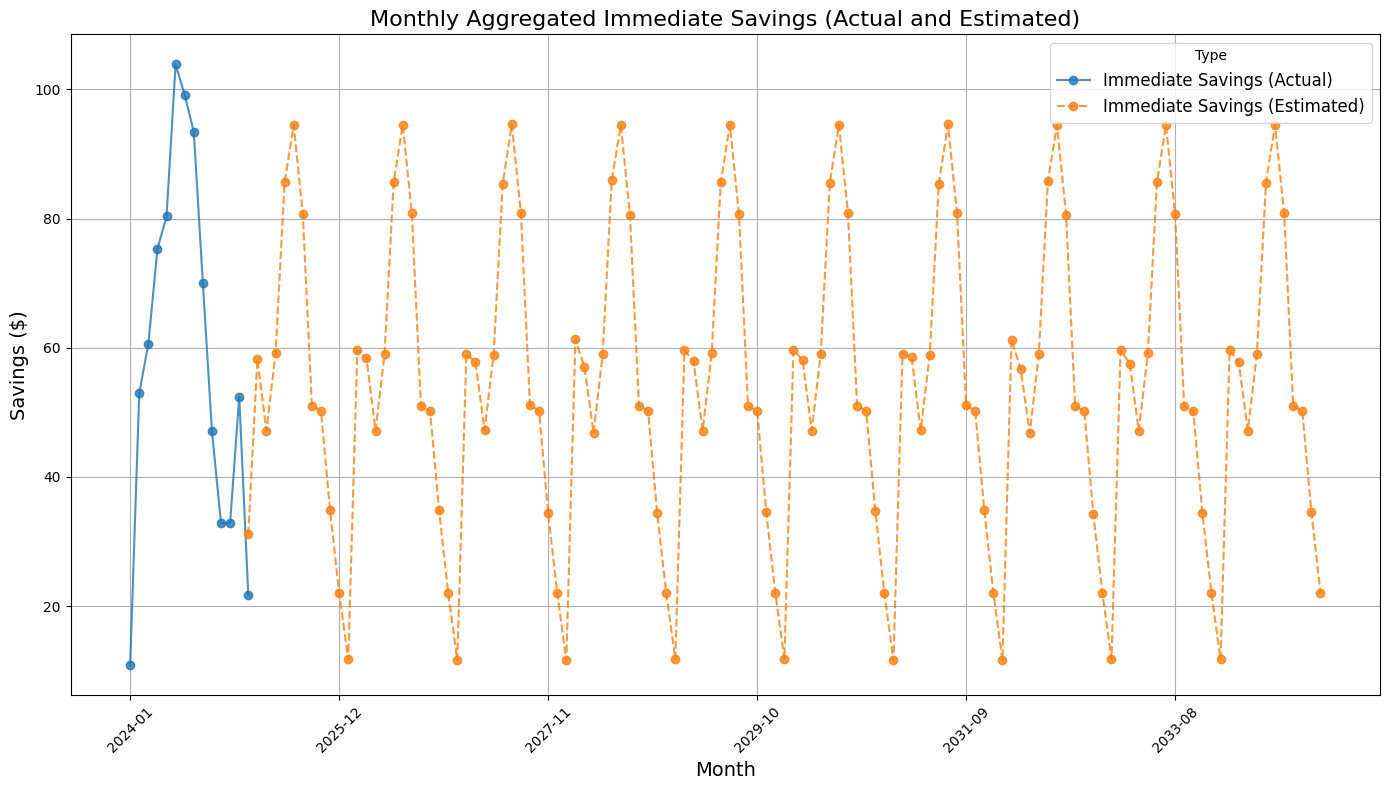

In [ ]:
# Ensure 'date_timestamp' and 'Solaredge_Update_Date' are datetime columns
if not pd.api.types.is_datetime64_any_dtype(dashboard_filtered['date_timestamp']):
    dashboard_filtered['date_timestamp'] = pd.to_datetime(dashboard_filtered['date_timestamp'])

if not pd.api.types.is_datetime64_any_dtype(dashboard_filtered['Solaredge_Update_Date']):
    dashboard_filtered['Solaredge_Update_Date'] = pd.to_datetime(dashboard_filtered['Solaredge_Update_Date'])

# Get the latest Solaredge_Update_Date
latest_solar_update_date = dashboard_filtered['Solaredge_Update_Date'].max()

# Create a 'YearMonth' column for monthly aggregation
dashboard_filtered['YearMonth'] = dashboard_filtered['date_timestamp'].dt.to_period('M').astype(str)

# Mask data for aggregation based on Solaredge_Update_Date
before_update_mask = dashboard_filtered['date_timestamp'] <= latest_solar_update_date
after_update_mask = dashboard_filtered['date_timestamp'] > latest_solar_update_date

# Aggregate data for actual and estimated savings
monthly_actual = dashboard_filtered[before_update_mask].groupby('YearMonth', as_index=False).agg({
    'Immediate_Savings': 'sum'
})
monthly_estimated = dashboard_filtered[after_update_mask].groupby('YearMonth', as_index=False).agg({
    'Estimated_Immediate_Savings': 'sum'
})

# Plot the data
plt.figure(figsize=(14, 8))

# Actual Immediate Savings (before Solar_Update_Date)
plt.plot(
    monthly_actual['YearMonth'],
    monthly_actual['Immediate_Savings'],
    label='Immediate Savings (Actual)',
    marker='o',
    linestyle='-',
    alpha=0.8
)

# Estimated Immediate Savings (after Solar_Update_Date)
plt.plot(
    monthly_estimated['YearMonth'],
    monthly_estimated['Estimated_Immediate_Savings'],
    label='Immediate Savings (Estimated)',
    marker='o',
    linestyle='--',
    alpha=0.8
)

# Chart styling
plt.title('Monthly Aggregated Immediate Savings (Actual and Estimated)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Savings ($)', fontsize=14)

# Dynamically adjust x-ticks
tick_spacing = max(1, len(monthly_actual) + len(monthly_estimated) // 12)
all_year_months = pd.concat([monthly_actual['YearMonth'], monthly_estimated['YearMonth']]).drop_duplicates()
plt.xticks(
    ticks=range(0, len(all_year_months), tick_spacing),
    labels=all_year_months.iloc[::tick_spacing],
    rotation=45
)

plt.legend(title='Type', fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
def calculate_unified_values(row):
    # Ensure values are non-negative
    valid_consumption = abs(row['Consumption']) if pd.notna(row['Consumption']) else 0
    valid_estimated_consumption = abs(row['Estimated_Consumption']) if pd.notna(row['Estimated_Consumption']) else 0

    if row['date_timestamp'] <= row['Solaredge_Update_Date']:
        # ✅ Ensure shortfall is 0 when Consumption is 0
        shortfall = max(valid_consumption - row['Production'], 0) if valid_consumption > 0 else 0
        excess_credits = max(row['Production'] - valid_consumption, 0)

        shortfall_cost = shortfall * (row['cost_per_kWh'] if pd.notna(row['cost_per_kWh']) else 0)
        excess_cost = excess_credits * (row['cost_per_kWh'] if pd.notna(row['cost_per_kWh']) else 0)

    else:
        # ✅ Ensure shortfall is 0 when Estimated_Consumption is 0
        shortfall = max(valid_estimated_consumption - row['Estimated_Production'], 0) if valid_estimated_consumption > 0 else 0
        excess_credits = max(row['Estimated_Production'] - valid_estimated_consumption, 0)

        shortfall_cost = shortfall * row['Estimated_Cost_Per_KWh']
        excess_cost = excess_credits * row['Estimated_Cost_Per_KWh']

    return pd.Series({
        'Unified_Hourly_Excess_Credits': excess_credits,
        'Unified_Hourly_Shortfall': shortfall,  # ✅ Shortfall will be 0 when it should be
        'Unified_Hourly_Shortfall_Cost': shortfall_cost,
        'Unified_Hourly_Excess_Cost': excess_cost
    })

# Apply the function row-wise to update dashboard_filtered
dashboard_filtered[[
    'Unified_Hourly_Excess_Credits',
    'Unified_Hourly_Shortfall',
    'Unified_Hourly_Shortfall_Cost',
    'Unified_Hourly_Excess_Cost'
]] = dashboard_filtered.apply(calculate_unified_values, axis=1)


In [ ]:
# Ensure Corrected_Consumption selects the right consumption value (actual or estimated) based on Solaredge_Update_Date
dashboard_filtered['Corrected_Consumption'] = dashboard_filtered.apply(
    lambda row: row['Consumption'] if row['date_timestamp'] <= row['Solaredge_Update_Date']
    else row['Estimated_Consumption'], axis=1
)

# Find rows where shortfall exceeds the correctly determined consumption
invalid_shortfall_cases = dashboard_filtered.query(
    "Unified_Hourly_Shortfall > Corrected_Consumption"
)[[
    'date_timestamp', 'Unified_Hourly_Shortfall', 'Corrected_Consumption',
    'Production', 'Consumption', 'Estimated_Production', 'Estimated_Consumption', 'Solaredge_Update_Date'
]]

# Display results
if not invalid_shortfall_cases.empty:
    print("⚠️ Validation Failed: Unified_Hourly_Shortfall is greater than Corrected Consumption!")
    print(invalid_shortfall_cases)
else:
    print("✅ Validation Passed: Unified_Hourly_Shortfall is within expected consumption limits.")


✅ Validation Passed: Unified_Hourly_Shortfall is within expected consumption limits.


In [ ]:
dashboard_filtered

date_timestamp  day_of_month  is_daylight  solar_angle  \
0     2024-01-08 00:00:00             8            0   -70.011063   
1     2024-01-08 01:00:00             8            0   -66.246124   
2     2024-01-08 02:00:00             8            0   -57.762338   
3     2024-01-08 03:00:00             8            0   -47.404734   
4     2024-01-08 04:00:00             8            0   -36.417971   
...                   ...           ...          ...          ...   
96258 2034-12-31 19:00:00            31            0   -26.893894   
96259 2034-12-31 20:00:00            31            0   -37.962894   
96260 2034-12-31 21:00:00            31            0   -48.934295   
96261 2034-12-31 22:00:00            31            0   -59.239961   
96262 2034-12-31 23:00:00            31            0   -67.526769   

       solar_azimuth  global_tilted_irradiance  solar_day_count  \
0           0.987786                       0.0               18   
1          37.481176                       0.0               18   
2          61.244512                       0.0               18   
3          76.587755                       0.0               18   
4          88.037915                       0.0               18   
...              ...                       ...              ...   
96258     262.454319                       0.0               10   
96259     272.252301                       0.0               10   
96260     283.851877                       0.0               10   
96261     299.669257                       0.0               10   
96262     324.736302                       0.0               10   

       Estimated_Area_Solar_Production  value  predicted_value  ...    month  \
0                                0.000    NaN              0.0  ...  2024-01   
1                                0.000    NaN              0.0  ...  2024-01   
2                                0.000    NaN              0.0  ...  2024-01   
3                                0.000    NaN              0.0  ...  2024-01   
4                                0.000    NaN              0.0  ...  2024-01   
...                                ...    ...              ...  ...      ...   
96258                            0.107    NaN              0.0  ...  2034-12   
96259                            0.000    NaN              0.0  ...  2034-12   
96260                            0.000    NaN              0.0  ...  2034-12   
96261                            0.000    NaN              0.0  ...  2034-12   
96262                            0.000    NaN              0.0  ...  2034-12   

      Immediate_Savings  Estimated_Immediate_Savings  Immediate_Offset  \
0                   0.0                          0.0               0.0   
1                   0.0                          0.0               0.0   
2                   0.0                          0.0               0.0   
3                   0.0                          0.0               0.0   
4                   0.0                          0.0               0.0   
...                 ...                          ...               ...   
96258               0.0                          0.0               0.0   
96259               0.0                          0.0               0.0   
96260               0.0                          0.0               0.0   
96261               0.0                          0.0               0.0   
96262               0.0                          0.0               0.0   

       Estimated_Immediate_Offset  Unified_Hourly_Excess_Credits  \
0                             0.0                            0.0   
1                             0.0                            0.0   
2                             0.0                            0.0   
3                             0.0                            0.0   
4                             0.0                            0.0   
...                           ...                            ...   
96258                         0.0                  

In [ ]:
# Save the updated DataFrame
dashboard_filtered.to_pickle('/content/drive/My Drive/bi_solar_dashboard_pre_excess_credits.pkl')
print("Data for dashboard saved.")

Data for dashboard saved.


In [ ]:
# Load the updated DataFrame
dashboard_filtered = pd.read_pickle('/content/drive/My Drive/bi_solar_dashboard_pre_excess_credits.pkl')
print("Data for dashboard saved.")

Data for dashboard saved.


In [ ]:
dashboard_filtered.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96263 entries, 0 to 96262
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_timestamp                   96263 non-null  datetime64[ns]
 1   day_of_month                     96263 non-null  int64         
 2   is_daylight                      96263 non-null  int64         
 3   solar_angle                      96263 non-null  float64       
 4   solar_azimuth                    96263 non-null  float64       
 5   global_tilted_irradiance         96263 non-null  float32       
 6   solar_day_count                  96263 non-null  int64         
 7   Estimated_Area_Solar_Production  96263 non-null  float64       
 8   value                            0 non-null      float64       
 9   predicted_value                  96263 non-null  float64       
 10  YearMonth                        96263 non-null  object   

##Create a function to create the Excess_Credits_Cumulative field.

In [ ]:
def compute_excess_and_shortfall_offsets(df):
    # First-pass columns
    df['First_Pass_Excess_Credits_Cumulative'] = 0.0
    df['First_Pass_Immediate_Shortfall_Offset'] = 0.0
    df['First_Pass_End_Of_Month_Shortfall_Offset'] = 0.0
    df['First_Pass_Excess_Used_To_Offset_PriorShortfalls'] = 0.0
    df['First_Pass_Excess_Credits_Cumulative_Before_Offset'] = 0.0
    df['First_Pass_Excess_Credits_Cumulative_After_Offset'] = 0.0
    df['First_Pass_Remaining_Shortfall'] = 0.0
    df['First_Pass_Month_End_Excess_Credits_Cumulative'] = 0.0

    # Second-pass columns
    df['Second_Pass_Excess_Cumulative_Final_Before_Adjustment'] = 0.0
    df['Second_Pass_Excess_Cumulative_Final'] = 0.0
    df['Second_Pass_End_Of_Month_Shortfall_Offset'] = 0.0
    df['Second_Pass_Final_Remaining_Shortfall'] = 0.0
    df['Second_Pass_Month_End_Excess_Credits_Cumulative_Final'] = 0.0

    cumulative_excess = 0
    previous_month_excess = 0  # Track excess from previous billing month

    unique_billing_months = df[['Billing_Month_Start', 'Billing_Month_End']].drop_duplicates()
    for i, (month_start, month_end) in unique_billing_months.iterrows():
        month_df = df[(df['Billing_Month_Start'] == month_start) & (df['Billing_Month_End'] == month_end)]

        for idx in month_df.index:
            row = df.loc[idx]
            excess = row['Unified_Hourly_Excess_Credits']
            shortfall = row['Unified_Hourly_Shortfall']

            # If new billing year (April start), reset excess to 0
            if row['date_timestamp'].month == 4 and row['date_timestamp'].day == 1 and row['date_timestamp'].hour == 0:
                previous_month_excess = 0

            # Carry forward previous month's final excess before any shortfall subtraction
            if idx == month_df.index[0]:
                if i > 0:
                    cumulative_excess = previous_month_excess  # Start directly from previous excess
                else:
                    cumulative_excess = 0  # First billing month starts fresh

            cumulative_excess += excess  # Add new excess credits
            df.at[idx, 'First_Pass_Excess_Credits_Cumulative_Before_Offset'] = cumulative_excess

            # Apply immediate offset
            if shortfall > 0 and cumulative_excess > 0:
                offset_amount = min(shortfall, cumulative_excess)
                df.at[idx, 'First_Pass_Immediate_Shortfall_Offset'] = offset_amount
                cumulative_excess -= offset_amount
                df.at[idx, 'First_Pass_Excess_Used_To_Offset_PriorShortfalls'] += offset_amount
                df.at[idx, 'First_Pass_Remaining_Shortfall'] = shortfall - offset_amount
            else:
                df.at[idx, 'First_Pass_Remaining_Shortfall'] = shortfall

            df.at[idx, 'First_Pass_Excess_Credits_Cumulative'] = cumulative_excess
            df.at[idx, 'First_Pass_Excess_Credits_Cumulative_After_Offset'] = cumulative_excess

            # Store month-end cumulative excess credits
            if row['date_timestamp'] == month_end:
                df.at[idx, 'First_Pass_Month_End_Excess_Credits_Cumulative'] = cumulative_excess
                df.at[idx, 'Second_Pass_Month_End_Excess_Credits_Cumulative_Final'] = cumulative_excess  # Placeholder, will be updated after second pass

        # Second pass: Use final month-end excess to offset shortfalls progressively
        month_end_excess_final = df.at[month_df.index[-1], 'Second_Pass_Month_End_Excess_Credits_Cumulative_Final']

        for idx in month_df.index:
            if idx == month_df.index[0]:
                df.at[idx, 'Second_Pass_Excess_Cumulative_Final_Before_Adjustment'] = month_end_excess_final

            previous_excess = df.at[idx - 1, 'Second_Pass_Excess_Cumulative_Final'] if idx > month_df.index[0] else month_end_excess_final
            df.at[idx, 'Second_Pass_Excess_Cumulative_Final_Before_Adjustment'] = previous_excess

            if df.at[idx, 'First_Pass_Remaining_Shortfall'] > 0 and previous_excess > 0:
                end_of_month_offset = min(df.at[idx, 'First_Pass_Remaining_Shortfall'], previous_excess)
                df.at[idx, 'Second_Pass_End_Of_Month_Shortfall_Offset'] = end_of_month_offset
                df.at[idx, 'Second_Pass_Final_Remaining_Shortfall'] = df.at[idx, 'First_Pass_Remaining_Shortfall'] - end_of_month_offset
                previous_excess -= end_of_month_offset
            else:
                # If no excess was available, keep the First Pass remaining shortfall
                df.at[idx, 'Second_Pass_Final_Remaining_Shortfall'] = df.at[idx, 'First_Pass_Remaining_Shortfall']

            df.at[idx, 'Second_Pass_Excess_Cumulative_Final'] = previous_excess

        # Ensure the last row's Second_Pass_Month_End_Excess_Credits_Cumulative_Final matches Second_Pass_Excess_Cumulative_Final
        df.at[month_df.index[-1], 'Second_Pass_Month_End_Excess_Credits_Cumulative_Final'] = df.at[month_df.index[-1], 'Second_Pass_Excess_Cumulative_Final']

        # Carry forward the final excess for the next month, but only after second pass
        previous_month_excess = round(df.at[month_df.index[-1], 'Second_Pass_Excess_Cumulative_Final'], 2)

    return df


In [ ]:
dashboard_filtered2 = compute_excess_and_shortfall_offsets(dashboard_filtered.copy())

In [ ]:
# ✅ Define the columns to include in the export (ordered for logical validation)
columns_to_export = [
    'date_timestamp',
    'Billing_Month_Start',
    'Billing_Month_End',
    'Billing_Year',
    'Unified_Hourly_Excess_Credits',
    'Unified_Hourly_Shortfall',

    # First-pass columns (before final adjustment)
    'First_Pass_Excess_Credits_Cumulative_Before_Offset',
    'First_Pass_Immediate_Shortfall_Offset',
    'First_Pass_Excess_Used_To_Offset_PriorShortfalls',
    'First_Pass_Remaining_Shortfall',
    'First_Pass_End_Of_Month_Shortfall_Offset',
    'First_Pass_Excess_Credits_Cumulative_After_Offset',
    'First_Pass_Month_End_Excess_Credits_Cumulative',

    # Second-pass columns (final stage)
    'Second_Pass_Excess_Cumulative_Final_Before_Adjustment',
    'Second_Pass_End_Of_Month_Shortfall_Offset',
    'Second_Pass_Final_Remaining_Shortfall',
    'Second_Pass_Excess_Cumulative_Final',
    'Second_Pass_Month_End_Excess_Credits_Cumulative_Final'
]

# ✅ Filter for January 2023 (Billing Month)
january_2023_df = dashboard_filtered2[
    (dashboard_filtered2['Billing_Month'] == 'January') &
    (dashboard_filtered2['Billing_Year'] == 2023)
][columns_to_export]  # Select only the necessary columns

display(january_2023_df)


date_timestamp Billing_Month_Start   Billing_Month_End  Billing_Year  \
0   2024-01-08 00:00:00          2023-12-28 2024-01-28 23:00:00          2023   
1   2024-01-08 01:00:00          2023-12-28 2024-01-28 23:00:00          2023   
2   2024-01-08 02:00:00          2023-12-28 2024-01-28 23:00:00          2023   
3   2024-01-08 03:00:00          2023-12-28 2024-01-28 23:00:00          2023   
4   2024-01-08 04:00:00          2023-12-28 2024-01-28 23:00:00          2023   
..                  ...                 ...                 ...           ...   
499 2024-01-28 19:00:00          2023-12-28 2024-01-28 23:00:00          2023   
500 2024-01-28 20:00:00          2023-12-28 2024-01-28 23:00:00          2023   
501 2024-01-28 21:00:00          2023-12-28 2024-01-28 23:00:00          2023   
502 2024-01-28 22:00:00          2023-12-28 2024-01-28 23:00:00          2023   
503 2024-01-28 23:00:00          2023-12-28 2024-01-28 23:00:00          2023   

     Unified_Hourly_Excess_Credits  Unified_Hourly_Shortfall  \
0                              0.0                      0.90   
1                              0.0                      0.90   
2                              0.0                      3.44   
3                              0.0                      0.89   
4                              0.0                      1.00   
..                             ...                       ...   
499                            0.0                      1.53   
500                            0.0                      1.56   
501                            0.0                      1.78   
502                            0.0                      2.45   
503                            0.0                      1.52   

     First_Pass_Excess_Credits_Cumulative_Before_Offset  \
0                                                  0.0    
1                                                  0.0    
2                                                  0.0    
3                                                  0.0    
4                                                  0.0    
..                                                 ...    
499                                                0.0    
500                                                0.0    
501                                                0.0    
502                                                0.0    
503                                                0.0    

     First_Pass_Immediate_Shortfall_Offset  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
..                                     ...   
499                                    0.0   
500                                    0.0   
501                                    0.0   
502                                    0.0   
503                                    0.0   

     First_Pass_Excess_Used_To_Offset_PriorShortfalls  \
0                                                 0.0   
1                                                 0.0   
2                                                 0.0   
3                                                 0.0   
4                                                 0.0   
..                                                ...   
499                                               0.0   
500                                               0.0   
501                                               0.0   
502                                               0.0   
503                                               0.0   

     First_Pass_Remaining_Shortfall  First_Pass_End_Of_Month_Shortfall_Offset  \
0                              0.90                                       0.0   
1                              0.90                                       0.0   
2                              3.44                                       0.0

In [ ]:
from google.colab import files

# ✅ Define the columns to include in the export
columns_to_export = [
    'date_timestamp',
    'Billing_Month_Start',
    'Billing_Month_End',
    'Billing_Year',
    'Unified_Hourly_Excess_Credits',
    'Unified_Hourly_Shortfall',

    # First-pass columns (before final adjustment)
    'First_Pass_Excess_Credits_Cumulative_Before_Offset',
    'First_Pass_Immediate_Shortfall_Offset',
    'First_Pass_Excess_Used_To_Offset_PriorShortfalls',
    'First_Pass_Remaining_Shortfall',
    'First_Pass_End_Of_Month_Shortfall_Offset',
    'First_Pass_Excess_Credits_Cumulative_After_Offset',
    'First_Pass_Month_End_Excess_Credits_Cumulative',

    # Second-pass columns (final stage)
    'Second_Pass_Excess_Cumulative_Final_Before_Adjustment',
    'Second_Pass_End_Of_Month_Shortfall_Offset',
    'Second_Pass_Final_Remaining_Shortfall',
    'Second_Pass_Excess_Cumulative_Final',
    'Second_Pass_Month_End_Excess_Credits_Cumulative_Final'
]

# ✅ Filter for April 2024 (Billing Month)
may_2024_df = dashboard_filtered2[
    (dashboard_filtered2['Billing_Month'] == 'April') &
    (dashboard_filtered2['Billing_Year'] == 2024)
][columns_to_export]  # Select only the necessary columns

# ✅ Define the filename
file_name = "april_2024_excess_shortfall_validation.csv"

# ✅ Save the filtered DataFrame to CSV
april_2024_df.to_csv(file_name, index=False)

# ✅ Download the file in Google Colab
files.download(file_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ Define the columns to include in the export
columns_to_export = [
     'date_timestamp',
    'Billing_Month_Start',
    'Billing_Month_End',
    'Billing_Year',
    'Unified_Hourly_Excess_Credits',
    'Unified_Hourly_Shortfall',

    # First-pass columns (before final adjustment)
    'First_Pass_Excess_Credits_Cumulative_Before_Offset',
    'First_Pass_Immediate_Shortfall_Offset',
    'First_Pass_Excess_Used_To_Offset_PriorShortfalls',
    'First_Pass_Remaining_Shortfall',
    'First_Pass_End_Of_Month_Shortfall_Offset',
    'First_Pass_Excess_Credits_Cumulative_After_Offset',
    'First_Pass_Month_End_Excess_Credits_Cumulative',

    # Second-pass columns (final stage)
    'Second_Pass_Excess_Cumulative_Final_Before_Adjustment',
    'Second_Pass_End_Of_Month_Shortfall_Offset',
    'Second_Pass_Final_Remaining_Shortfall',
    'Second_Pass_Excess_Cumulative_Final',
    'Second_Pass_Month_End_Excess_Credits_Cumulative_Final'
]

# ✅ Filter for March 2023 (Billing Month)
march_2023_df = dashboard_filtered2[
    (dashboard_filtered2['Billing_Month'] == 'March') &
    (dashboard_filtered2['Billing_Year'] == 2023)
][columns_to_export]  # Select only the necessary columns

display(march_2023_df)


date_timestamp Billing_Month_Start   Billing_Month_End  \
1368 2024-03-05 00:00:00          2024-03-05 2024-04-01 23:00:00   
1369 2024-03-05 01:00:00          2024-03-05 2024-04-01 23:00:00   
1370 2024-03-05 02:00:00          2024-03-05 2024-04-01 23:00:00   
1371 2024-03-05 03:00:00          2024-03-05 2024-04-01 23:00:00   
1372 2024-03-05 04:00:00          2024-03-05 2024-04-01 23:00:00   
...                  ...                 ...                 ...   
2034 2024-04-01 19:00:00          2024-03-05 2024-04-01 23:00:00   
2035 2024-04-01 20:00:00          2024-03-05 2024-04-01 23:00:00   
2036 2024-04-01 21:00:00          2024-03-05 2024-04-01 23:00:00   
2037 2024-04-01 22:00:00          2024-03-05 2024-04-01 23:00:00   
2038 2024-04-01 23:00:00          2024-03-05 2024-04-01 23:00:00   

      Billing_Year  Unified_Hourly_Excess_Credits  Unified_Hourly_Shortfall  \
1368          2023                            0.0                      0.88   
1369          2023                            0.0                      1.74   
1370          2023                            0.0                      2.80   
1371          2023                            0.0                      0.96   
1372          2023                            0.0                      0.91   
...            ...                            ...                       ...   
2034          2023                            0.0                      1.34   
2035          2023                            0.0                      1.55   
2036          2023                            0.0                      1.52   
2037          2023                            0.0                      1.26   
2038          2023                            0.0                      1.24   

      First_Pass_Excess_Credits_Cumulative_Before_Offset  \
1368                                              0.000    
1369                                              0.000    
1370                                              0.000    
1371                                              0.000    
1372                                              0.000    
...                                                 ...    
2034                                              1.782    
2035                                              0.442    
2036                                              0.000    
2037                                              0.000    
2038                                              0.000    

      First_Pass_Immediate_Shortfall_Offset  \
1368                                  0.000   
1369                                  0.000   
1370                                  0.000   
1371                                  0.000   
1372                                  0.000   
...                                     ...   
2034                                  1.340   
2035                                  0.442   
2036                                  0.000   
2037                                  0.000   
2038                                  0.000   

      First_Pass_Excess_Used_To_Offset_PriorShortfalls  \
1368                                             0.000   
1369                                             0.000   
1370                                             0.000   
1371                                             0.000   
1372                                             0.000   
...                                                ...   
2034                                             1.340   
2035                                             0.442   
2036                                             0.000   
2037                                             0.000   
2038                                             0.000   

      First_Pass_Remaining_Shortfall  \
1368                           0.880   
1369                           1.740   
1370                           2.800   
1371                           0.960   
1372                           0.910   
...                  

In [ ]:
# ✅ Define the columns to include in the export
columns_to_export = [
    'date_timestamp',
    'Billing_Month_Start',
    'Billing_Month_End',
    'Billing_Year',
    'Unified_Hourly_Excess_Credits',
    'Unified_Hourly_Shortfall',

    # First-pass columns (before final adjustment)
    'First_Pass_Excess_Credits_Cumulative_Before_Offset',
    'First_Pass_Immediate_Shortfall_Offset',
    'First_Pass_Excess_Used_To_Offset_PriorShortfalls',
    'First_Pass_Remaining_Shortfall',
    'First_Pass_End_Of_Month_Shortfall_Offset',
    'First_Pass_Excess_Credits_Cumulative_After_Offset',
    'First_Pass_Month_End_Excess_Credits_Cumulative',

    # Second-pass columns (final stage)
    'Second_Pass_Excess_Cumulative_Final_Before_Adjustment',
    'Second_Pass_End_Of_Month_Shortfall_Offset',
    'Second_Pass_Final_Remaining_Shortfall',
    'Second_Pass_Excess_Cumulative_Final',
    'Second_Pass_Month_End_Excess_Credits_Cumulative_Final'
]

# ✅ Filter for June 2024 (Billing Month)
april_2024_df = dashboard_filtered2[
    (dashboard_filtered2['Billing_Month'] == 'April') &
    (dashboard_filtered2['Billing_Year'] == 2024)
][columns_to_export]  # Select only the necessary columns

display(april_2024_df)


date_timestamp Billing_Month_Start   Billing_Month_End  \
2039 2024-04-02 00:00:00          2024-04-02 2024-04-30 23:00:00   
2040 2024-04-02 01:00:00          2024-04-02 2024-04-30 23:00:00   
2041 2024-04-02 02:00:00          2024-04-02 2024-04-30 23:00:00   
2042 2024-04-02 03:00:00          2024-04-02 2024-04-30 23:00:00   
2043 2024-04-02 04:00:00          2024-04-02 2024-04-30 23:00:00   
...                  ...                 ...                 ...   
2730 2024-04-30 19:00:00          2024-04-02 2024-04-30 23:00:00   
2731 2024-04-30 20:00:00          2024-04-02 2024-04-30 23:00:00   
2732 2024-04-30 21:00:00          2024-04-02 2024-04-30 23:00:00   
2733 2024-04-30 22:00:00          2024-04-02 2024-04-30 23:00:00   
2734 2024-04-30 23:00:00          2024-04-02 2024-04-30 23:00:00   

      Billing_Year  Unified_Hourly_Excess_Credits  Unified_Hourly_Shortfall  \
2039          2024                            0.0                      3.82   
2040          2024                            0.0                      0.88   
2041          2024                            0.0                      0.97   
2042          2024                            0.0                      0.98   
2043          2024                            0.0                      1.03   
...            ...                            ...                       ...   
2730          2024                            0.0                      0.95   
2731          2024                            0.0                      1.16   
2732          2024                            0.0                      1.38   
2733          2024                            0.0                      1.09   
2734          2024                            0.0                      0.84   

      First_Pass_Excess_Credits_Cumulative_Before_Offset  \
2039                                              0.000    
2040                                              0.000    
2041                                              0.000    
2042                                              0.000    
2043                                              0.000    
...                                                 ...    
2730                                              7.582    
2731                                              6.632    
2732                                              5.472    
2733                                              4.092    
2734                                              3.002    

      First_Pass_Immediate_Shortfall_Offset  \
2039                                   0.00   
2040                                   0.00   
2041                                   0.00   
2042                                   0.00   
2043                                   0.00   
...                                     ...   
2730                                   0.95   
2731                                   1.16   
2732                                   1.38   
2733                                   1.09   
2734                                   0.84   

      First_Pass_Excess_Used_To_Offset_PriorShortfalls  \
2039                                              0.00   
2040                                              0.00   
2041                                              0.00   
2042                                              0.00   
2043                                              0.00   
...                                                ...   
2730                                              0.95   
2731                                              1.16   
2732                                              1.38   
2733                                              1.09   
2734                                              0.84   

      First_Pass_Remaining_Shortfall  \
2039                            3.82   
2040                            0.88   
2041                            0.97   
2042                            0.98   
2043                            1.03   
...                  

In [ ]:
# ✅ Define the columns to include in the export
columns_to_export = [
     'date_timestamp',
    'Billing_Month_Start',
    'Billing_Month_End',
    'Billing_Year',
    'Unified_Hourly_Excess_Credits',
    'Unified_Hourly_Shortfall',

    # First-pass columns (before final adjustment)
    'First_Pass_Excess_Credits_Cumulative_Before_Offset',
    'First_Pass_Immediate_Shortfall_Offset',
    'First_Pass_Excess_Used_To_Offset_PriorShortfalls',
    'First_Pass_Remaining_Shortfall',
    'First_Pass_End_Of_Month_Shortfall_Offset',
    'First_Pass_Excess_Credits_Cumulative_After_Offset',
    'First_Pass_Month_End_Excess_Credits_Cumulative',

    # Second-pass columns (final stage)
    'Second_Pass_Excess_Cumulative_Final_Before_Adjustment',
    'Second_Pass_End_Of_Month_Shortfall_Offset',
    'Second_Pass_Final_Remaining_Shortfall',
    'Second_Pass_Excess_Cumulative_Final',
    'Second_Pass_Month_End_Excess_Credits_Cumulative_Final'
]

# ✅ Filter for June 2024 (Billing Month)
june_2024_df = dashboard_filtered2[
    (dashboard_filtered2['Billing_Month'] == 'June') &
    (dashboard_filtered2['Billing_Year'] == 2024)
][columns_to_export]  # Select only the necessary columns

display(june_2024_df)


date_timestamp Billing_Month_Start   Billing_Month_End  \
3455 2024-05-31 00:00:00          2024-05-31 2024-06-30 23:00:00   
3456 2024-05-31 01:00:00          2024-05-31 2024-06-30 23:00:00   
3457 2024-05-31 02:00:00          2024-05-31 2024-06-30 23:00:00   
3458 2024-05-31 03:00:00          2024-05-31 2024-06-30 23:00:00   
3459 2024-05-31 04:00:00          2024-05-31 2024-06-30 23:00:00   
...                  ...                 ...                 ...   
4194 2024-06-30 19:00:00          2024-05-31 2024-06-30 23:00:00   
4195 2024-06-30 20:00:00          2024-05-31 2024-06-30 23:00:00   
4196 2024-06-30 21:00:00          2024-05-31 2024-06-30 23:00:00   
4197 2024-06-30 22:00:00          2024-05-31 2024-06-30 23:00:00   
4198 2024-06-30 23:00:00          2024-05-31 2024-06-30 23:00:00   

      Billing_Year  Unified_Hourly_Excess_Credits  Unified_Hourly_Shortfall  \
3455          2024                            0.0                     1.080   
3456          2024                            0.0                     1.090   
3457          2024                            0.0                     1.100   
3458          2024                            0.0                     1.040   
3459          2024                            0.0                     0.980   
...            ...                            ...                       ...   
4194          2024                            0.0                     1.742   
4195          2024                            0.0                     2.097   
4196          2024                            0.0                     2.228   
4197          2024                            0.0                     2.171   
4198          2024                            0.0                     1.064   

      First_Pass_Excess_Credits_Cumulative_Before_Offset  \
3455                                            595.200    
3456                                            594.120    
3457                                            593.030    
3458                                            591.930    
3459                                            590.890    
...                                                 ...    
4194                                           1376.161    
4195                                           1374.419    
4196                                           1372.322    
4197                                           1370.094    
4198                                           1367.923    

      First_Pass_Immediate_Shortfall_Offset  \
3455                                  1.080   
3456                                  1.090   
3457                                  1.100   
3458                                  1.040   
3459                                  0.980   
...                                     ...   
4194                                  1.742   
4195                                  2.097   
4196                                  2.228   
4197                                  2.171   
4198                                  1.064   

      First_Pass_Excess_Used_To_Offset_PriorShortfalls  \
3455                                             1.080   
3456                                             1.090   
3457                                             1.100   
3458                                             1.040   
3459                                             0.980   
...                                                ...   
4194                                             1.742   
4195                                             2.097   
4196                                             2.228   
4197                                             2.171   
4198                                             1.064   

      First_Pass_Remaining_Shortfall  \
3455                             0.0   
3456                             0.0   
3457                             0.0   
3458                             0.0   
3459                             0.0   
...                  

##Validation checks on excess credits and shortfall offset

In [ ]:
# 🟢 Check immediate offsets: First_Pass_Immediate_Shortfall_Offset should NOT exceed First_Pass_Excess_Credits_Cumulative_Before_Offset
immediate_invalid_offsets = dashboard_filtered2.query(
    "First_Pass_Immediate_Shortfall_Offset > First_Pass_Excess_Credits_Cumulative_Before_Offset"
)[['date_timestamp', 'First_Pass_Immediate_Shortfall_Offset', 'First_Pass_Excess_Credits_Cumulative_Before_Offset']]

if not immediate_invalid_offsets.empty:
    print("⚠️ Validation Failed: Immediate shortfall offsets were applied when there wasn’t enough excess credit available!")
    print(immediate_invalid_offsets)
else:
    print("✅ Validation Passed: Immediate shortfall offsets were only applied when excess credits were available.")


# 🔵 Check end-of-month loop back offsets: Ensure no excess was overused
end_of_month_invalid_offsets = dashboard_filtered2.query(
    "Second_Pass_End_Of_Month_Shortfall_Offset > Second_Pass_Excess_Cumulative_Final_Before_Adjustment"
)[['date_timestamp', 'Second_Pass_End_Of_Month_Shortfall_Offset', 'Second_Pass_Excess_Cumulative_Final_Before_Adjustment']]

if not end_of_month_invalid_offsets.empty:
    print("⚠️ Validation Failed: End-of-month shortfall offsets exceeded available excess credits before adjustment!")
    print(end_of_month_invalid_offsets)
else:
    print("✅ Validation Passed: End-of-month shortfall offsets did not exceed available excess credits before adjustment.")


# 🔴 Check final excess credits are properly applied without exceeding
final_excess_invalid_offsets = dashboard_filtered2.query(
    "Second_Pass_Excess_Cumulative_Final < 0"
)[['date_timestamp', 'Second_Pass_Excess_Cumulative_Final']]

if not final_excess_invalid_offsets.empty:
    print("⚠️ Validation Failed: Final excess credits went negative, which should not happen!")
    print(final_excess_invalid_offsets)
else:
    print("✅ Validation Passed: Final excess credits did not go negative.")


# ✅ Ensure no shortfalls remain if excess credits were available but not used
unresolved_shortfalls = dashboard_filtered2.query(
    "(Second_Pass_Final_Remaining_Shortfall > 0) & (Second_Pass_Excess_Cumulative_Final > 0)"
)[[
    'date_timestamp', 'Unified_Hourly_Shortfall', 'First_Pass_Excess_Credits_Cumulative_Before_Offset',
    'First_Pass_Immediate_Shortfall_Offset', 'Second_Pass_End_Of_Month_Shortfall_Offset', 'Second_Pass_Final_Remaining_Shortfall',
    'Second_Pass_Excess_Cumulative_Final'
]]

if not unresolved_shortfalls.empty:
    print("⚠️ Validation Failed: Some shortfalls were not fully offset even though excess credits were still available!")
    display(unresolved_shortfalls)
else:
    print("✅ Validation Passed: All shortfalls were fully offset when excess credits were available.")


# ✅ Check if Second_Pass_Month_End_Excess_Credits_Cumulative_Final was correctly adjusted
month_end_check = dashboard_filtered2.query("date_timestamp == Billing_Month_End")[
    ['date_timestamp', 'Second_Pass_Month_End_Excess_Credits_Cumulative_Final', 'First_Pass_Excess_Credits_Cumulative_Before_Offset',
     'First_Pass_Excess_Credits_Cumulative_After_Offset', 'Second_Pass_End_Of_Month_Shortfall_Offset', 'First_Pass_Immediate_Shortfall_Offset']
]

# ✅ Compute expected month-end credits after offsets
aggregated_shortfall_offset = dashboard_filtered2.groupby('Billing_Month_End')['Second_Pass_End_Of_Month_Shortfall_Offset'].transform('sum')

month_end_check['Expected_Month_End_Excess_Credits'] = (
    month_end_check['First_Pass_Excess_Credits_Cumulative_Before_Offset']
    - aggregated_shortfall_offset
    - month_end_check['First_Pass_Immediate_Shortfall_Offset']
).clip(lower=0)  # Ensure no negatives

# ✅ Find mismatches

month_end_mismatches = month_end_check[
    ~np.isclose(
        month_end_check["Second_Pass_Month_End_Excess_Credits_Cumulative_Final"],
        month_end_check["Expected_Month_End_Excess_Credits"],
        atol=1e-6  # Allow small tolerance for floating-point errors
    )
]


if not month_end_mismatches.empty:
    print("⚠️ Validation Failed: Month-End Excess Credits were not correctly adjusted!")
    display(month_end_mismatches)
else:
    print("✅ Validation Passed: Month-End Excess Credits were correctly adjusted after offsets.")


✅ Validation Passed: Immediate shortfall offsets were only applied when excess credits were available.
✅ Validation Passed: End-of-month shortfall offsets did not exceed available excess credits before adjustment.
✅ Validation Passed: Final excess credits did not go negative.
✅ Validation Passed: All shortfalls were fully offset when excess credits were available.
✅ Validation Passed: Month-End Excess Credits were correctly adjusted after offsets.


In [ ]:
# ✅ Find the last row of April 2024 (Billing_Month_End)
last_april_row = dashboard_filtered2.query(
    "Billing_Month == 'April' and Billing_Year == 2024 and date_timestamp == Billing_Month_End"
)[[
    "date_timestamp", "Second_Pass_Month_End_Excess_Credits_Cumulative_Final",
    "Second_Pass_Excess_Cumulative_Final", "Billing_Month_End", "Unified_Hourly_Shortfall"
]]

# ✅ Find the first row of May 2024 (Billing_Month_Start)
first_may_row = dashboard_filtered2.query(
    "Billing_Month == 'May' and Billing_Year == 2024 and date_timestamp == Billing_Month_Start"
)[[
    "date_timestamp", "Second_Pass_Month_End_Excess_Credits_Cumulative_Final",
    "Second_Pass_Excess_Cumulative_Final", "Billing_Month_End", "Unified_Hourly_Shortfall"
]]

# ✅ Display results
print("🔍 Last Row of April 2024 (Expected to Carry Over to May)")
display(last_april_row)

print("🔍 First Row of May 2024 (Should Inherit April's Excess Credits)")
display(first_may_row)


🔍 Last Row of April 2024 (Expected to Carry Over to May)


date_timestamp  \
2734 2024-04-30 23:00:00   

      Second_Pass_Month_End_Excess_Credits_Cumulative_Final  \
2734                                                0.0       

      Second_Pass_Excess_Cumulative_Final   Billing_Month_End  \
2734                                  0.0 2024-04-30 23:00:00   

      Unified_Hourly_Shortfall  
2734                      0.84

🔍 First Row of May 2024 (Should Inherit April's Excess Credits)


date_timestamp  Second_Pass_Month_End_Excess_Credits_Cumulative_Final  \
2735     2024-05-01                                                0.0       

      Second_Pass_Excess_Cumulative_Final   Billing_Month_End  \
2735                              678.718 2024-05-30 23:00:00   

      Unified_Hourly_Shortfall  
2735                      2.56

In [ ]:
# ✅ Find the last row of June 2024 (Billing_Month_End)
last_june_row = dashboard_filtered2.query(
    "Billing_Month == 'June' and Billing_Year == 2024 and date_timestamp == Billing_Month_End"
)[[
    "date_timestamp",'First_Pass_Excess_Credits_Cumulative_After_Offset',
    'First_Pass_Month_End_Excess_Credits_Cumulative', "Second_Pass_Month_End_Excess_Credits_Cumulative_Final",
    "Second_Pass_Excess_Cumulative_Final", "Billing_Month_End", "Unified_Hourly_Shortfall"
]]

# ✅ Find the first row of July 2024 (Billing_Month_Start)
first_july_row = dashboard_filtered2.query(
    "Billing_Month == 'July' and Billing_Year == 2024 and date_timestamp == Billing_Month_Start"
)[[
    "date_timestamp", 'First_Pass_Excess_Credits_Cumulative_After_Offset',
    'First_Pass_Month_End_Excess_Credits_Cumulative', "Second_Pass_Month_End_Excess_Credits_Cumulative_Final",
    "Second_Pass_Excess_Cumulative_Final", "Billing_Month_End", "Unified_Hourly_Shortfall"
]]

# ✅ Display results
print("🔍 Last Row of June 2024 (Expected to Carry Over to July)")
display(last_june_row)

print("🔍 First Row of July 2024 (Should Inherit June's Excess Credits)")
display(first_july_row)


🔍 Last Row of June 2024 (Expected to Carry Over to July)


date_timestamp  First_Pass_Excess_Credits_Cumulative_After_Offset  \
4198 2024-06-30 23:00:00                                           1366.859   

      First_Pass_Month_End_Excess_Credits_Cumulative  \
4198                                        1366.859   

      Second_Pass_Month_End_Excess_Credits_Cumulative_Final  \
4198                                           1366.859       

      Second_Pass_Excess_Cumulative_Final   Billing_Month_End  \
4198                             1366.859 2024-06-30 23:00:00   

      Unified_Hourly_Shortfall  
4198                     1.064

🔍 First Row of July 2024 (Should Inherit June's Excess Credits)


date_timestamp  First_Pass_Excess_Credits_Cumulative_After_Offset  \
4199     2024-07-01                                           1365.852   

      First_Pass_Month_End_Excess_Credits_Cumulative  \
4199                                             0.0   

      Second_Pass_Month_End_Excess_Credits_Cumulative_Final  \
4199                                                0.0       

      Second_Pass_Excess_Cumulative_Final   Billing_Month_End  \
4199                             2013.826 2024-07-30 23:00:00   

      Unified_Hourly_Shortfall  
4199                     1.008

In [ ]:
dashboard_filtered2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96263 entries, 0 to 96262
Data columns (total 57 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   date_timestamp                                         96263 non-null  datetime64[ns]
 1   day_of_month                                           96263 non-null  int64         
 2   is_daylight                                            96263 non-null  int64         
 3   solar_angle                                            96263 non-null  float64       
 4   solar_azimuth                                          96263 non-null  float64       
 5   global_tilted_irradiance                               96263 non-null  float32       
 6   solar_day_count                                        96263 non-null  int64         
 7   Estimated_Area_Solar_Production                        96263 non-nu

In [ ]:
# ✅ Create Unified_Immediate_Offset using SolarEdge update logic
dashboard_filtered2['Unified_Immediate_Offset'] = dashboard_filtered2.apply(
    lambda row: row['Immediate_Offset'] if row['date_timestamp'] < row['Solaredge_Update_Date']
    else row['Estimated_Immediate_Offset'], axis=1
)

# ✅ Ensure no negative values
dashboard_filtered2['Unified_Immediate_Offset'] = dashboard_filtered2['Unified_Immediate_Offset'].clip(lower=0)


In [ ]:
# ✅ Create Unified_Cost_Per_KWh using SolarEdge update logic
dashboard_filtered2['Unified_Cost_Per_KWh'] = dashboard_filtered2.apply(
    lambda row: row['cost_per_kWh'] if row['date_timestamp'] < row['Solaredge_Update_Date']
    else row['Estimated_Cost_Per_KWh'], axis=1
)

# ✅ Create Shortfall_Offset as the sum of Unified_Immediate_Offset, First_Pass_Immediate_Shortfall_Offset, and Second_Pass_End_Of_Month_Shortfall_Offset
dashboard_filtered2['Shortfall_Offset'] = (
    dashboard_filtered2['Unified_Immediate_Offset'] +
    dashboard_filtered2['First_Pass_Immediate_Shortfall_Offset'] +
    dashboard_filtered2['Second_Pass_End_Of_Month_Shortfall_Offset']
)

# ✅ Create Row_Level_Savings by multiplying Shortfall_Offset by Unified_Cost_Per_KWh
dashboard_filtered2['Row_Level_Savings'] = dashboard_filtered2['Shortfall_Offset'] * dashboard_filtered2['Unified_Cost_Per_KWh']
dashboard_filtered2['Row_Level_Payout'] = dashboard_filtered2['Second_Pass_Final_Remaining_Shortfall'] * dashboard_filtered2['Unified_Cost_Per_KWh']

# ✅ Ensure no negative values in key columns
dashboard_filtered2['Unified_Cost_Per_KWh'] = dashboard_filtered2['Unified_Cost_Per_KWh'].clip(lower=0)
dashboard_filtered2['Shortfall_Offset'] = dashboard_filtered2['Shortfall_Offset'].clip(lower=0)
dashboard_filtered2['Row_Level_Savings'] = dashboard_filtered2['Row_Level_Savings'].clip(lower=0)


In [ ]:
dashboard_filtered2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96263 entries, 0 to 96262
Data columns (total 62 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   date_timestamp                                         96263 non-null  datetime64[ns]
 1   day_of_month                                           96263 non-null  int64         
 2   is_daylight                                            96263 non-null  int64         
 3   solar_angle                                            96263 non-null  float64       
 4   solar_azimuth                                          96263 non-null  float64       
 5   global_tilted_irradiance                               96263 non-null  float32       
 6   solar_day_count                                        96263 non-null  int64         
 7   Estimated_Area_Solar_Production                        96263 non-nu

#Save Data

In [ ]:
# Save the updated DataFrame
dashboard_filtered2.to_pickle('/content/drive/My Drive/bi_solar_dashboard2.pkl')
print("Data for dashboard saved.")

Data for dashboard saved.


In [ ]:
# Load and prepare the data
dashboard_filtered2 = pd.read_pickle('/content/drive/My Drive/bi_solar_dashboard2.pkl')

##Rename variables

In [ ]:
# Rename columns
dashboard_filtered2 = dashboard_filtered2.rename(columns={
    'Second_Pass_Excess_Cumulative_Final': 'Excess_Credits_Cumulative',
    'Second_Pass_Final_Remaining_Shortfall': 'Remaining_Shortfall'
})


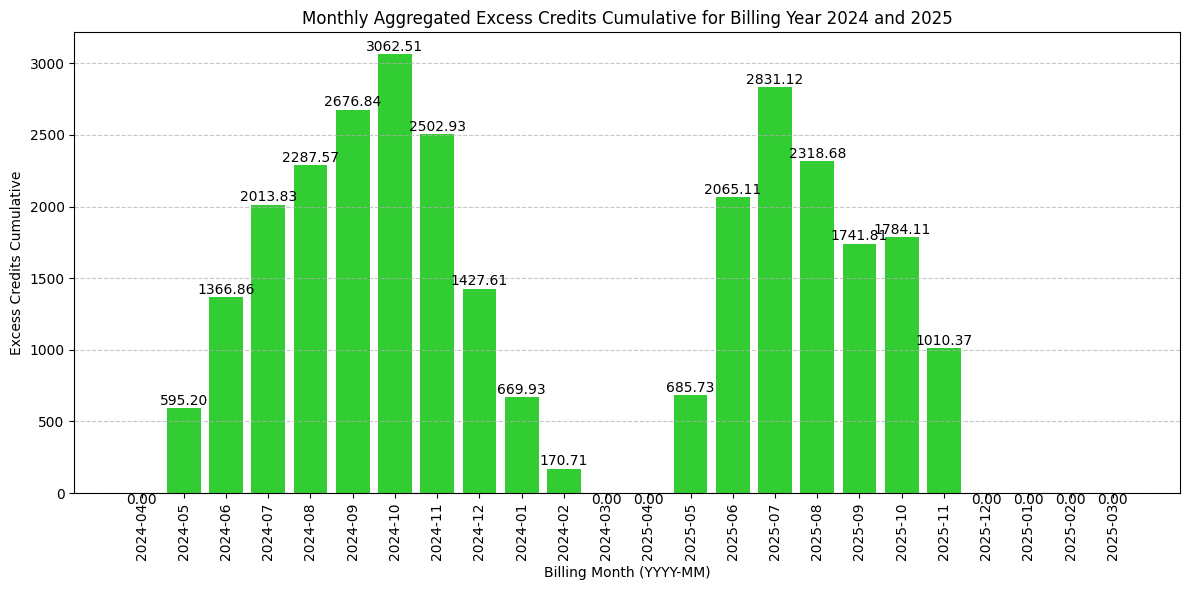

In [ ]:
# Define a mapping of month names to numbers
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Filter only for Billing Years 2024 and 2025
filtered_data = dashboard_filtered2[dashboard_filtered2['Billing_Year'].isin([2024, 2025])].copy()

# Ensure 'Excess_Credits_Cumulative' is numeric
filtered_data['Excess_Credits_Cumulative'] = pd.to_numeric(filtered_data['Excess_Credits_Cumulative'], errors='coerce')

# Convert Billing_Month from text to numeric using the mapping
filtered_data['Billing_Month'] = filtered_data['Billing_Month'].map(month_mapping)

# Drop any rows where Billing_Month is still NaN after mapping
filtered_data = filtered_data.dropna(subset=['Billing_Month'])

# Convert Billing_Month to integer
filtered_data['Billing_Month'] = filtered_data['Billing_Month'].astype(int)

# Extract the last row per Billing Month (based on max date_timestamp)
filtered_data = filtered_data.loc[
    filtered_data.groupby(['Billing_Year', 'Billing_Month'])['date_timestamp'].idxmax()
].reset_index(drop=True)

# Create Month-Year column using Billing Year and Billing Month (YYYY-MM format)
filtered_data['Month_Year'] = filtered_data.apply(
    lambda row: f"{row['Billing_Year']}-{str(row['Billing_Month']).zfill(2)}", axis=1
)

# Sort by actual chronological order using date_timestamp
filtered_data = filtered_data.sort_values(by='date_timestamp')

# Convert Month-Year to string for plotting
filtered_data['Month_Year'] = filtered_data['Month_Year'].astype(str)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Define bar colors based on positive or negative values
colors = filtered_data['Excess_Credits_Cumulative'].apply(lambda x: 'limegreen' if x > 0 else 'darkblue')

# Create bars
bars = ax.bar(
    filtered_data['Month_Year'],
    filtered_data['Excess_Credits_Cumulative'],
    color=colors,
    width=0.8
)

# Add dynamic data labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + (2 if height > 0 else -2),
        f'{height:.2f}',
        ha='center',
        va='bottom' if height > 0 else 'top'
    )

# Customize the chart
ax.set_xlabel('Billing Month (YYYY-MM)')
ax.set_ylabel('Excess Credits Cumulative')
ax.set_title('Monthly Aggregated Excess Credits Cumulative for Billing Year 2024 and 2025')
ax.set_xticks(range(len(filtered_data)))
ax.set_xticklabels(filtered_data['Month_Year'], rotation=90, ha='center')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
# Add the Data_Type_Label column based on datetime comparison
dashboard_filtered2['Data_Type_Label'] = dashboard_filtered2.apply(
    lambda row: 'Actual' if row['date_timestamp'] <= row['Solaredge_Update_Date'] else 'Estimated', axis=1
)

# Calculate Excess_Credits (Actual) using Excess_Credits_Cumulative
dashboard_filtered2['Excess_Credits'] = dashboard_filtered2.apply(
    lambda row: row['Excess_Credits_Cumulative'] if row['Data_Type_Label'] == 'Actual' else None, axis=1
)

# Fill Excess_Credits forward for continuity using ffill()
dashboard_filtered2['Excess_Credits'] = pd.to_numeric(
    dashboard_filtered2['Excess_Credits'], errors='coerce'
).ffill().fillna(0)

# Calculate Estimated_Excess_Credits (Estimated) using Excess_Credits_Cumulative
dashboard_filtered2['Estimated_Excess_Credits'] = dashboard_filtered2.apply(
    lambda row: row['Excess_Credits_Cumulative'] if row['Data_Type_Label'] == 'Estimated' else None, axis=1
)

# Fill Estimated_Excess_Credits forward for continuity using ffill()
dashboard_filtered2['Estimated_Excess_Credits'] = pd.to_numeric(
    dashboard_filtered2['Estimated_Excess_Credits'], errors='coerce'
).ffill().fillna(0)

# Debug: Preview the updated DataFrame
print(dashboard_filtered2[['date_timestamp', 'Excess_Credits_Cumulative',
                          'Excess_Credits', 'Estimated_Excess_Credits', 'Data_Type_Label']].head())


       date_timestamp  Excess_Credits_Cumulative  Excess_Credits  \
0 2024-01-08 00:00:00                        0.0             0.0   
1 2024-01-08 01:00:00                        0.0             0.0   
2 2024-01-08 02:00:00                        0.0             0.0   
3 2024-01-08 03:00:00                        0.0             0.0   
4 2024-01-08 04:00:00                        0.0             0.0   

   Estimated_Excess_Credits Data_Type_Label  
0                       0.0          Actual  
1                       0.0          Actual  
2                       0.0          Actual  
3                       0.0          Actual  
4                       0.0          Actual  


###Add Unified Production and Consumption

In [ ]:
# Create Unified_Production field
dashboard_filtered2['Unified_Production'] = dashboard_filtered2.apply(
    lambda row: row['Production'] if row['date_timestamp'] <= row['Solaredge_Update_Date'] else row['Estimated_Production'],
    axis=1
)

# Create Unified_Consumption field
dashboard_filtered2['Unified_Consumption'] = dashboard_filtered2.apply(
    lambda row: row['Consumption'] if row['date_timestamp'] <= row['Solaredge_Update_Date'] else row['Estimated_Consumption'],
    axis=1
)

# Compute Unified_Net_Usage
dashboard_filtered2['Unified_Net_Usage'] = dashboard_filtered2['Unified_Consumption'] - dashboard_filtered2['Unified_Production']



In [ ]:
# Map month names to numbers
month_to_num = {name: num for num, name in enumerate(calendar.month_name) if name}  # Skip empty entry at 0
dashboard_filtered2['Billing_Month_Num'] = dashboard_filtered2['Billing_Month'].map(month_to_num)

# Convert Billing_Year to integers (in case it's a float)
dashboard_filtered2['Billing_Year'] = dashboard_filtered2['Billing_Year'].astype(int)

# Create a YYYY-MM column
dashboard_filtered2['Billing_YearMonth'] = (
    dashboard_filtered2['Billing_Year'].astype(str) + '-' +
    dashboard_filtered2['Billing_Month_Num'].astype(str).str.zfill(2)
)

# Display the updated DataFrame
print(dashboard_filtered2[['Billing_Year', 'Billing_Month', 'Billing_Month_Num', 'Billing_YearMonth']].head())


   Billing_Year Billing_Month  Billing_Month_Num Billing_YearMonth
0          2023       January                  1           2023-01
1          2023       January                  1           2023-01
2          2023       January                  1           2023-01
3          2023       January                  1           2023-01
4          2023       January                  1           2023-01


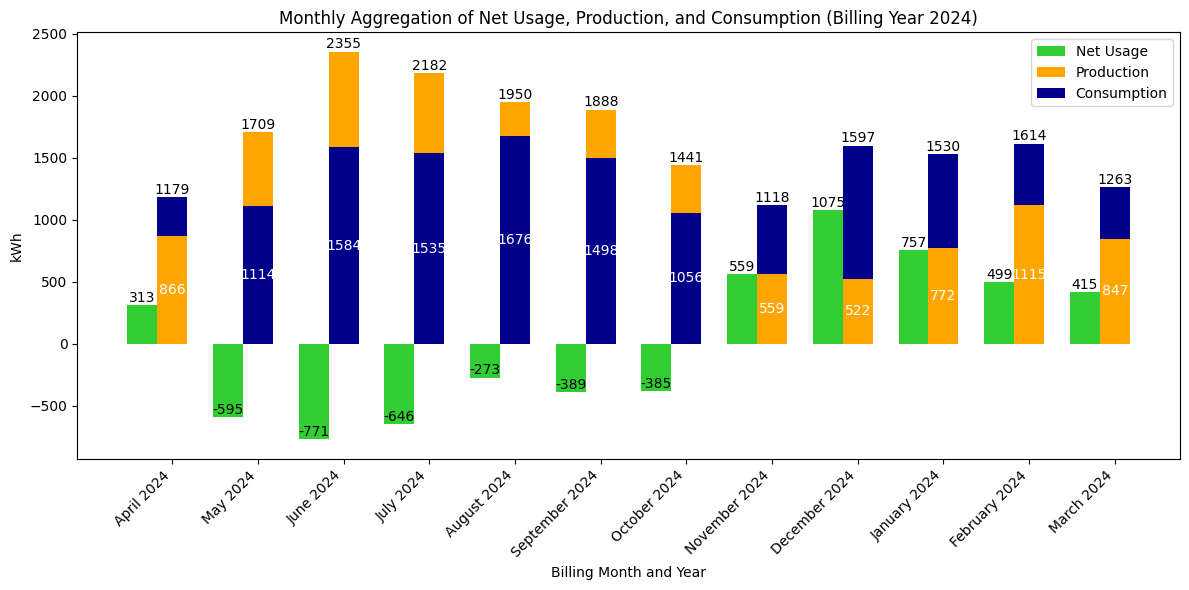

In [ ]:
# Filter data for the billing year 2024
dashboard_filtered_2024 = dashboard_filtered2[dashboard_filtered2['Billing_Year'] == 2024]

# Ensure data is sorted by date_timestamp
dashboard_filtered_2024 = dashboard_filtered_2024.sort_values(by='date_timestamp')

# Aggregate monthly data for the required columns
monthly_agg = dashboard_filtered_2024.groupby(['Billing_Month', 'Billing_Year'])[
    ['Unified_Net_Usage', 'Unified_Production', 'Unified_Consumption']
].sum()

# Reset the index to include Billing_Month and Billing_Year as columns
monthly_agg = monthly_agg.reset_index()

# Define custom sort order for months (April to March)
month_order = [
    "April", "May", "June", "July", "August", "September",
    "October", "November", "December", "January", "February", "March"
]

# Assign an order for sorting
monthly_agg['Month_Order'] = monthly_agg['Billing_Month'].apply(lambda x: month_order.index(x))

# Sort the data by Billing Year and Month Order
monthly_agg = monthly_agg.sort_values(by=['Billing_Year', 'Month_Order']).drop(columns=['Month_Order'])

# Create the bar positions
x = np.arange(len(monthly_agg))
bar_width = 0.35

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Determine the bottom and top dynamically based on the smaller and larger values
bottom_values = np.minimum(monthly_agg['Unified_Production'], monthly_agg['Unified_Consumption'])
top_values = np.maximum(monthly_agg['Unified_Production'], monthly_agg['Unified_Consumption']) - bottom_values
bottom_label = monthly_agg['Unified_Production'] <= monthly_agg['Unified_Consumption']

# Plot the Net Usage as a separate bar
bars1 = ax.bar(x - bar_width, monthly_agg['Unified_Net_Usage'],
               width=bar_width, label='Net Usage', color='limegreen')

# Plot the stacked bars
bars2 = ax.bar(x, bottom_values,
               width=bar_width,
               color=np.where(bottom_label, 'orange', 'darkblue'),
               label='Production' if bottom_label.all() else 'Consumption')
bars3 = ax.bar(x, top_values,
               bottom=bottom_values,
               width=bar_width,
               color=np.where(bottom_label, 'darkblue', 'orange'),
               label='Consumption' if bottom_label.all() else 'Production')

# Add data labels for Net Usage
for bar in bars1:
    height = bar.get_height()
    if height != 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 2,
            f'{int(height)}',
            ha='center', va='bottom'
        )

# Add data labels for stacked bars
for bar2, bar3 in zip(bars2, bars3):
    production_height = bar2.get_height()
    usage_height = bar3.get_height() + production_height

    # Bottom label
    if production_height != 0:
        ax.text(
            bar2.get_x() + bar2.get_width() / 2,
            production_height / 2,
            f'{int(production_height)}',
            ha='center', va='center', color='white'
        )
    # Top label
    if usage_height != 0:
        ax.text(
            bar3.get_x() + bar3.get_width() / 2,
            usage_height + 2,
            f'{int(usage_height)}',
            ha='center', va='bottom'
        )

# Customize the chart
ax.set_xlabel('Billing Month and Year')
ax.set_ylabel('kWh')
ax.set_title('Monthly Aggregation of Net Usage, Production, and Consumption (Billing Year 2024)')
ax.set_xticks(x)
ax.set_xticklabels(
    monthly_agg['Billing_Month'] + ' ' + monthly_agg['Billing_Year'].astype(str),
    rotation=45,
    ha='right'
)
ax.legend(['Net Usage', 'Production', 'Consumption'])

plt.tight_layout()
plt.show()


###The above graph matches the output from the electric data and the billing data so the new fields are checking out.
- see how this compares to the excess credits cumulative which is showing credit roll over.

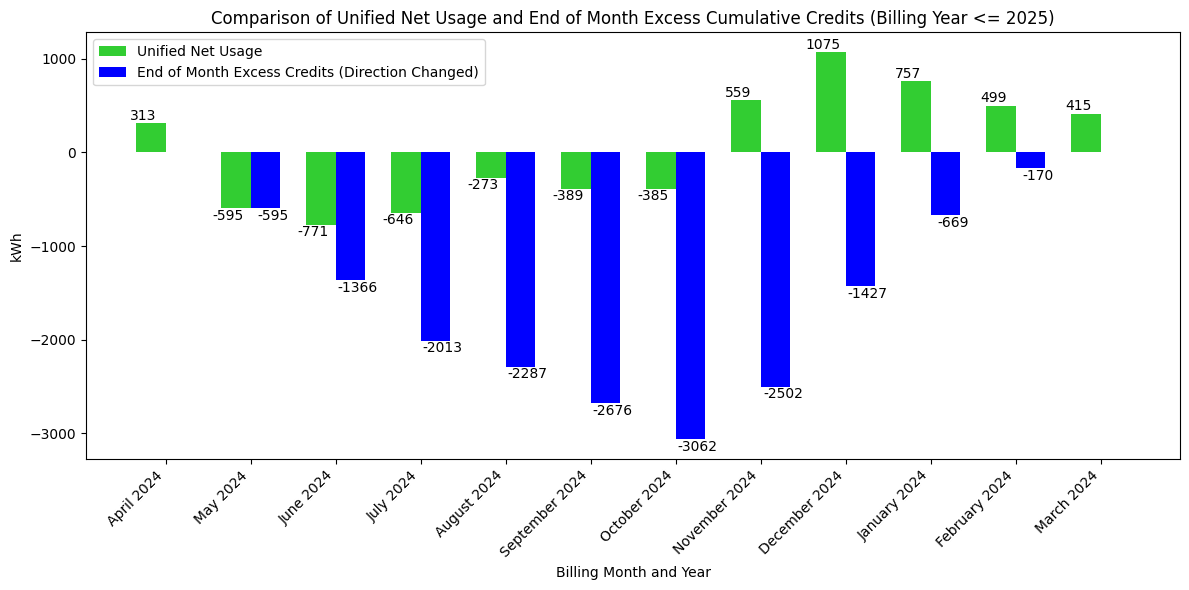

In [ ]:
# Filter data for billing year == 2024
dashboard_filtered3 = dashboard_filtered2[dashboard_filtered2['Billing_Year'] == 2024].copy()

# Create a 'Billing_Month_Year' column for grouping
dashboard_filtered3['Billing_Month_Year'] = (
    dashboard_filtered3['Billing_Month'] + ' ' + dashboard_filtered3['Billing_Year'].astype(str)
)

# Get the maximum 'date_timestamp' for each Billing_Month_Year
max_date_by_month = dashboard_filtered3.groupby(['Billing_Month', 'Billing_Year'])['date_timestamp'].max().reset_index()

# Retrieve the last Excess_Credits_Cumulative for each month and multiply by -1
max_date_with_credits = pd.merge(
    max_date_by_month,
    dashboard_filtered3[['date_timestamp', 'Excess_Credits_Cumulative']],
    on='date_timestamp',
    how='left'
).copy()
max_date_with_credits['Excess_Credits_Cumulative'] *= -1
max_date_with_credits.rename(columns={'Excess_Credits_Cumulative': 'End of Month Excess Credits (Direction Changed)'}, inplace=True)

# Prepare Unified_Net_Usage aggregated by Billing Month
monthly_net_usage = dashboard_filtered3.groupby(['Billing_Month', 'Billing_Year'])[
    'Unified_Net_Usage'
].sum().reset_index()

# Merge Unified_Net_Usage with max_date_with_credits
comparison_data = pd.merge(
    monthly_net_usage,
    max_date_with_credits,
    on=['Billing_Month', 'Billing_Year'],
    how='inner'
)

# Define custom sort order for months (April to March)
month_order = [
    "April", "May", "June", "July", "August", "September",
    "October", "November", "December", "January", "February", "March"
]

# Assign an order for sorting
comparison_data['Month_Order'] = comparison_data['Billing_Month'].apply(lambda x: month_order.index(x))

# Sort the data by Billing Year and Month Order
comparison_data = comparison_data.sort_values(by=['Billing_Year', 'Month_Order']).drop(columns=['Month_Order'])

# Create the bar positions
x = np.arange(len(comparison_data))
bar_width = 0.35

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Unified Net Usage
bars1 = ax.bar(x - bar_width / 2, comparison_data['Unified_Net_Usage'],
               width=bar_width, label='Unified Net Usage', color='limegreen')

# Plot End of Month Excess Credits
bars2 = ax.bar(x + bar_width / 2, comparison_data['End of Month Excess Credits (Direction Changed)'],
               width=bar_width, label='End of Month Excess Credits (Direction Changed)', color='blue')

# Add data labels for Unified Net Usage (slightly offset to the left)
for bar in bars1:
    height = bar.get_height()
    if height != 0:
        ax.text(
            bar.get_x() + bar.get_width() / 4,  # Offset slightly to the left
            height + (2 if height > 0 else -4),
            f'{int(height)}',
            ha='center', va='bottom' if height > 0 else 'top'
        )

# Add data labels for End of Month Excess Credits (slightly offset to the right)
for bar in bars2:
    height = bar.get_height()
    if height != 0:
        ax.text(
            bar.get_x() + 3 * bar.get_width() / 4,  # Offset slightly to the right
            height + (2 if height > 0 else -4),
            f'{int(height)}',
            ha='center', va='bottom' if height > 0 else 'top'
        )

# Customize the chart
ax.set_xlabel('Billing Month and Year')
ax.set_ylabel('kWh')
ax.set_title('Comparison of Unified Net Usage and End of Month Excess Cumulative Credits (Billing Year <= 2025)')
ax.set_xticks(x)
ax.set_xticklabels(
    comparison_data['Billing_Month'] + ' ' + comparison_data['Billing_Year'].astype(str),
    rotation=45,
    ha='right'
)
ax.legend()

plt.tight_layout()
plt.show()


#Pickle the data again

In [ ]:
# Save the updated DataFrame
dashboard_filtered2.to_pickle('/content/drive/My Drive/bi_solar_dashboard_excess.pkl')
print("Data for dashboard saved.")

Data for dashboard saved.


In [ ]:
dashboard_filtered = pd.read_pickle('/content/drive/My Drive/bi_solar_dashboard_excess.pkl')

In [ ]:
dashboard_filtered.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96263 entries, 0 to 96262
Data columns (total 70 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   date_timestamp                                         96263 non-null  datetime64[ns]
 1   day_of_month                                           96263 non-null  int64         
 2   is_daylight                                            96263 non-null  int64         
 3   solar_angle                                            96263 non-null  float64       
 4   solar_azimuth                                          96263 non-null  float64       
 5   global_tilted_irradiance                               96263 non-null  float32       
 6   solar_day_count                                        96263 non-null  int64         
 7   Estimated_Area_Solar_Production                        96263 non-nu

#Compute actual realized savings, payout and remaining balance for system

In [ ]:
def calculate_solar_metrics(df, system_cost):
    """
    Calculate actual realized savings, payout for uncovered production, and remaining balance.
    Add a column for data type label indicating 'Actual' or 'Estimated' based on date.

    Parameters:
        df (pd.DataFrame): DataFrame containing solar data with required columns.
        system_cost (float): Initial cost of the solar system.

    Returns:
        pd.DataFrame: Updated DataFrame with calculated metrics and data type label.
    """
    # Create a copy to avoid modifying the original dataframe
    metrics_df = df.copy()

    # Calculate the cumulative realized savings
    metrics_df['Cumulative_Realized_Savings'] = metrics_df['Row_Level_Savings'].cumsum()

    # Calculate the remaining balance
    metrics_df['Remaining_Balance'] = system_cost - metrics_df['Cumulative_Realized_Savings']
    metrics_df['Remaining_Balance'] = metrics_df['Remaining_Balance'].clip(lower=0)  # Prevent negative balances

    # Add a data type label
    metrics_df['Data_Type_Label'] = metrics_df['date_timestamp'].apply(
        lambda x: 'Actual' if x <= datetime.now() else 'Estimated'
    )

    return metrics_df

# Assuming `dashboard_filtered` is your original dataframe and system cost is $12,037
system_cost = 12037.0
calculated_metrics = calculate_solar_metrics(dashboard_filtered, system_cost)

# **Fix: Drop 'Data_Type_Label' before merging to avoid duplicates**
dashboard_filtered = dashboard_filtered.drop(columns=['Data_Type_Label'], errors='ignore')

# Merge calculated metrics back into the original dataframe without losing any columns
dashboard_filtered = dashboard_filtered.merge(
    calculated_metrics[['date_timestamp',
                         'Cumulative_Realized_Savings', 'Remaining_Balance', 'Data_Type_Label']],
    on='date_timestamp',
    how='left'
)


In [ ]:
dashboard_filtered.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96263 entries, 0 to 96262
Data columns (total 72 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   date_timestamp                                         96263 non-null  datetime64[ns]
 1   day_of_month                                           96263 non-null  int64         
 2   is_daylight                                            96263 non-null  int64         
 3   solar_angle                                            96263 non-null  float64       
 4   solar_azimuth                                          96263 non-null  float64       
 5   global_tilted_irradiance                               96263 non-null  float32       
 6   solar_day_count                                        96263 non-null  int64         
 7   Estimated_Area_Solar_Production                        96263 non-nu

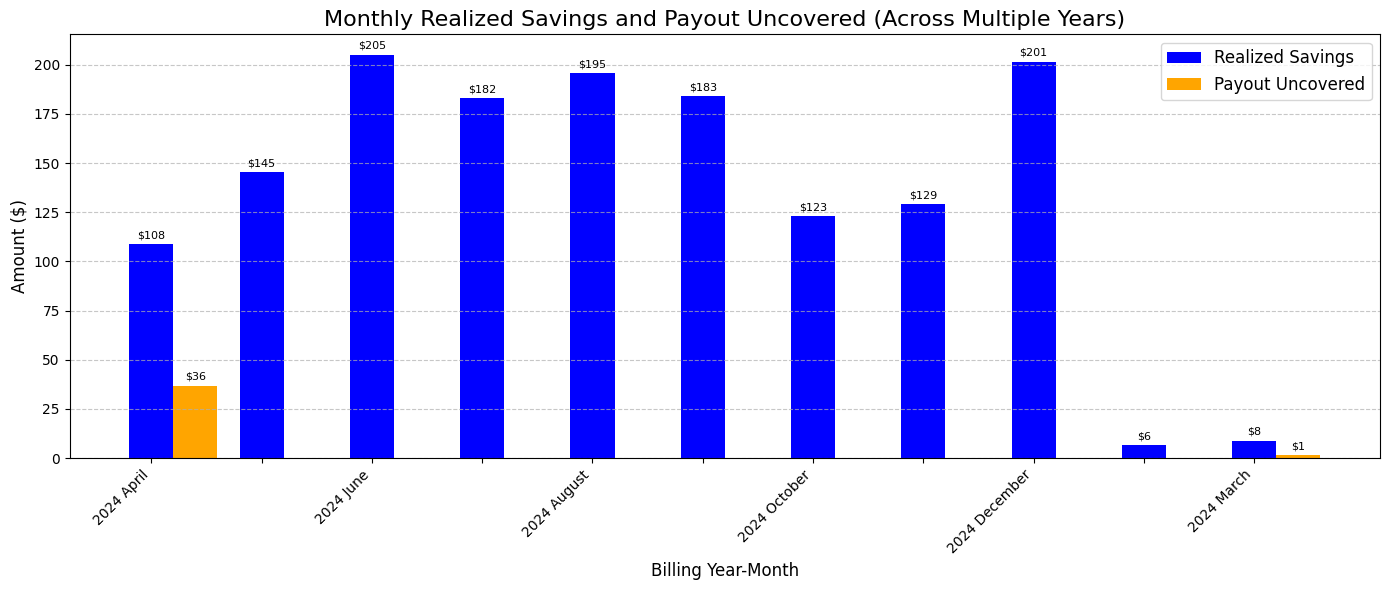

In [ ]:
import matplotlib.pyplot as plt

# ✅ Define a custom sort order for months (April to March)
month_order = [
    "April", "May", "June", "July", "August", "September",
    "October", "November", "December", "January", "February", "March"
]

# ✅ Filter data for Billing Year == 2024
filtered_data = dashboard_filtered[dashboard_filtered['Billing_Year'] == 2024].copy()

# ✅ Assign a numeric ordering for billing months based on the April-March cycle
filtered_data['Month_Order'] = filtered_data['Billing_Month'].apply(lambda x: month_order.index(x))

# ✅ Aggregate data by Billing_Year and Billing_Month
monthly_data = filtered_data.groupby(['Billing_Year', 'Billing_Month', 'Month_Order']).agg({
    'Row_Level_Savings': 'sum',
    'Row_Level_Payout': 'sum',
    'Cumulative_Realized_Savings': 'max',  # Cumulative values don't need summation
    'Remaining_Balance': 'min'  # Minimum remaining balance to show trends
}).reset_index()

# ✅ Ensure sorting is done by Billing Year first, then Month Order (April - March cycle)
monthly_data = monthly_data.sort_values(by=['Billing_Year', 'Month_Order']).drop(columns=['Month_Order'])

# ✅ Create a new column for x-axis labeling using Billing_Year and Billing_Month
monthly_data['YearMonth'] = monthly_data.apply(
    lambda row: f"{row['Billing_Year']} {row['Billing_Month']}", axis=1
)

# ✅ Create the bar chart
fig, ax = plt.subplots(figsize=(14, 6))

bar_width = 0.4
x = range(len(monthly_data))

# ✅ Bar for realized savings
bars1 = ax.bar(
    x,
    monthly_data['Row_Level_Savings'],
    width=bar_width,
    label='Realized Savings',
    color='blue'
)

# ✅ Bar for payout uncovered
bars2 = ax.bar(
    [i + bar_width for i in x],
    monthly_data['Row_Level_Payout'],
    width=bar_width,
    label='Payout Uncovered',
    color='orange'
)

# ✅ Add labels to bars (only if value > $0)
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 2,
            f'${int(height)}',
            ha='center',
            va='bottom',
            fontsize=8
        )

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 2,
            f'${int(height)}',
            ha='center',
            va='bottom',
            fontsize=8
        )

# ✅ Customize the chart
ax.set_xlabel('Billing Year-Month', fontsize=12)
ax.set_ylabel('Amount ($)', fontsize=12)
ax.set_title('Monthly Realized Savings and Payout Uncovered (Across Multiple Years)', fontsize=16)

# ✅ Ensure x-axis labels are aligned properly and show every other label
xtick_positions = list(x)
xtick_labels = [monthly_data['YearMonth'].iloc[i] if i % 2 == 0 else "" for i in range(len(monthly_data))]
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45, fontsize=10, ha='right')

plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# ✅ Display the bar chart
plt.show()


In [ ]:
dashboard_filtered.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96263 entries, 0 to 96262
Data columns (total 72 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   date_timestamp                                         96263 non-null  datetime64[ns]
 1   day_of_month                                           96263 non-null  int64         
 2   is_daylight                                            96263 non-null  int64         
 3   solar_angle                                            96263 non-null  float64       
 4   solar_azimuth                                          96263 non-null  float64       
 5   global_tilted_irradiance                               96263 non-null  float32       
 6   solar_day_count                                        96263 non-null  int64         
 7   Estimated_Area_Solar_Production                        96263 non-nu

In [ ]:
# Find the rows where Remaining_Balance equals 0
zero_balance_rows = dashboard_filtered[dashboard_filtered['Remaining_Balance'] == 0]

# Check if there are any such rows
if not zero_balance_rows.empty:
    # Get the minimum date_timestamp
    min_date = zero_balance_rows['date_timestamp'].min()
    print(f"The minimum date_timestamp where Remaining_Balance is 0: {min_date}")
else:
    print("No rows where Remaining_Balance is 0.")


The minimum date_timestamp where Remaining_Balance is 0: 2030-11-10 01:00:00


#Determine the current remaining balance, break even point, and chart the remaining balance to verify accuracy

In [ ]:
# Add the Estimated_Remaining_Balance column
dashboard_filtered['Estimated_Remaining_Balance'] = dashboard_filtered.apply(
    lambda row: row['Remaining_Balance'] if row['Data_Type_Label'] == 'Estimated' else None, axis=1
)

# Fill forward to propagate the estimated remaining balance for continuity
dashboard_filtered['Estimated_Remaining_Balance'] = dashboard_filtered['Estimated_Remaining_Balance'].ffill()

# Ensure the column is numerical and no leftover NaNs affect calculations
dashboard_filtered['Estimated_Remaining_Balance'] = pd.to_numeric(dashboard_filtered['Estimated_Remaining_Balance'], errors='coerce').fillna(0)

# Preview the updated DataFrame
print(dashboard_filtered[['date_timestamp', 'Remaining_Balance', 'Estimated_Remaining_Balance', 'Data_Type_Label']].head())


       date_timestamp  Remaining_Balance  Estimated_Remaining_Balance  \
0 2024-01-08 00:00:00            12037.0                          0.0   
1 2024-01-08 01:00:00            12037.0                          0.0   
2 2024-01-08 02:00:00            12037.0                          0.0   
3 2024-01-08 03:00:00            12037.0                          0.0   
4 2024-01-08 04:00:00            12037.0                          0.0   

  Data_Type_Label  
0          Actual  
1          Actual  
2          Actual  
3          Actual  
4          Actual  


In [ ]:
# Add the Actual_Remaining_Balance column
min_actual_balance = dashboard_filtered[dashboard_filtered['Data_Type_Label'] == 'Actual']['Remaining_Balance'].min()

dashboard_filtered['Actual_Remaining_Balance'] = dashboard_filtered.apply(
    lambda row: row['Remaining_Balance'] if row['Data_Type_Label'] == 'Actual' else min_actual_balance, axis=1
)

# Ensure the column is numerical
dashboard_filtered['Actual_Remaining_Balance'] = pd.to_numeric(dashboard_filtered['Actual_Remaining_Balance'], errors='coerce')

# Preview the updated DataFrame
print(dashboard_filtered[['date_timestamp', 'Remaining_Balance', 'Actual_Remaining_Balance', 'Data_Type_Label']].head())


       date_timestamp  Remaining_Balance  Actual_Remaining_Balance  \
0 2024-01-08 00:00:00            12037.0                   12037.0   
1 2024-01-08 01:00:00            12037.0                   12037.0   
2 2024-01-08 02:00:00            12037.0                   12037.0   
3 2024-01-08 03:00:00            12037.0                   12037.0   
4 2024-01-08 04:00:00            12037.0                   12037.0   

  Data_Type_Label  
0          Actual  
1          Actual  
2          Actual  
3          Actual  
4          Actual  


**As of 2025-02-16, the remaining balance is $9947.44.**
**As of 2025-02-16, the actual remaining balance is $9947.44.**
The Actual Remaining Balance does not reach zero within the available data.
**The break-even point for Estimated Remaining Balance is reached on 2030-11-10.**


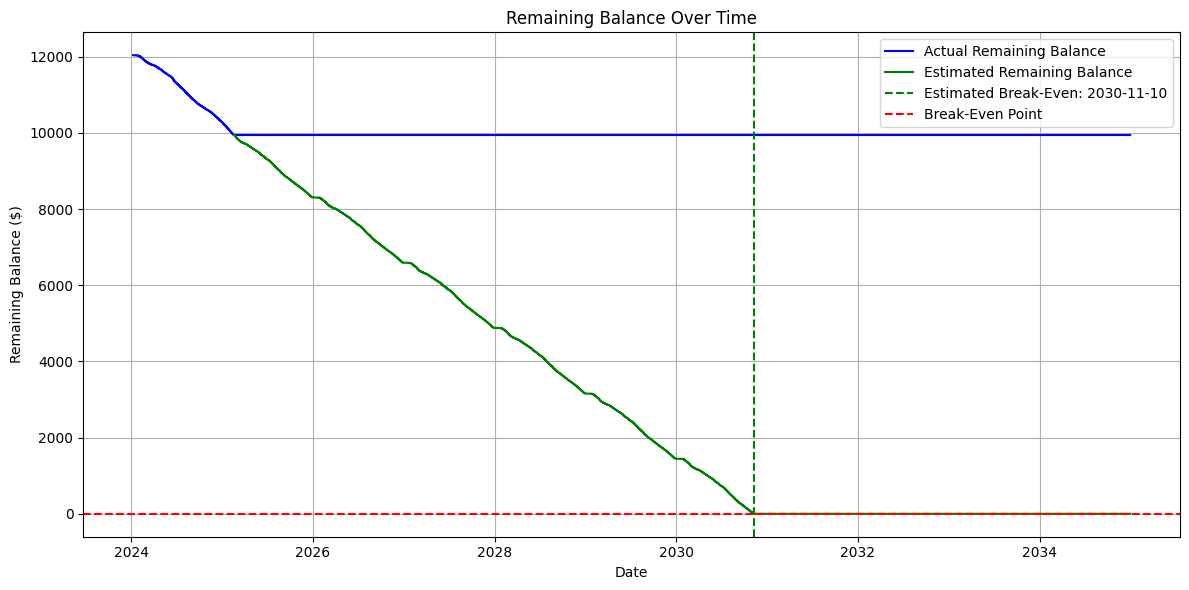

In [ ]:
# **Step 1: Ensure 'date_timestamp' is in datetime format and create a 'date' column**
dashboard_filtered['date_timestamp'] = pd.to_datetime(dashboard_filtered['date_timestamp'])
dashboard_filtered['date'] = dashboard_filtered['date_timestamp'].dt.date

# **Step 2: Get Yesterday's Date**
yesterday = datetime.now().date() - timedelta(days=1)

# **Step 3: Get the Current Remaining Balance as of Yesterday**
# Filter data up to yesterday
data_up_to_yesterday = dashboard_filtered[dashboard_filtered['date'] <= yesterday]

if not data_up_to_yesterday.empty:
    # Get the last available remaining balance
    last_row = data_up_to_yesterday.iloc[-1]
    current_remaining_balance = last_row['Remaining_Balance']
    current_actual_balance = last_row['Actual_Remaining_Balance']
    current_date = last_row['date']
    print(f"**As of {current_date}, the remaining balance is ${current_remaining_balance:.2f}.**")
    print(f"**As of {current_date}, the actual remaining balance is ${current_actual_balance:.2f}.**")
else:
    print("No data available up to yesterday.")

# **Step 4: Determine When the Break-Even Point Occurs**
# Break-even for Actual Remaining Balance
break_even_actual_data = dashboard_filtered[dashboard_filtered['Actual_Remaining_Balance'] <= 0]
if not break_even_actual_data.empty:
    break_even_actual_row = break_even_actual_data.iloc[0]
    break_even_actual_date = break_even_actual_row['date']
    print(f"**The break-even point for Actual Remaining Balance is reached on {break_even_actual_date}.**")
else:
    print("The Actual Remaining Balance does not reach zero within the available data.")

# Break-even for Estimated Remaining Balance
break_even_estimated_data = dashboard_filtered[
    (dashboard_filtered['Data_Type_Label'] == 'Estimated') &
    (dashboard_filtered['Estimated_Remaining_Balance'] <= 0)
]
if not break_even_estimated_data.empty:
    break_even_estimated_row = break_even_estimated_data.iloc[0]
    break_even_estimated_date = break_even_estimated_row['date']
    print(f"**The break-even point for Estimated Remaining Balance is reached on {break_even_estimated_date}.**")
else:
    print("The Estimated Remaining Balance does not reach zero within the available data.")

# **Step 5: Plot Actual Remaining Balance and Estimated Remaining Balance Over Time**
plt.figure(figsize=(12, 6))

# Plot Actual Remaining Balance
plt.plot(
    dashboard_filtered['date'],
    dashboard_filtered['Actual_Remaining_Balance'],
    label='Actual Remaining Balance',
    color='blue'
)

# Plot Estimated Remaining Balance
estimated_data = dashboard_filtered[dashboard_filtered['Data_Type_Label'] == 'Estimated']
if not estimated_data.empty:
    plt.plot(
        estimated_data['date'],
        estimated_data['Estimated_Remaining_Balance'],
        label='Estimated Remaining Balance',
        color='green'
    )

# Add the break-even lines
if not break_even_actual_data.empty:
    plt.axvline(
        x=break_even_actual_date,
        color='blue',
        linestyle='--',
        label=f'Actual Break-Even: {break_even_actual_date}'
    )
if not break_even_estimated_data.empty:
    plt.axvline(
        x=break_even_estimated_date,
        color='green',
        linestyle='--',
        label=f'Estimated Break-Even: {break_even_estimated_date}'
    )

# Add a horizontal line for zero balance
plt.axhline(y=0, color='red', linestyle='--', label='Break-Even Point')

# Configure the plot
plt.xlabel('Date')
plt.ylabel('Remaining Balance ($)')
plt.title('Remaining Balance Over Time')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Save
dashboard_filtered.to_pickle('/content/drive/My Drive/bi_solar_dashboard_final.pkl')

#Validation Images for dashboard

In [ ]:
# Load and prepare the data
dashboard_filtered = pd.read_pickle('/content/drive/My Drive/bi_solar_dashboard_final.pkl')

In [ ]:
dashboard_filtered.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96263 entries, 0 to 96262
Data columns (total 75 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   date_timestamp                                         96263 non-null  datetime64[ns]
 1   day_of_month                                           96263 non-null  int64         
 2   is_daylight                                            96263 non-null  int64         
 3   solar_angle                                            96263 non-null  float64       
 4   solar_azimuth                                          96263 non-null  float64       
 5   global_tilted_irradiance                               96263 non-null  float32       
 6   solar_day_count                                        96263 non-null  int64         
 7   Estimated_Area_Solar_Production                        96263 non-nu

##Production and Consumption over Time (Including Estimated)

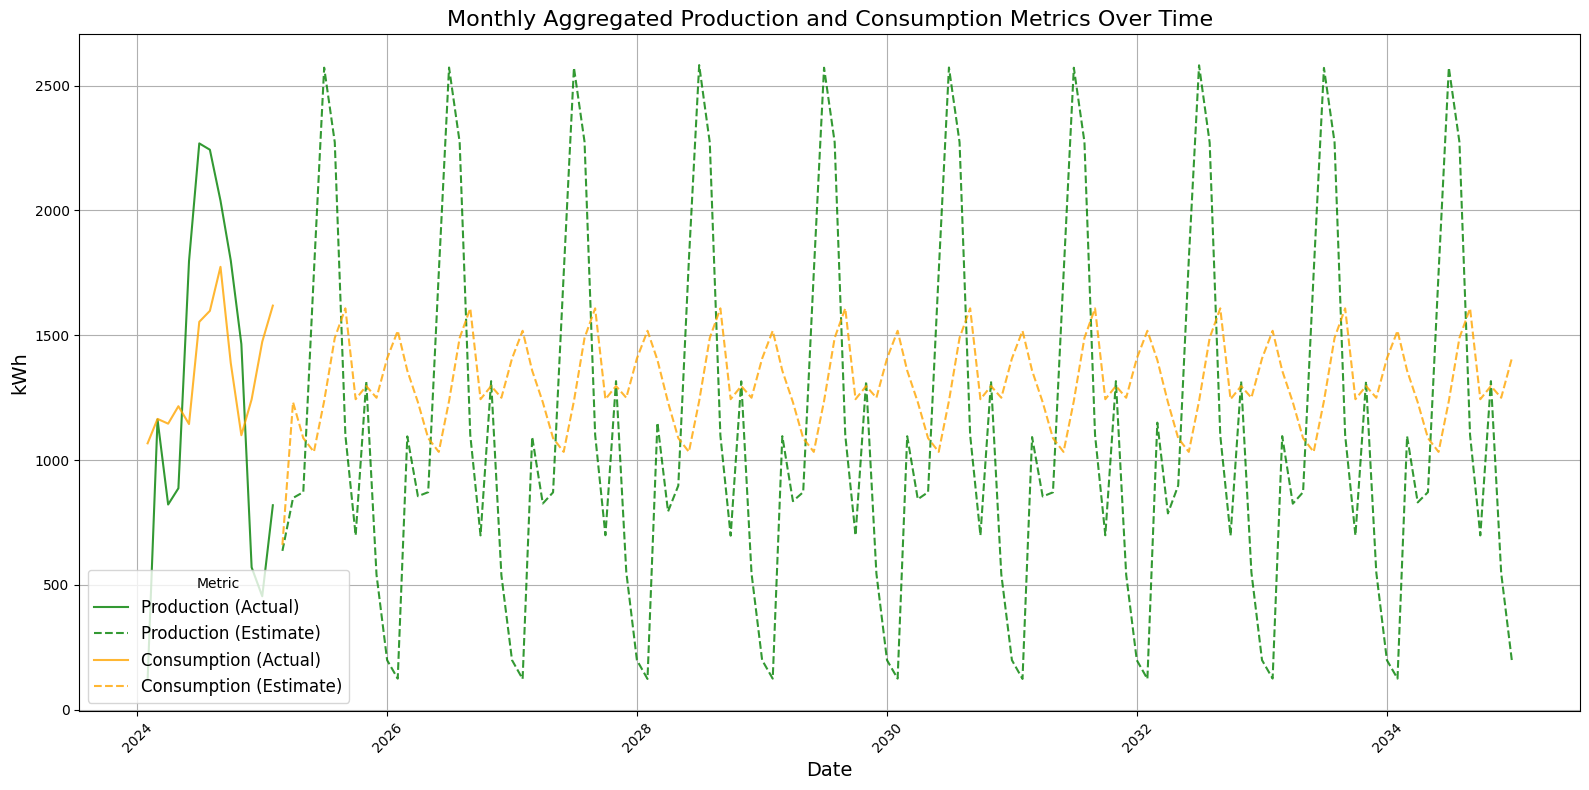

In [ ]:
# Define metrics and aggregate monthly
metrics = ['Production', 'Estimated_Production', 'Consumption', 'Estimated_Consumption']
solaredge_update_date = dashboard_filtered['Solaredge_Update_Date'].iloc[0]  # Assuming Solaredge_Update_Date is constant

# Exclude Solaredge_Update_Date during aggregation
dashboard_filtered_monthly = (
    dashboard_filtered.set_index('date_timestamp')
    [metrics]
    .resample('ME')  # Use 'ME' for month-end aggregation
    .sum()
    .reset_index()
)

# Add Solaredge_Update_Date back after aggregation
dashboard_filtered_monthly['Solaredge_Update_Date'] = solar_update_date

# Prepare data for visualization
visual_data = dashboard_filtered_monthly.set_index('date_timestamp')

# Use Solaredge_Update_Date to define masks
visual_data['Production_Actual'] = visual_data['Production'].where(visual_data.index <= solar_update_date)
visual_data['Production_Estimate'] = visual_data['Estimated_Production'].where(visual_data.index > solar_update_date)
visual_data['Consumption_Actual'] = visual_data['Consumption'].where(visual_data.index <= solar_update_date)
visual_data['Consumption_Estimate'] = visual_data['Estimated_Consumption'].where(visual_data.index > solar_update_date)

# Plot with specific colors and styles
plt.figure(figsize=(16, 8))
sns.lineplot(data=visual_data, x=visual_data.index, y='Production_Actual', label='Production (Actual)', color='green', alpha=0.8)
sns.lineplot(data=visual_data, x=visual_data.index, y='Production_Estimate', label='Production (Estimate)', color='green', linestyle='--', alpha=0.8)
sns.lineplot(data=visual_data, x=visual_data.index, y='Consumption_Actual', label='Consumption (Actual)', color='orange', alpha=0.8)
sns.lineplot(data=visual_data, x=visual_data.index, y='Consumption_Estimate', label='Consumption (Estimate)', color='orange', linestyle='--', alpha=0.8)

# Add titles and labels
plt.title("Monthly Aggregated Production and Consumption Metrics Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("kWh", fontsize=14)
plt.legend(title="Metric", fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


##Bar chart of consumption

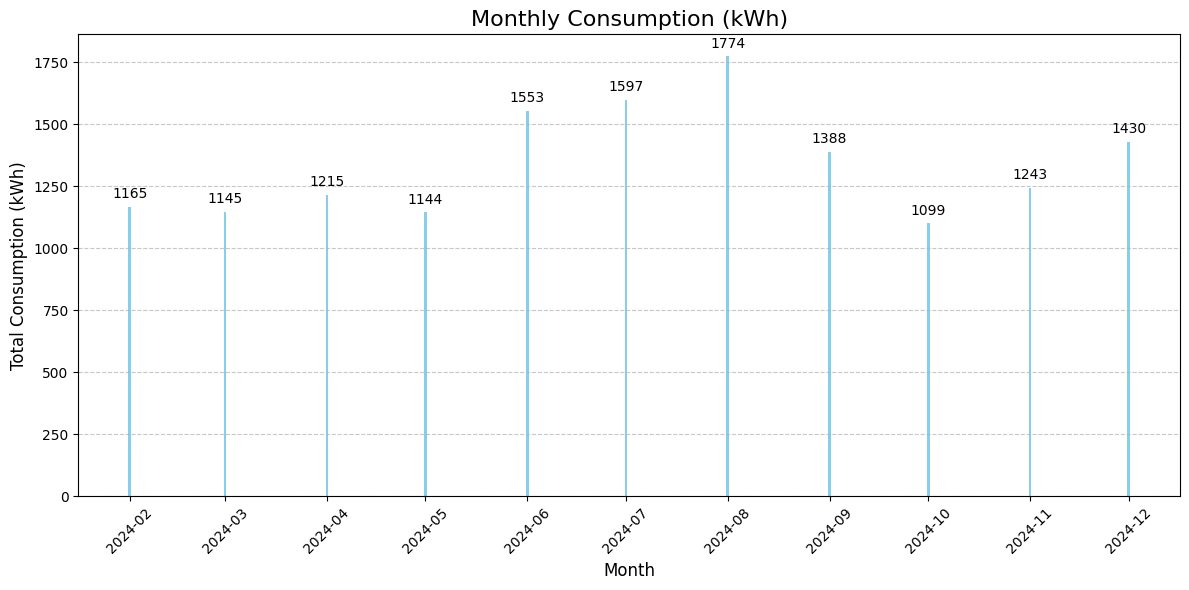

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'dashboard_filtered' is your dataframe and it's already loaded
# Ensure the date column is in datetime format
dashboard_filtered['date_timestamp'] = pd.to_datetime(dashboard_filtered['date_timestamp'])

# Filter data between February 1, 2024, and December 31, 2024
filtered_data = dashboard_filtered[
    (dashboard_filtered['date_timestamp'] >= '2024-02-01') &
    (dashboard_filtered['date_timestamp'] <= '2024-12-31')
]

# Group data by month and sum the 'Consumption' column
monthly_consumption = filtered_data.groupby(filtered_data['date_timestamp'].dt.to_period('M')).agg({'Consumption': 'sum'})
monthly_consumption.index = monthly_consumption.index.to_timestamp()  # Convert period to timestamp for plotting

# Create the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(monthly_consumption.index, monthly_consumption['Consumption'], color='skyblue')

# Add labels on top of the bars with consistent spacing
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02 * max(monthly_consumption['Consumption']),  # Adjust label position
        f'{int(height)}',
        ha='center',
        fontsize=10
    )

# Chart formatting
plt.title('Monthly Consumption (kWh)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Consumption (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Define the date range for filtering
start_date = '2025-02-01'
end_date = '2025-02-28'

# Ensure the date column is in datetime format
dashboard_filtered['date_timestamp'] = pd.to_datetime(dashboard_filtered['date_timestamp'], errors='coerce')

# Filter the DataFrame for the specified date range
filtered_data = dashboard_filtered[
    (dashboard_filtered['date_timestamp'] >= start_date) &
    (dashboard_filtered['date_timestamp'] <= end_date)
]

# Get the last day of the month
last_day = filtered_data['date_timestamp'].max()

# Retrieve Excess Credit Balance (value of Excess_Credits_Cumulative on the last day)
excess_credit_balance = filtered_data.loc[
    filtered_data['date_timestamp'] == last_day, 'Excess_Credits_Cumulative'
].values[0]

# Calculate the sum of Leftover_Shortfall
leftover_shortfall_sum = filtered_data['Remaining_Shortfall'].sum()

# Display the results
print(f"Results for the month of February 2025:")
print(f"Excess Credit Balance (as of {last_day.date()}): {excess_credit_balance}")
print(f"Total Leftover Shortfall: {leftover_shortfall_sum}")


Results for the month of February 2025:
Excess Credit Balance (as of 2025-02-28): 170.70502000012831
Total Leftover Shortfall: 0.0


#Validating net energy used and net energy produced against electric data.

In [ ]:
dashboard_filtered.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 6601 entries, 1320 to 8591
Data columns (total 77 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   date_timestamp                                         6601 non-null   datetime64[ns]
 1   day_of_month                                           6601 non-null   int64         
 2   is_daylight                                            6601 non-null   int64         
 3   solar_angle                                            6601 non-null   float64       
 4   solar_azimuth                                          6601 non-null   float64       
 5   global_tilted_irradiance                               6601 non-null   float32       
 6   solar_day_count                                        6601 non-null   int64         
 7   Estimated_Area_Solar_Production                        6601 non-null   

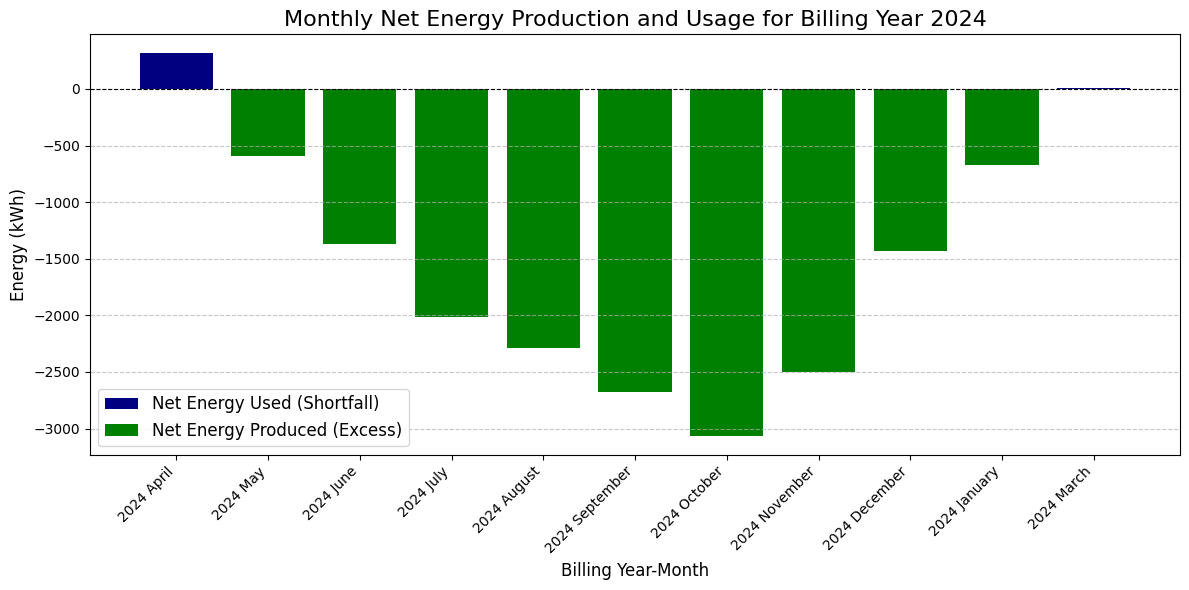

In [ ]:
# Define a custom sort order for months (April to March)
month_order = [
    "April", "May", "June", "July", "August", "September",
    "October", "November", "December", "January", "February", "March"
]

# Ensure Billing_Year is numeric for proper filtering
dashboard_filtered['Billing_Year'] = pd.to_numeric(dashboard_filtered['Billing_Year'], errors='coerce')

# Ensure Billing_Month_Start is in datetime format
dashboard_filtered['Billing_Month_Start'] = pd.to_datetime(dashboard_filtered['Billing_Month_Start'], errors='coerce')

# Filter for Billing Year 2024
dashboard_filtered = dashboard_filtered[dashboard_filtered['Billing_Year'] == 2024].copy()

# Adjust Net Energy Produced to be negative for visualization
dashboard_filtered['Net_Energy_Produced'] = -1 * dashboard_filtered['Excess_Credits_Cumulative']
dashboard_filtered['Net_Energy_Used'] = dashboard_filtered['Remaining_Shortfall']

# Extract the last row of each Billing Month for Net Energy Produced
last_row_per_month = dashboard_filtered.loc[
    dashboard_filtered.groupby(['Billing_Year', 'Billing_Month'])['date_timestamp'].idxmax()
].reset_index(drop=True)

# Group by Billing_Year and Billing_Month and aggregate Net Energy Used as a sum
monthly_data = dashboard_filtered.groupby(['Billing_Year', 'Billing_Month', 'Billing_Month_Start']).agg({
    'Net_Energy_Used': 'sum'  # Sum for total shortfall in the month
}).reset_index()

# Merge the last-row Net Energy Produced values into the aggregated dataset
monthly_data = monthly_data.merge(
    last_row_per_month[['Billing_Year', 'Billing_Month', 'Net_Energy_Produced']],
    on=['Billing_Year', 'Billing_Month'],
    how='left'
)

# Ensure mutual exclusivity: if there is production, set usage to 0
monthly_data['Net_Energy_Used'] = monthly_data['Net_Energy_Used'].where(monthly_data['Net_Energy_Produced'] == 0, 0)

# Assign an order for sorting based on the billing year cycle (April - March)
monthly_data['Month_Order'] = monthly_data['Billing_Month'].apply(lambda x: month_order.index(x))

# Sort data by Billing Year and Month Order (April - March)
monthly_data = monthly_data.sort_values(by=['Billing_Year', 'Month_Order']).drop(columns=['Month_Order'])

# Create a column for x-axis labeling as Billing_Year + Billing_Month
monthly_data['YearMonth'] = monthly_data.apply(
    lambda row: f"{row['Billing_Year']} {row['Billing_Month']}", axis=1
)

# Plot the visual
plt.figure(figsize=(12, 6))

# Plot Net Energy Used (Navy Blue)
plt.bar(
    monthly_data['YearMonth'],
    monthly_data['Net_Energy_Used'],
    color='navy',
    label='Net Energy Used (Shortfall)',
    width=0.8
)

# Plot Net Energy Produced (Green)
plt.bar(
    monthly_data['YearMonth'],
    monthly_data['Net_Energy_Produced'],
    color='green',
    label='Net Energy Produced (Excess)',
    width=0.8
)

# Add labels, legend, and formatting
plt.title('Monthly Net Energy Production and Usage for Billing Year 2024', fontsize=16)
plt.xlabel('Billing Year-Month', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Horizontal line at 0
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for better readability
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


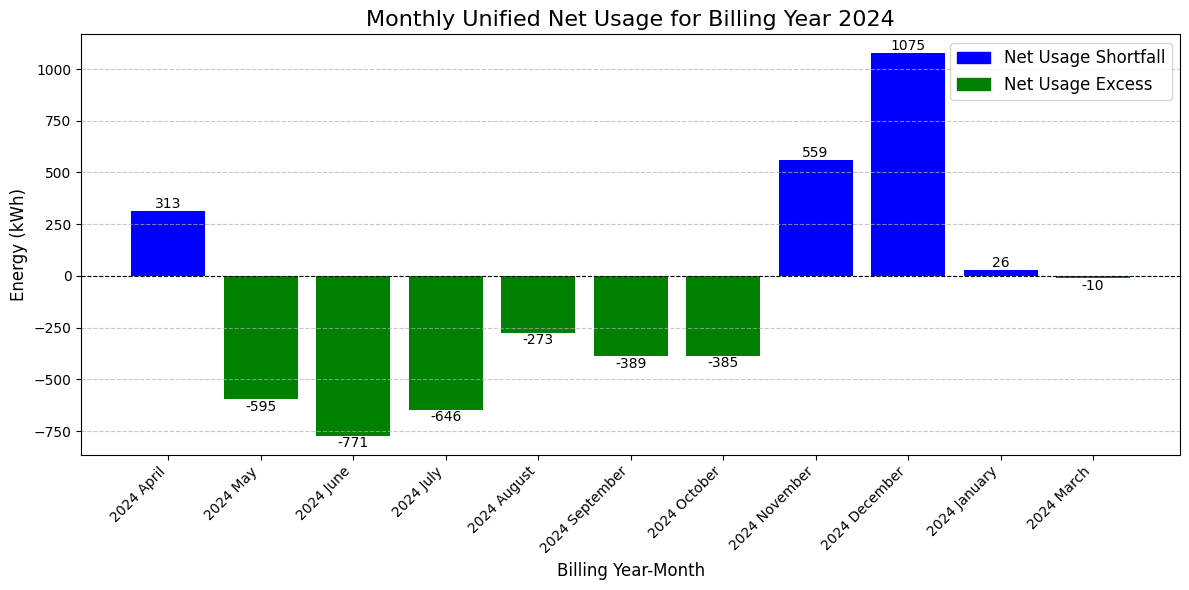

In [ ]:
import matplotlib.pyplot as plt

# Define a custom sort order for months (April to March)
month_order = [
    "April", "May", "June", "July", "August", "September",
    "October", "November", "December", "January", "February", "March"
]

# Ensure Billing_Year is numeric for proper filtering
dashboard_filtered['Billing_Year'] = pd.to_numeric(dashboard_filtered['Billing_Year'], errors='coerce')

# Ensure Billing_Month_Start is in datetime format
dashboard_filtered['Billing_Month_Start'] = pd.to_datetime(dashboard_filtered['Billing_Month_Start'], errors='coerce')

# Filter for Billing Year 2024
dashboard_filtered = dashboard_filtered[dashboard_filtered['Billing_Year'] == 2024].copy()

# Group by Billing_Year and Billing_Month and aggregate Unified_Net_Usage
monthly_data = dashboard_filtered.groupby(['Billing_Year', 'Billing_Month', 'Billing_Month_Start']).agg({
    'Unified_Net_Usage': 'sum'  # Sum for total net usage in the month
}).reset_index()

# Assign an order for sorting based on the billing year cycle (April - March)
monthly_data['Month_Order'] = monthly_data['Billing_Month'].apply(lambda x: month_order.index(x))

# Sort data by Billing Year and Month Order (April - March)
monthly_data = monthly_data.sort_values(by=['Billing_Year', 'Month_Order']).drop(columns=['Month_Order'])

# Create a column for x-axis labeling as Billing_Year + Billing_Month
monthly_data['YearMonth'] = monthly_data.apply(
    lambda row: f"{row['Billing_Year']} {row['Billing_Month']}", axis=1
)

# Determine bar colors and assign correct labels
bar_colors = ['blue' if val > 0 else 'green' for val in monthly_data['Unified_Net_Usage']]
legend_labels = {'blue': 'Net Usage Shortfall', 'green': 'Net Usage Excess'}

# Plot the visual
plt.figure(figsize=(12, 6))

# Plot Unified Net Usage with color differentiation
bars = plt.bar(
    monthly_data['YearMonth'],
    monthly_data['Unified_Net_Usage'],
    color=bar_colors,
    width=0.8
)

# ✅ Add data labels to bars
for bar in bars:
    height = bar.get_height()
    if height != 0:  # Avoid labeling bars with zero height
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + (2 if height > 0 else -2),  # Adjust placement based on sign
            f'{int(height)}',
            ha='center',
            va='bottom' if height > 0 else 'top',
            fontsize=10
        )

# ✅ Create custom legend manually
from matplotlib.patches import Patch
legend_patches = [Patch(color='blue', label='Net Usage Shortfall'),
                  Patch(color='green', label='Net Usage Excess')]
plt.legend(handles=legend_patches, fontsize=12)

# Add labels, legend, and formatting
plt.title('Monthly Unified Net Usage for Billing Year 2024', fontsize=16)
plt.xlabel('Billing Year-Month', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Horizontal line at 0
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#Prediction Validation

In [ ]:
dashboard_filtered.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96263 entries, 0 to 96262
Data columns (total 75 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   date_timestamp                                         96263 non-null  datetime64[ns]
 1   day_of_month                                           96263 non-null  int64         
 2   is_daylight                                            96263 non-null  int64         
 3   solar_angle                                            96263 non-null  float64       
 4   solar_azimuth                                          96263 non-null  float64       
 5   global_tilted_irradiance                               96263 non-null  float32       
 6   solar_day_count                                        96263 non-null  int64         
 7   Estimated_Area_Solar_Production                        96263 non-nu

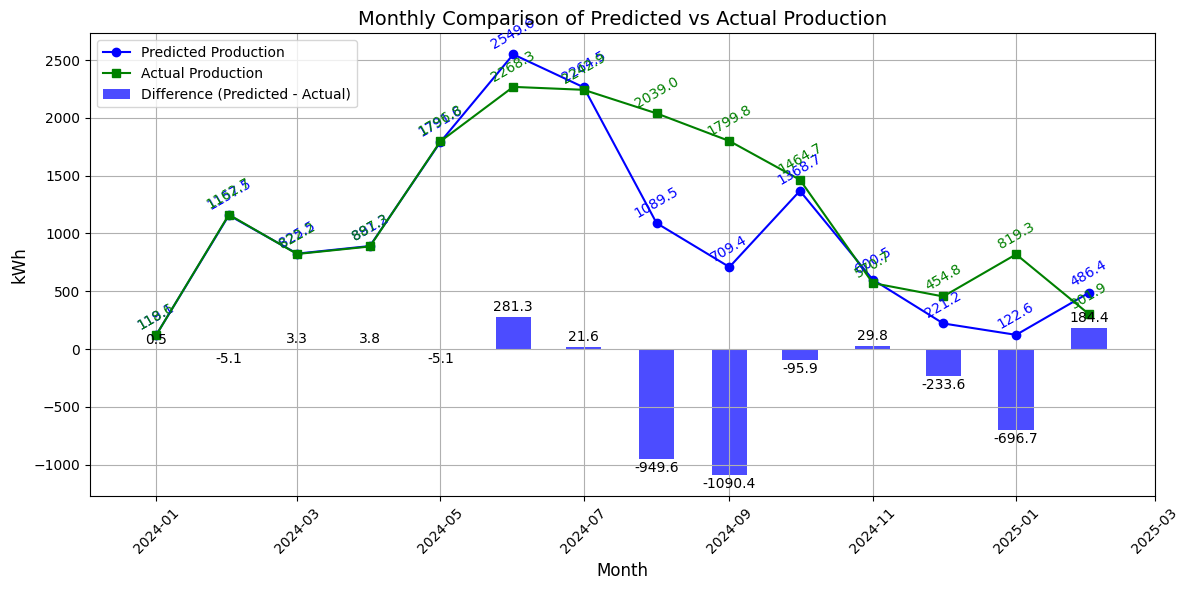

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure 'date' column is in datetime format
dashboard_filtered['date'] = pd.to_datetime(dashboard_filtered['date'])

# Ensure 'Solaredge_Update_Date' is defined correctly
if 'Solaredge_Update_Date' in dashboard_filtered.columns:
    solaredge_update_date = dashboard_filtered['Solaredge_Update_Date'].max()
    dashboard_filtered = dashboard_filtered[dashboard_filtered['date_timestamp'] < solaredge_update_date]
else:
    raise KeyError("Solaredge_Update_Date column not found in the dataset")

# Aggregate data at the month level
dashboard_filtered['month'] = dashboard_filtered['date'].dt.to_period('M')
monthly_agg = dashboard_filtered.groupby('month')[['predicted_value', 'Production']].sum().reset_index()

# Compute difference between Predicted and Actual Value
monthly_agg['Difference'] = monthly_agg['predicted_value'] - monthly_agg['Production']

# Convert 'month' to datetime for plotting
monthly_agg['month'] = monthly_agg['month'].dt.to_timestamp()

# Plot the comparison
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(monthly_agg['month'], monthly_agg['predicted_value'], marker='o', linestyle='-', label='Predicted Production', color='blue')
ax1.plot(monthly_agg['month'], monthly_agg['Production'], marker='s', linestyle='-', label='Actual Production', color='green')

# Add data labels to lines with spacing to avoid overlap
for i, txt in enumerate(monthly_agg['predicted_value']):
    ax1.text(monthly_agg['month'][i], monthly_agg['predicted_value'][i] + 50, f'{txt:.1f}', ha='center', fontsize=10, color='blue', rotation=30)

for i, txt in enumerate(monthly_agg['Production']):
    ax1.text(monthly_agg['month'][i], monthly_agg['Production'][i] + 50, f'{txt:.1f}', ha='center', fontsize=10, color='green', rotation=30)

# Add bar chart for the difference, aligning bars with the same axis and thicker bars
bar_width = 15  # Adjust thickness
bars = ax1.bar(monthly_agg['month'], monthly_agg['Difference'], width=bar_width, alpha=0.7, color='blue', label='Difference (Predicted - Actual)')

# Add data labels dynamically to avoid overlap
for bar in bars:
    height = bar.get_height()
    if height != 0:
        ax1.text(bar.get_x() + bar.get_width()/2, height + (20 if height > 0 else -20),
                 f'{height:.1f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# Formatting
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('kWh', fontsize=12)
ax1.set_title('Monthly Comparison of Predicted vs Actual Production', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
